## Transaction Cost Analysis Framework for Corporate Bonds 
- Replicated Paper: Transaction cost analytics for corporate bonds by XIN GUO, CHARLES-ALBERT LEHALLE, and RENYUAN XU (2022)
- Link: https://www.tandfonline.com/doi/epdf/10.1080/14697688.2022.2054723?needAccess=true

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import wrds
from datetime import datetime, timedelta, time
import re
import warnings
warnings.filterwarnings("ignore")


In [2]:
id_wrds = '*********'
conn = wrds.Connection(wrds_username=id_wrds)

Loading library list...
Done


In [3]:
US_HOLIDAYS_2024 = [
    "20240101",  # New Year's Day
    "20240115",  # Martin Luther King Jr. Day
    "20240219",  # Presidents' Day
    "20240527",  # Memorial Day
    "20240704",  # Independence Day
    "20240902",  # Labor Day
    "20241128",  # Thanksgiving Day
    "20241225",  # Christmas Day
]

def generate_trading_days(start_date, end_date):
    trading_days = []
    current_date = start_date
    while current_date <= end_date:
        # Exclude weekends (Saturday=5, Sunday=6) and holidays
        date_str = current_date.strftime("%Y%m%d")
        if current_date.weekday() < 5 and date_str not in US_HOLIDAYS_2024:
            trading_days.append(date_str)
        current_date += timedelta(days=1)
    return trading_days

In [4]:
# Define start and end dates
start_date = datetime(2023, 3, 28)
end_date = datetime(2024, 12, 24)

# Generate the list of trading days
trading_days = generate_trading_days(start_date, end_date)

company_symbol = ['AAPL']

### AAPL bonds for past one year

In [5]:
table = 'trace_enhanced'
dataframes = []
for symbol in company_symbol:
    enh_trace_query = f"""
      SELECT *
      FROM trace.{table}
      WHERE trd_exctn_dt BETWEEN '{start_date}' AND '{end_date}'
      AND company_symbol = '{symbol}'
      """
    try:
        print(f"Executing query for {symbol}")
        data = conn.raw_sql(enh_trace_query)
        dataframes.append(data)
    except Exception as e:
        print(f"Error querying symbol {symbol}: {e}")

enh_trace_data = pd.concat(dataframes, ignore_index=True)
enh_trace_data.columns = [col.upper() for col in enh_trace_data.columns]
# Convert Execution Date and Time to a proper datetime format for accurate matching
enh_trace_data['TRD_EXCTN_DT'] = pd.to_datetime(enh_trace_data['TRD_EXCTN_DT'])
enh_trace_data['TRD_EXCTN_TM'] = pd.to_datetime(enh_trace_data['TRD_EXCTN_TM'], format='%H:%M:%S').dt.time
enh_trace_data['TRD_RPT_TM'] = pd.to_datetime(enh_trace_data['TRD_RPT_TM'], format='%H:%M:%S').dt.time
enh_trace_data

Executing query for AAPL


CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
0       037833AK6  AAPL4001809           AAPL   2023-03-28     10:18:51   
1       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
2       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
3       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
4       037833AK6  AAPL4001809           AAPL   2023-03-28     10:28:53   
...           ...          ...            ...          ...          ...   
436893  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
436894  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
436895  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
436896  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   
436897  037833EW6  AAPL5584758           AAPL   2024-03-28     17:14:06   

        TRD_RPT_DT TRD_RPT_TM MSG_SEQ_NB TRC_ST SCRTY_TYPE_CD  ... SUB_PRDCT  \
0       2023-03-28   10:18:55    0023554      T          None  ...      CORP   
1       2023-03-28   10:20:15    0023970      T          None  ...      CORP   
2       2023-03-28   10:20:21    0024007      T          None  ...      CORP   
3       2023-03-28   10:27:23    0028019      T          None  ...      CORP   
4       2023-03-28   10:29:14    0028893      T          None  ...      CORP   
...            ...        ...        ...    ...           ...  ...       ...   
436893  2024-03-28   12:32:51    0107022      T          None  ...      CORP   
436894  2024-03-28   12:34:23    0107683      T          None  ...      CORP   
436895  2024-03-28   12:34:23    0107684      T          None  ...      CORP   
436896  2024-03-28   13:46:01    0159086      T          None  ...      CORP   
436897  2024-03-28   17:14:09    0175833      T          None  ...      CORP   

         STLMNT_DT  TRD_MOD_3  TRD_MOD_4 RPTG_PARTY_TYPE  LCKD_IN_IND  \
0       2023-03-30       None       None               D         None   
1       2023-03-30       None       None               D         None   
2       2023-03-30       None       None               D         None   
3       2023-03-30       None       None               D         None   
4       2023-03-30       None       None               D         None   
...            ...        ...        ...             ...          ...   
436893  2024-04-02       None       None               D            Y   
436894  2024-04-02       None       None               T         None   
436895  2024-04-02       None       None               T         None   
436896  2024-04-02       None       None               D         None   
436897  2024-04-02       None       None               D         None   

       ATS_INDICATOR PR_TRD_DT FIRST_TRADE_CTRL_DATE FIRST_TRADE_CTRL_NUM  
0               None      None            2023-03-28              0023554  
1               None      None            2023-03-28              0023970  
2               None      None            2023-03-28              0024007  
3               None      None            2023-03-28              0028019  
4               None      None            2023-03-28              0028893  
...              ...       ...                   ...                  ...  
436893          None      None            2024-03-28              0107022  
436894             Y      None            2024-03-28              0107683  
436895             Y      None            2024-03-28              0107684  
436896          None      None            2024-03-28              0159086  
436897          None      None            2024-03-28              0175833  

[436898 rows x 42 columns]

In [6]:
temp_etd =  enh_trace_data

In [7]:
# Separate data into different categories
post_TR = temp_etd[temp_etd['TRC_ST'].isin(['T', 'R'])]
post_XC = temp_etd[temp_etd['TRC_ST'].isin(['X', 'C'])]
post_Y = temp_etd[temp_etd['TRC_ST'] == 'Y']

# Step 1.1: Remove Cancellation and Correction
keys = ['CUSIP_ID', 'TRD_EXCTN_DT', 'RPTD_PR', 'ENTRD_VOL_QT', 'RPT_SIDE_CD', 'CNTRA_MP_ID', 'MSG_SEQ_NB']

#keys = ['cusip_id', 'trd_exctn_dt', 'trd_exctn_tm', 'rptd_pr', 'entrd_vol_qt', 'rpt_side_cd', 'cntra_mp_id', 'msg_seq_nb']
_clean_post1 = post_TR.merge(post_XC[keys + ['TRC_ST']], on=keys, how='left', suffixes=('', '_XC'))
_clean_post1 = _clean_post1[_clean_post1['TRC_ST_XC'].isna()].drop(columns=['TRC_ST_XC'])
_clean_post1

CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
0       037833AK6  AAPL4001809           AAPL   2023-03-28     10:18:51   
1       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
2       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
3       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
4       037833AK6  AAPL4001809           AAPL   2023-03-28     10:28:53   
...           ...          ...            ...          ...          ...   
434577  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
434578  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
434579  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
434580  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   
434581  037833EW6  AAPL5584758           AAPL   2024-03-28     17:14:06   

        TRD_RPT_DT TRD_RPT_TM MSG_SEQ_NB TRC_ST SCRTY_TYPE_CD  ... SUB_PRDCT  \
0       2023-03-28   10:18:55    0023554      T          None  ...      CORP   
1       2023-03-28   10:20:15    0023970      T          None  ...      CORP   
2       2023-03-28   10:20:21    0024007      T          None  ...      CORP   
3       2023-03-28   10:27:23    0028019      T          None  ...      CORP   
4       2023-03-28   10:29:14    0028893      T          None  ...      CORP   
...            ...        ...        ...    ...           ...  ...       ...   
434577  2024-03-28   12:32:51    0107022      T          None  ...      CORP   
434578  2024-03-28   12:34:23    0107683      T          None  ...      CORP   
434579  2024-03-28   12:34:23    0107684      T          None  ...      CORP   
434580  2024-03-28   13:46:01    0159086      T          None  ...      CORP   
434581  2024-03-28   17:14:09    0175833      T          None  ...      CORP   

         STLMNT_DT  TRD_MOD_3  TRD_MOD_4 RPTG_PARTY_TYPE  LCKD_IN_IND  \
0       2023-03-30       None       None               D         None   
1       2023-03-30       None       None               D         None   
2       2023-03-30       None       None               D         None   
3       2023-03-30       None       None               D         None   
4       2023-03-30       None       None               D         None   
...            ...        ...        ...             ...          ...   
434577  2024-04-02       None       None               D            Y   
434578  2024-04-02       None       None               T         None   
434579  2024-04-02       None       None               T         None   
434580  2024-04-02       None       None               D         None   
434581  2024-04-02       None       None               D         None   

       ATS_INDICATOR PR_TRD_DT FIRST_TRADE_CTRL_DATE FIRST_TRADE_CTRL_NUM  
0               None      None            2023-03-28              0023554  
1               None      None            2023-03-28              0023970  
2               None      None            2023-03-28              0024007  
3               None      None            2023-03-28              0028019  
4               None      None            2023-03-28              0028893  
...              ...       ...                   ...                  ...  
434577          None      None            2024-03-28              0107022  
434578             Y      None            2024-03-28              0107683  
434579             Y      None            2024-03-28              0107684  
434580          None      None            2024-03-28              0159086  
434581          None      None            2024-03-28              0175833  

[432285 rows x 42 columns]

In [8]:
# Step 1.2: Remove Reversals
keys_reversal = ['CUSIP_ID', 'TRD_EXCTN_DT', 'RPTD_PR', 'ENTRD_VOL_QT', 'RPT_SIDE_CD', 'CNTRA_MP_ID']

#keys_reversal = ['cusip_id', 'trd_exctn_dt', 'trd_exctn_tm', 'rptd_pr', 'entrd_vol_qt', 'rpt_side_cd', 'cntra_mp_id']
_clean_post2 = _clean_post1.merge(post_Y[keys_reversal + ['ORIG_MSG_SEQ_NB', 'TRC_ST']], 
                                  left_on=keys_reversal + ['MSG_SEQ_NB'], 
                                  right_on=keys_reversal + ['ORIG_MSG_SEQ_NB'], 
                                  how='left', suffixes=('', '_Y'))
_clean_post2 = _clean_post2[_clean_post2['TRC_ST_Y'].isna()].drop(columns=['TRC_ST_Y', 'ORIG_MSG_SEQ_NB'])
_clean_post2

CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
0       037833AK6  AAPL4001809           AAPL   2023-03-28     10:18:51   
1       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
2       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
3       037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
4       037833AK6  AAPL4001809           AAPL   2023-03-28     10:28:53   
...           ...          ...            ...          ...          ...   
432280  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
432281  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
432282  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
432283  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   
432284  037833EW6  AAPL5584758           AAPL   2024-03-28     17:14:06   

        TRD_RPT_DT TRD_RPT_TM MSG_SEQ_NB TRC_ST SCRTY_TYPE_CD  ...  \
0       2023-03-28   10:18:55    0023554      T          None  ...   
1       2023-03-28   10:20:15    0023970      T          None  ...   
2       2023-03-28   10:20:21    0024007      T          None  ...   
3       2023-03-28   10:27:23    0028019      T          None  ...   
4       2023-03-28   10:29:14    0028893      T          None  ...   
...            ...        ...        ...    ...           ...  ...   
432280  2024-03-28   12:32:51    0107022      T          None  ...   
432281  2024-03-28   12:34:23    0107683      T          None  ...   
432282  2024-03-28   12:34:23    0107684      T          None  ...   
432283  2024-03-28   13:46:01    0159086      T          None  ...   
432284  2024-03-28   17:14:09    0175833      T          None  ...   

         STLMNT_DT TRD_MOD_3  TRD_MOD_4  RPTG_PARTY_TYPE LCKD_IN_IND  \
0       2023-03-30      None       None                D        None   
1       2023-03-30      None       None                D        None   
2       2023-03-30      None       None                D        None   
3       2023-03-30      None       None                D        None   
4       2023-03-30      None       None                D        None   
...            ...       ...        ...              ...         ...   
432280  2024-04-02      None       None                D           Y   
432281  2024-04-02      None       None                T        None   
432282  2024-04-02      None       None                T        None   
432283  2024-04-02      None       None                D        None   
432284  2024-04-02      None       None                D        None   

        ATS_INDICATOR PR_TRD_DT FIRST_TRADE_CTRL_DATE FIRST_TRADE_CTRL_NUM  \
0                None      None            2023-03-28              0023554   
1                None      None            2023-03-28              0023970   
2                None      None            2023-03-28              0024007   
3                None      None            2023-03-28              0028019   
4                None      None            2023-03-28              0028893   
...               ...       ...                   ...                  ...   
432280           None      None            2024-03-28              0107022   
432281              Y      None            2024-03-28              0107683   
432282              Y      None            2024-03-28              0107684   
432283           None      None            2024-03-28              0159086   
432284           None      None            2024-03-28              0175833   

       ORIG_MSG_SEQ_NB_Y  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
432280               NaN  
432281               NaN  
432282               NaN  
432283               NaN  
432284               NaN  

[432266 rows x 42 columns]

In [9]:
# Step 3.1: Separate Sell and Buy records for inter-dealer trades
agency_s = _clean_post2[(_clean_post2['RPT_SIDE_CD'] == 'S') & (_clean_post2['CNTRA_MP_ID'] == 'D')]
agency_b = _clean_post2[(_clean_post2['RPT_SIDE_CD'] == 'B') & (_clean_post2['CNTRA_MP_ID'] == 'D')]

print(f"Number of Sell (S) records: {len(agency_s)}")  

# Step 3.2: Match Buy and Sell records using CUSIP_ID, trade execution date, price, and volume
# Note: Trade execution time is excluded as it is less reliable.
keys_match = ['CUSIP_ID', 'TRD_EXCTN_DT', 'RPTD_PR', 'ENTRD_VOL_QT']

# Perform a left join to find unmatched Buy records
unmatched_buy_trades = agency_b.merge(
    agency_s[keys_match + ['RPT_SIDE_CD']], 
    on=keys_match, 
    how='left', 
    indicator=True
)

# Keep only unmatched Buy records (those not found in Sell records)
unmatched_buy_trades = unmatched_buy_trades[unmatched_buy_trades['_merge'] == 'left_only'].drop(columns=['_merge', 'RPT_SIDE_CD_y'])

print(f"Number of unmatched Buy (B) records: {len(unmatched_buy_trades)}")

# Step 3.3: Combine cleaned data
# Include:
# - All trades where CNTRA_MP_ID = 'C'
# - All Sell (S) inter-dealer trades
# - Unmatched Buy (B) inter-dealer trades
trace_enhanced = pd.concat([
    _clean_post2[_clean_post2['CNTRA_MP_ID'] == 'C'],  # CNTRA_MP_ID = 'C' trades
    agency_s,                              # Sell (S) inter-dealer trades
    unmatched_buy_trades                          # Unmatched Buy (B) inter-dealer trades
])

print(f"Customer trades: {len(_clean_post2[_clean_post2['CNTRA_MP_ID'] == 'C'])}")
print(f"Final cleaned dataset size: {len(trace_enhanced)}") 
print(f"Percentage cleaned: {len(trace_enhanced)*100/len(temp_etd)}%")

Number of Sell (S) records: 113967
Number of unmatched Buy (B) records: 2298
Customer trades: 157990
Final cleaned dataset size: 274255
Percentage cleaned: 62.77323311161873%


In [10]:
# Filter out weekends and holidays
df = trace_enhanced[~(trace_enhanced['TRD_EXCTN_DT'].dt.dayofweek.isin([5, 6]) | trace_enhanced['TRD_EXCTN_DT'].isin(US_HOLIDAYS_2024))]
print(f"Records after removing unusual trading days: {len(df)}")

# Define trading hours
trading_start = time(8, 0)
trading_end = time(17, 15)

# Filter trades within trading hours
trace_enhanced_cleaned = df[(df['TRD_EXCTN_TM'] >= trading_start) & (df['TRD_EXCTN_TM'] <= trading_end)]

print(f"Records after removing trades outside normal hours: {len(trace_enhanced_cleaned)}")

Records after removing unusual trading days: 274191
Records after removing trades outside normal hours: 270054


In [11]:
trace_enhanced_cleaned = trace_enhanced_cleaned.reset_index(drop = True)
trace_enhanced_cleaned.columns

Index(['CUSIP_ID', 'BOND_SYM_ID', 'COMPANY_SYMBOL', 'TRD_EXCTN_DT',
       'TRD_EXCTN_TM', 'TRD_RPT_DT', 'TRD_RPT_TM', 'MSG_SEQ_NB', 'TRC_ST',
       'SCRTY_TYPE_CD', 'WIS_FL', 'CMSN_TRD', 'ENTRD_VOL_QT', 'RPTD_PR',
       'YLD_SIGN_CD', 'YLD_PT', 'ASOF_CD', 'DAYS_TO_STTL_CT', 'SALE_CNDTN_CD',
       'SALE_CNDTN2_CD', 'RPT_SIDE_CD', 'BUY_CMSN_RT', 'BUY_CPCTY_CD',
       'SELL_CMSN_RT', 'SELL_CPCTY_CD', 'CNTRA_MP_ID', 'AGU_QSR_ID',
       'SPCL_TRD_FL', 'TRDG_MKT_CD', 'DISSEM_FL', 'BLOOMBERG_IDENTIFIER',
       'SUB_PRDCT', 'STLMNT_DT', 'TRD_MOD_3', 'TRD_MOD_4', 'RPTG_PARTY_TYPE',
       'LCKD_IN_IND', 'ATS_INDICATOR', 'PR_TRD_DT', 'FIRST_TRADE_CTRL_DATE',
       'FIRST_TRADE_CTRL_NUM', 'ORIG_MSG_SEQ_NB_Y', 'RPT_SIDE_CD_x'],
      dtype='object')

In [12]:
# Number of trades
num_trades = len(trace_enhanced_cleaned)

# Number of customer buy and sell trades
num_customer_buy = len(trace_enhanced_cleaned[trace_enhanced_cleaned['RPT_SIDE_CD'] == 'B'])
num_customer_sell = len(trace_enhanced_cleaned[trace_enhanced_cleaned['RPT_SIDE_CD'] == 'S'])

# Total trading volume
total_volume = trace_enhanced_cleaned['ENTRD_VOL_QT'].sum()

# Average trading volume per trade
avg_volume = total_volume / num_trades

# Average price
avg_price = trace_enhanced_cleaned['RPTD_PR'].mean()

# Proportion of customer buy and sell volume
buy_volume = trace_enhanced_cleaned[trace_enhanced_cleaned['RPT_SIDE_CD'] == 'B']['ENTRD_VOL_QT'].sum()
sell_volume = trace_enhanced_cleaned[trace_enhanced_cleaned['RPT_SIDE_CD'] == 'S']['ENTRD_VOL_QT'].sum()
prop_buy_volume = buy_volume / total_volume * 100
prop_sell_volume = sell_volume / total_volume * 100

# Daily trading frequency
trace_enhanced_cleaned['TRD_EXCTN_DT'] = pd.to_datetime(trace_enhanced_cleaned['TRD_EXCTN_DT'])
num_trading_days = trace_enhanced_cleaned['TRD_EXCTN_DT'].nunique()
daily_trading_freq = num_trades / num_trading_days

# Average trade size
avg_trade_size = total_volume / num_trades

# Largest and smallest trade sizes
largest_trade = trace_enhanced_cleaned['ENTRD_VOL_QT'].max()
smallest_trade = trace_enhanced_cleaned['ENTRD_VOL_QT'].min()

# Percentage of retail and institutional trades
customer_trades = len(trace_enhanced_cleaned[trace_enhanced_cleaned['CNTRA_MP_ID'] == 'C']['ENTRD_VOL_QT'])
inter_dealer_trades = len(trace_enhanced_cleaned[trace_enhanced_cleaned['CNTRA_MP_ID'] == 'D']['ENTRD_VOL_QT'])
pct_customer = customer_trades / num_trades * 100
pct_inter_dealer = inter_dealer_trades / num_trades * 100

retail_trades = len(trace_enhanced_cleaned[trace_enhanced_cleaned['ENTRD_VOL_QT']<100000])
institutional_trades = len(trace_enhanced_cleaned[trace_enhanced_cleaned['ENTRD_VOL_QT']>1000000])
pct_retail = retail_trades / num_trades * 100
pct_institutional = institutional_trades / num_trades * 100

# Print the statistics
print(f"Number of trades: {num_trades}")
print(f"Number of customer buy trades: {num_customer_buy}")
print(f"Number of customer sell trades: {num_customer_sell}")
print(f"Total trading volume: ${total_volume:,.0f}")
print(f"Average trading volume per trade: ${avg_volume:,.2f}")
print(f"Average price: ${avg_price:.2f}")
print(f"Proportion of customer buy volume: {prop_buy_volume:.2f}%")
print(f"Proportion of customer sell volume: {prop_sell_volume:.2f}%")
print(f"Daily trading frequency: {daily_trading_freq:.2f}")
print(f"Average trade size: ${avg_trade_size:,.2f}")
print(f"Largest trade size: ${largest_trade:,.0f}")
print(f"Smallest trade size: ${smallest_trade:,.0f}")
print(f"Percentage of customer trades: {pct_customer:.2f}%")
print(f"Percentage of inter dealer trades: {pct_inter_dealer:.2f}%")
print(f"Percentage of retail trades: {pct_retail:.2f}%")
print(f"Percentage of institutional trades: {pct_institutional:.2f}%")


Number of trades: 270054
Number of customer buy trades: 62377
Number of customer sell trades: 205469
Total trading volume: $68,339,786,000
Average trading volume per trade: $253,059.71
Average price: $91.40
Proportion of customer buy volume: 33.84%
Proportion of customer sell volume: 65.36%
Daily trading frequency: 1046.72
Average trade size: $253,059.71
Largest trade size: $225,000,000
Smallest trade size: $500
Percentage of customer trades: 57.49%
Percentage of inter dealer trades: 42.51%
Percentage of retail trades: 77.21%
Percentage of institutional trades: 4.01%


## RPT and Initiator

> RPT (Riskless Principle Trades): Dealer has found two clients and becomes the mediator party. They are pairs of sequentially adjacent trades of the same size for which one trade is a customer trade. It's not possible to recover the initiator of the RPT because there is no information on which of the two clients has initiated the trades

#### Identify and remove all potential RPTs

In [13]:
def identify_rpts(df):
    # Sort the dataframe by CUSIP and execution time
    df = df.sort_values(['CUSIP_ID', 'TRD_EXCTN_DT', 'TRD_EXCTN_TM'])
    
    # Identify size runs
    df['SIZE_RUN'] = ((df['ENTRD_VOL_QT'] != df['ENTRD_VOL_QT'].shift()) | 
                      (df['CUSIP_ID'] != df['CUSIP_ID'].shift())).cumsum()
    
    # Function to identify potential RPTs within a size run
    def find_rpts(group):
        potential_rpts = []
        for i in range(len(group) - 1):
            trade1, trade2 = group.iloc[i], group.iloc[i+1]
            if ((trade1['CNTRA_MP_ID'] == 'C' and trade2['CNTRA_MP_ID'] == 'D') or
                (trade1['CNTRA_MP_ID'] == 'D' and trade2['CNTRA_MP_ID'] == 'C') or
                (trade1['CNTRA_MP_ID'] == 'C' and trade2['CNTRA_MP_ID'] == 'C' and
                 trade1['RPT_SIDE_CD'] != trade2['RPT_SIDE_CD'])):
                if i not in potential_rpts and i+1 not in potential_rpts:
                    potential_rpts.extend([i, i+1])
        return pd.Series(potential_rpts)
    
    # Apply the function to each size run
    rpt_indices = df.groupby('SIZE_RUN').apply(find_rpts).explode()
    
    # Mark potential RPTs
    df['POTENTIAL_RPT'] = df.index.isin(rpt_indices)
    
    return df

trades_df = identify_rpts(trace_enhanced_cleaned)

# Print summary of potential RPTs
print(f"Total trades: {len(trades_df)}")
print(f"Potential RPTs: {trades_df['POTENTIAL_RPT'].sum()}")
print(f"Percentage of potential RPTs: {trades_df['POTENTIAL_RPT'].mean()*100:.2f}%")

df_cleaned = trades_df[~trades_df['POTENTIAL_RPT']]
print(f"Remaining trades after removing potential RPTs: {len(df_cleaned)}")

Total trades: 270054
Potential RPTs: 44
Percentage of potential RPTs: 0.02%
Remaining trades after removing potential RPTs: 270010


##### Now we can consider the transaction initiated by the client and determine the sign of transaction

In [14]:
def assign_transaction_signs(df):
    # Convert relevant columns to NumPy arrays for faster operations
    contra_party = df['CNTRA_MP_ID'].values
    rpt_side = df['RPT_SIDE_CD'].values

    # Create a NumPy array to store the transaction signs
    transaction_sign = np.zeros(len(df), dtype=np.int8)

    # Vectorized conditions for assigning transaction signs
    client_trades = (contra_party == 'C')
    buy_trades = (rpt_side == 'B')
    sell_trades = (rpt_side == 'S')

    # Assign signs using NumPy where function
    transaction_sign = np.where(client_trades & buy_trades, 1, transaction_sign)
    transaction_sign = np.where(client_trades & sell_trades, -1, transaction_sign)

    # Add the transaction sign column to the DataFrame
    df['TRANSACTION_SIGN'] = transaction_sign

    # Print summary of transaction signs
    unique, counts = np.unique(transaction_sign, return_counts=True)
    total_trades = len(df)
    
    print("Transaction Sign Distribution:")
    for sign, count in zip(unique, counts):
        print(f"{'Buy (+1)' if sign == 1 else 'Sell (-1)' if sign == -1 else 'Undetermined (0)'}: {count} ({count/total_trades*100:.2f}%)")

    return df

In [15]:
df_transaction_sign = assign_transaction_signs(df_cleaned)

Transaction Sign Distribution:
Sell (-1): 92867 (34.39%)
Undetermined (0): 114790 (42.51%)
Buy (+1): 62353 (23.09%)


### Autocorrelation of order signs

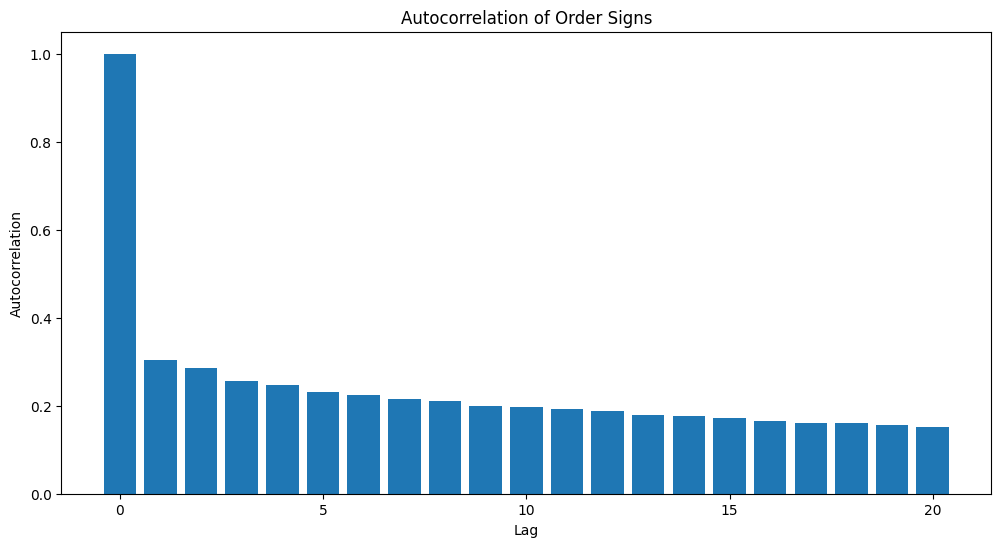

Autocorrelation of Order Signs:
Lag 0: Autocorrelation = 1.0000, Ljung-Box stat = 25034.6085, p-value = 0.0000
Lag 1: Autocorrelation = 0.3045, Ljung-Box stat = 47161.2881, p-value = 0.0000
Lag 2: Autocorrelation = 0.2863, Ljung-Box stat = 65009.3589, p-value = 0.0000
Lag 3: Autocorrelation = 0.2571, Ljung-Box stat = 81615.5064, p-value = 0.0000
Lag 4: Autocorrelation = 0.2480, Ljung-Box stat = 95990.9856, p-value = 0.0000
Lag 5: Autocorrelation = 0.2307, Ljung-Box stat = 109565.2883, p-value = 0.0000
Lag 6: Autocorrelation = 0.2242, Ljung-Box stat = 122203.0823, p-value = 0.0000
Lag 7: Autocorrelation = 0.2163, Ljung-Box stat = 134243.9347, p-value = 0.0000
Lag 8: Autocorrelation = 0.2112, Ljung-Box stat = 145084.6974, p-value = 0.0000
Lag 9: Autocorrelation = 0.2004, Ljung-Box stat = 155544.6866, p-value = 0.0000
Lag 10: Autocorrelation = 0.1968, Ljung-Box stat = 165465.5758, p-value = 0.0000
Lag 11: Autocorrelation = 0.1917, Ljung-Box stat = 174998.3409, p-value = 0.0000
Lag 12: Aut

In [16]:
def analyze_order_sign_autocorrelation(df, max_lag=20):
    # Ensure the DataFrame is sorted by date and time
    df = df.sort_values(['TRD_EXCTN_DT', 'TRD_EXCTN_TM'])
    
    # Calculate autocorrelation
    autocorr = acf(df['TRANSACTION_SIGN'], nlags=max_lag)
    
    # Perform Ljung-Box test for each lag
    lags = range(1, max_lag + 1)
    lb_results = acorr_ljungbox(df['TRANSACTION_SIGN'], lags=lags)
    
    # Plot autocorrelation
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(autocorr)), autocorr)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation of Order Signs')
    plt.show()
    
    # Print results
    print("Autocorrelation of Order Signs:")
    for lag, ac, lb_stat, p_value in zip(range(len(autocorr)), autocorr, lb_results.lb_stat, lb_results.lb_pvalue):
        print(f"Lag {lag}: Autocorrelation = {ac:.4f}, Ljung-Box stat = {lb_stat:.4f}, p-value = {p_value:.4f}")
    
    return autocorr, lb_results

# Usage
# Assuming 'df' is your DataFrame with the 'TRANSACTION_SIGN' column
autocorr, lb_results = analyze_order_sign_autocorrelation(df_transaction_sign)

- **Lag 1**: The autocorrelation is about 0.3, showing a positive but weaker relationship between successive trades.
- **Lags 2 to 10**: The autocorrelation decreases but remains positive, suggesting that order flow (buy/sell behavior) shows persistence over time, though it weakens with distance.
- **Beyond Lag 10**: The autocorrelation is low, indicating reduced dependence or predictability between trades as lag increases.
- The p-value is 0.0000 for all lags, meaning the autocorrelations are statistically significant at these lags. This indicates non-randomness in order signs over time.
- The trading behavior shows short-term persistence, as autocorrelation is high at smaller lags. This could reflect client trading strategies (e.g., splitting large orders) or patterns in market-making activity.
> To-do: Try extracting the number of responses received by an order?
> Ex. Correlation between number of responses for a price and bid-ask change

## TCA Framework

### 1. Bid-Ask spread calculation 

In [17]:
df_transaction_sign['TRANSACTION_SIGN'].value_counts()

TRANSACTION_SIGN
 0    114790
-1     92867
 1     62353
Name: count, dtype: int64

In [18]:
df_transaction_sign

CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
155264  037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
155265  037833AK6  AAPL4001809           AAPL   2023-03-28     11:05:13   
155266  037833AK6  AAPL4001809           AAPL   2023-03-28     11:27:33   
155267  037833AK6  AAPL4001809           AAPL   2023-03-28     12:38:13   
155268  037833AK6  AAPL4001809           AAPL   2023-03-28     14:20:37   
...           ...          ...            ...          ...          ...   
155261  037833EW6  AAPL5584758           AAPL   2024-03-28     11:30:22   
155262  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267844  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267845  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
155263  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   

        TRD_RPT_DT TRD_RPT_TM MSG_SEQ_NB TRC_ST SCRTY_TYPE_CD  ...  \
155264  2023-03-28   10:20:21    0024007      T          None  ...   
155265  2023-03-28   11:05:33    0044879      T          None  ...   
155266  2023-03-28   11:27:43    0051096      T          None  ...   
155267  2023-03-28   12:38:13    0076016      T          None  ...   
155268  2023-03-28   14:20:59    0116572      T          None  ...   
...            ...        ...        ...    ...           ...  ...   
155261  2024-03-28   11:30:49    0076970      T          None  ...   
155262  2024-03-28   12:32:51    0107020      T          None  ...   
267844  2024-03-28   12:32:51    0107022      T          None  ...   
267845  2024-03-28   12:34:23    0107684      T          None  ...   
155263  2024-03-28   13:46:01    0159086      T          None  ...   

       LCKD_IN_IND ATS_INDICATOR  PR_TRD_DT  FIRST_TRADE_CTRL_DATE  \
155264        None          None       None             2023-03-28   
155265        None          None       None             2023-03-28   
155266        None             Y       None             2023-03-28   
155267        None          None       None             2023-03-28   
155268        None          None       None             2023-03-28   
...            ...           ...        ...                    ...   
155261        None          None       None             2024-03-28   
155262        None          None       None             2024-03-28   
267844           Y          None       None             2024-03-28   
267845        None             Y       None             2024-03-28   
155263        None          None       None             2024-03-28   

       FIRST_TRADE_CTRL_NUM  ORIG_MSG_SEQ_NB_Y RPT_SIDE_CD_x SIZE_RUN  \
155264              0024007                NaN           NaN        2   
155265              0044879                NaN           NaN        5   
155266              0051096                NaN           NaN       10   
155267              0076016                NaN           NaN       15   
155268              0116572                NaN           NaN       16   
...                     ...                ...           ...      ...   
155261              0076970                NaN           NaN   164257   
155262              0107020                NaN           NaN   164258   
267844              0107022                NaN           NaN   164258   
267845              0107684                NaN           NaN   164258   
155263              0159086                NaN           NaN   164259   

       POTENTIAL_RPT TRANSACTION_SIGN  
155264         False                0  
155265         False                0  
155266         False                0  
155267         False                0  
155268         False                0  
...              ...              ...  
155261         False                1  
155262         False               -1  
267844         False                0  
267845         False                0  
155263         False               -1  

[270010 rows x 46 columns]

Bid-Ask Spread Estimate Statistics (Absolute):
count    26371.000000
mean        -0.178845
std          0.366814
min         -4.000000
25%         -0.162000
50%         -0.080000
75%         -0.005000
max          1.441952
Name: SPREAD_ESTIMATE, dtype: float64

Mid-Price Estimate Statistics:
count    26371.000000
mean        91.926233
std          9.389992
min         54.027000
25%         88.403000
50%         95.756500
75%         98.162750
max        104.565500
Name: MID_PRICE, dtype: float64

Bid-Ask Spread Estimate Statistics (Basis Points):
count    26371.000000
mean       -19.899889
std         41.481521
min       -478.212508
25%        -17.807620
50%         -8.891335
75%         -0.538294
max        178.365534
Name: SPREAD_BPS, dtype: float64

Average Spread (BPS) by CUSIP (TOP 10):
CUSIP_ID
037833DV9    -2.858473
037833AK6    -5.327845
037833EB2    -7.651511
037833DB3    -7.981422
037833DX5    -8.695283
037833EK2    -9.196646
037833DT4    -9.213532
037833CU2    -9.960938
0378

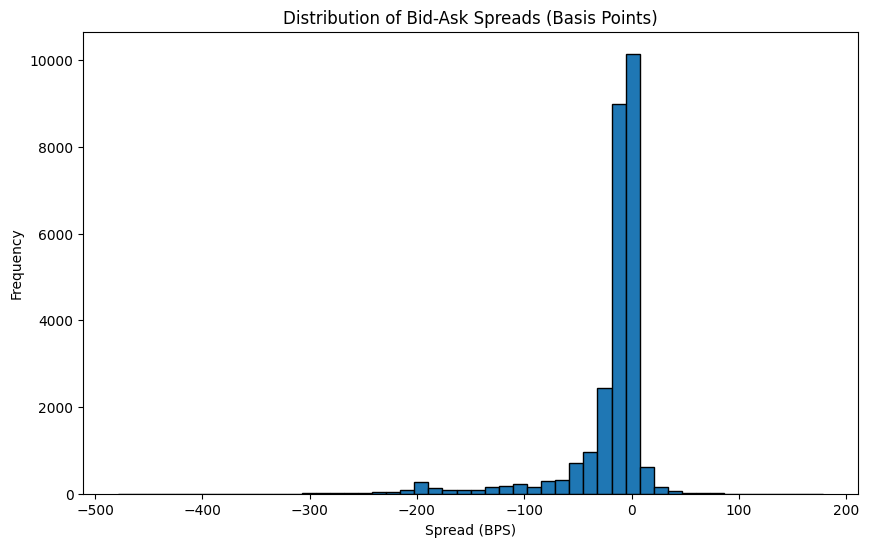

In [19]:
def estimate_spread_and_midprice(df, time_threshold):
    """
    Estimate bid-ask spread and mid-price for consecutive trades with opposite signs.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing trade data
    time_threshold (float): Maximum time difference (in seconds) between consecutive trades
    
    Returns:
    pd.DataFrame: DataFrame with estimated spread and mid-price
    """
    # Ensure the DataFrame is sorted by date and time
    df = df.sort_values(['CUSIP_ID', 'TRD_EXCTN_DT', 'TRD_EXCTN_TM'])
    
    # Convert execution time to datetime
    df['TRD_EXCTN_DATETIME'] = pd.to_datetime(df['TRD_EXCTN_DT'].astype(str) + ' ' + df['TRD_EXCTN_TM'].astype(str))
    
    # Calculate time difference and sign change between consecutive trades
    df['TIME_DIFF'] = df.groupby('CUSIP_ID')['TRD_EXCTN_DATETIME'].diff().dt.total_seconds()
    df['SIGN_CHANGE'] = df.groupby('CUSIP_ID')['TRANSACTION_SIGN'].diff()
    
    # Identify pairs of trades with opposite signs and within time threshold
    mask = (df['SIGN_CHANGE'] != 0) & (df['TIME_DIFF'] < time_threshold) & (df['TRANSACTION_SIGN'] != 0)
    
    # Calculate bid-ask spread estimate
    df.loc[mask, 'SPREAD_ESTIMATE'] = (df['RPTD_PR'] - df['RPTD_PR'].shift()) * df['TRANSACTION_SIGN']
    
    # Calculate mid-price estimate
    df.loc[mask, 'MID_PRICE'] = df['RPTD_PR'] - df['TRANSACTION_SIGN'] * df['SPREAD_ESTIMATE'] / 2

    # Calculate bid-ask spread in basis points
    df.loc[mask, 'SPREAD_BPS'] = (df['SPREAD_ESTIMATE'] / df['MID_PRICE']) * 10000
    
    return df

# Analysis of results
def analyze_estimates(df):
    """
    Analyze the estimated spread, mid-price, and spread in basis points.
    """
    spread_stats = df['SPREAD_ESTIMATE'].describe()
    midprice_stats = df['MID_PRICE'].describe()
    spread_bps_stats = df['SPREAD_BPS'].describe()
    
    print("Bid-Ask Spread Estimate Statistics (Absolute):")
    print(spread_stats)
    print("\nMid-Price Estimate Statistics:")
    print(midprice_stats)
    print("\nBid-Ask Spread Estimate Statistics (Basis Points):")
    print(spread_bps_stats)
    
    # Additional analysis: Average spread by CUSIP
    avg_spread_by_cusip = df.groupby('CUSIP_ID')['SPREAD_BPS'].mean().sort_values(ascending=False)
    print("\nAverage Spread (BPS) by CUSIP (TOP 10):")
    print(avg_spread_by_cusip.head(10))
    
    # Plotting the distribution of spreads in basis points
    plt.figure(figsize=(10, 6))
    plt.hist(df['SPREAD_BPS'].dropna(), bins=50, edgecolor='black')
    plt.title('Distribution of Bid-Ask Spreads (Basis Points)')
    plt.xlabel('Spread (BPS)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Personal Note: 
    # You can add more analysis here, such as plotting distributions, 
    # calculating averages per CUSIP, etc.

time_threshold = 300  # 5 minutes in seconds
result_df = estimate_spread_and_midprice(df_transaction_sign, time_threshold)
analyze_estimates(result_df)


- Basis Spread is negatively skewed (long left tail)
    - we can deviate into the study of spreads at different events ex: earnings announcements, merger & acquisitions, corporate events (change in management, new product line) and test it against the hypothesis of how it shapes assymetric information
    - spreads will most likely increase pre-aanouncement (high information assymmetry) -> we can dvelve into the statistics of that too
      - Indication of monopolistic nature (maybe?) cause if they do increase then it might mean market maker can lose this power
    - Can also do a cross-sectional determination/decomposition of spreads


In [22]:
result_df

CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
155264  037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
155265  037833AK6  AAPL4001809           AAPL   2023-03-28     11:05:13   
155266  037833AK6  AAPL4001809           AAPL   2023-03-28     11:27:33   
155267  037833AK6  AAPL4001809           AAPL   2023-03-28     12:38:13   
155268  037833AK6  AAPL4001809           AAPL   2023-03-28     14:20:37   
...           ...          ...            ...          ...          ...   
155261  037833EW6  AAPL5584758           AAPL   2024-03-28     11:30:22   
155262  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267844  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267845  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
155263  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   

        TRD_RPT_DT TRD_RPT_TM MSG_SEQ_NB TRC_ST SCRTY_TYPE_CD  ...  \
155264  2023-03-28   10:20:21    0024007      T          None  ...   
155265  2023-03-28   11:05:33    0044879      T          None  ...   
155266  2023-03-28   11:27:43    0051096      T          None  ...   
155267  2023-03-28   12:38:13    0076016      T          None  ...   
155268  2023-03-28   14:20:59    0116572      T          None  ...   
...            ...        ...        ...    ...           ...  ...   
155261  2024-03-28   11:30:49    0076970      T          None  ...   
155262  2024-03-28   12:32:51    0107020      T          None  ...   
267844  2024-03-28   12:32:51    0107022      T          None  ...   
267845  2024-03-28   12:34:23    0107684      T          None  ...   
155263  2024-03-28   13:46:01    0159086      T          None  ...   

       RPT_SIDE_CD_x SIZE_RUN  POTENTIAL_RPT  TRANSACTION_SIGN  \
155264           NaN        2          False                 0   
155265           NaN        5          False                 0   
155266           NaN       10          False                 0   
155267           NaN       15          False                 0   
155268           NaN       16          False                 0   
...              ...      ...            ...               ...   
155261           NaN   164257          False                 1   
155262           NaN   164258          False                -1   
267844           NaN   164258          False                 0   
267845           NaN   164258          False                 0   
155263           NaN   164259          False                -1   

        TRD_EXCTN_DATETIME  TIME_DIFF SIGN_CHANGE SPREAD_ESTIMATE MID_PRICE  \
155264 2023-03-28 10:20:13        NaN         NaN             NaN       NaN   
155265 2023-03-28 11:05:13     2700.0         0.0             NaN       NaN   
155266 2023-03-28 11:27:33     1340.0         0.0             NaN       NaN   
155267 2023-03-28 12:38:13     4240.0         0.0             NaN       NaN   
155268 2023-03-28 14:20:37     6144.0         0.0             NaN       NaN   
...                    ...        ...         ...             ...       ...   
155261 2024-03-28 11:30:22      267.0         1.0          -0.349   99.4245   
155262 2024-03-28 12:32:34     3732.0        -2.0             NaN       NaN   
267844 2024-03-28 12:32:34        0.0         1.0             NaN       NaN   
267845 2024-03-28 12:32:34        0.0         0.0             NaN       NaN   
155263 2024-03-28 13:45:51     4397.0        -1.0             NaN       NaN   

       SPREAD_BPS  
155264        NaN  
155265        NaN  
155266        NaN  
155267        NaN  
155268        NaN  
...           ...  
155261 -35.102012  
155262        NaN  
267844        NaN  
267845        NaN  
155263        NaN  

[270010 rows x 52 columns]

In [50]:
result_temp_df = result_df[['CUSIP_ID','BOND_SYM_ID','COMPANY_SYMBOL','TRD_EXCTN_DT',
                            'TRD_EXCTN_TM', 'TRD_EXCTN_DATETIME', 'SPREAD_ESTIMATE', 
                            'MID_PRICE', 'SPREAD_BPS','ENTRD_VOL_QT', 'RPTD_PR',
                            'YLD_SIGN_CD', 'YLD_PT', 'RPT_SIDE_CD','BUY_CPCTY_CD',
                            'SELL_CPCTY_CD', 'CNTRA_MP_ID',]]
result_temp_df

CUSIP_ID  BOND_SYM_ID COMPANY_SYMBOL TRD_EXCTN_DT TRD_EXCTN_TM  \
155264  037833AK6  AAPL4001809           AAPL   2023-03-28     10:20:13   
155265  037833AK6  AAPL4001809           AAPL   2023-03-28     11:05:13   
155266  037833AK6  AAPL4001809           AAPL   2023-03-28     11:27:33   
155267  037833AK6  AAPL4001809           AAPL   2023-03-28     12:38:13   
155268  037833AK6  AAPL4001809           AAPL   2023-03-28     14:20:37   
...           ...          ...            ...          ...          ...   
155261  037833EW6  AAPL5584758           AAPL   2024-03-28     11:30:22   
155262  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267844  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
267845  037833EW6  AAPL5584758           AAPL   2024-03-28     12:32:34   
155263  037833EW6  AAPL5584758           AAPL   2024-03-28     13:45:51   

        TRD_EXCTN_DATETIME  SPREAD_ESTIMATE  MID_PRICE  SPREAD_BPS  \
155264 2023-03-28 10:20:13              NaN        NaN         NaN   
155265 2023-03-28 11:05:13              NaN        NaN         NaN   
155266 2023-03-28 11:27:33              NaN        NaN         NaN   
155267 2023-03-28 12:38:13              NaN        NaN         NaN   
155268 2023-03-28 14:20:37              NaN        NaN         NaN   
...                    ...              ...        ...         ...   
155261 2024-03-28 11:30:22           -0.349    99.4245  -35.102012   
155262 2024-03-28 12:32:34              NaN        NaN         NaN   
267844 2024-03-28 12:32:34              NaN        NaN         NaN   
267845 2024-03-28 12:32:34              NaN        NaN         NaN   
155263 2024-03-28 13:45:51              NaN        NaN         NaN   

        ENTRD_VOL_QT  RPTD_PR YLD_SIGN_CD    YLD_PT RPT_SIDE_CD BUY_CPCTY_CD  \
155264        2000.0   99.756        None  5.024835           S         None   
155265       10000.0   99.734        None  5.264232           S         None   
155266        7000.0   99.905        None  3.406219           S         None   
155267        6000.0   99.756        None  5.024835           S         None   
155268        5000.0   99.632        None  6.375527           S         None   
...              ...      ...         ...       ...         ...          ...   
155261      150000.0   99.250        None  4.898310           B            P   
155262       30000.0  100.132        None  4.841113           S         None   
267844       30000.0  100.032        None  4.847605           S            P   
267845       30000.0  100.032        None  4.847605           S         None   
155263       16000.0   99.593        None  4.876007           S         None   

       SELL_CPCTY_CD CNTRA_MP_ID  
155264             A           D  
155265             A           D  
155266             P           D  
155267             P           D  
155268             A           D  
...              ...         ...  
155261          None           C  
155262             P           C  
267844             P           D  
267845             P           D  
155263             P           C  

[270010 rows x 17 columns]

In [53]:
# Assuming your DataFrame is named 'df'
# First, let's fill NaN values in the specified columns
columns_to_fill = ['CUSIP_ID', 'TRD_EXCTN_DATETIME','MID_PRICE', 'SPREAD_ESTIMATE', 'SPREAD_BPS']
result_temp_df2 = result_temp_df[columns_to_fill].groupby('CUSIP_ID')[columns_to_fill].apply(lambda x: x.ffill().bfill())
result_temp_df2 = result_temp_df2.reset_index(drop=True)
result_temp_df2

CUSIP_ID  TRD_EXCTN_DATETIME  MID_PRICE  SPREAD_ESTIMATE  SPREAD_BPS
0       037833AK6 2023-03-28 10:20:13    99.5770           -0.200  -20.084959
1       037833AK6 2023-03-28 11:05:13    99.5770           -0.200  -20.084959
2       037833AK6 2023-03-28 11:27:33    99.5770           -0.200  -20.084959
3       037833AK6 2023-03-28 12:38:13    99.5770           -0.200  -20.084959
4       037833AK6 2023-03-28 14:20:37    99.5770           -0.200  -20.084959
...           ...                 ...        ...              ...         ...
270005  037833EW6 2024-03-28 11:30:22    99.4245           -0.349  -35.102012
270006  037833EW6 2024-03-28 12:32:34    99.4245           -0.349  -35.102012
270007  037833EW6 2024-03-28 12:32:34    99.4245           -0.349  -35.102012
270008  037833EW6 2024-03-28 12:32:34    99.4245           -0.349  -35.102012
270009  037833EW6 2024-03-28 13:45:51    99.4245           -0.349  -35.102012

[270010 rows x 5 columns]

In [56]:
unique_cusips = result_temp_df2['CUSIP_ID'].nunique()
print(f"Number of unique CUSIPs: {unique_cusips}")

Number of unique CUSIPs: 55


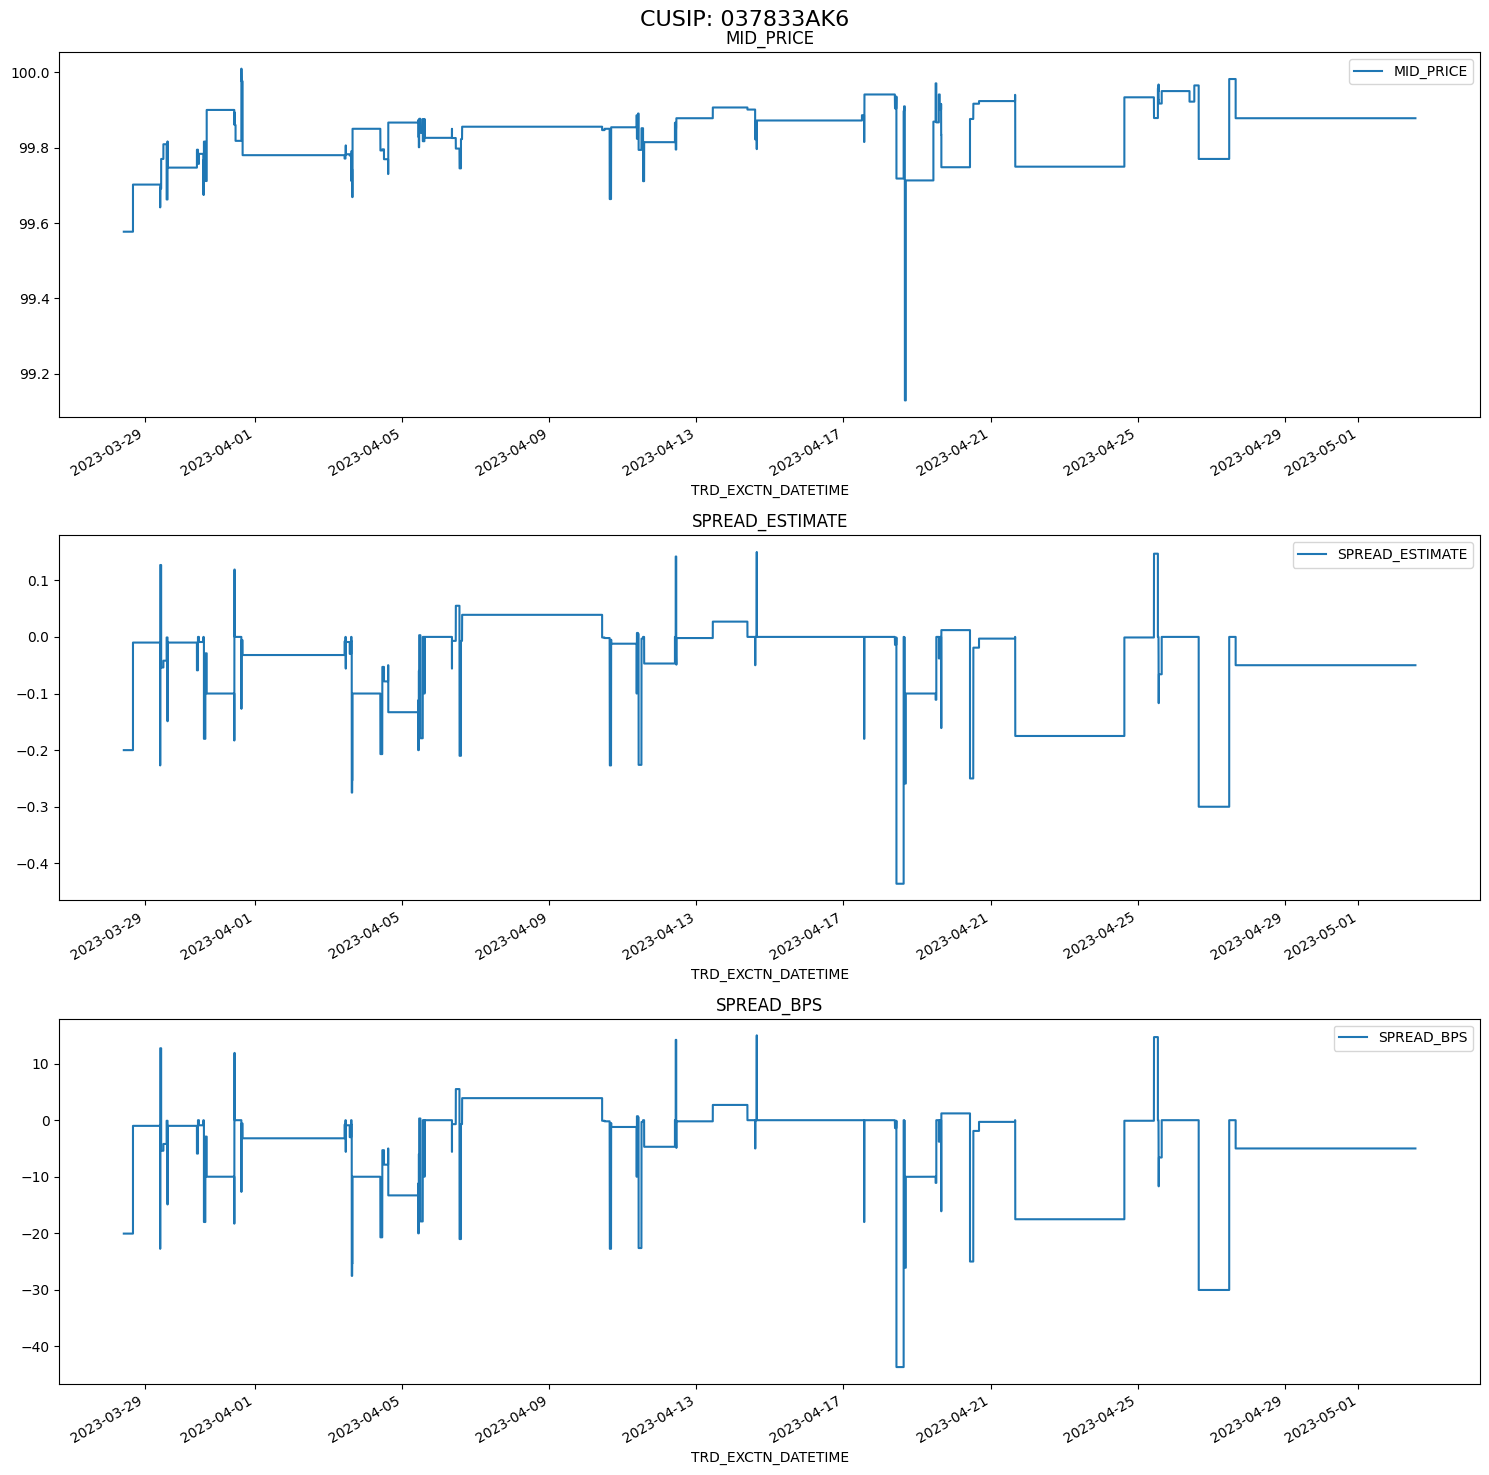

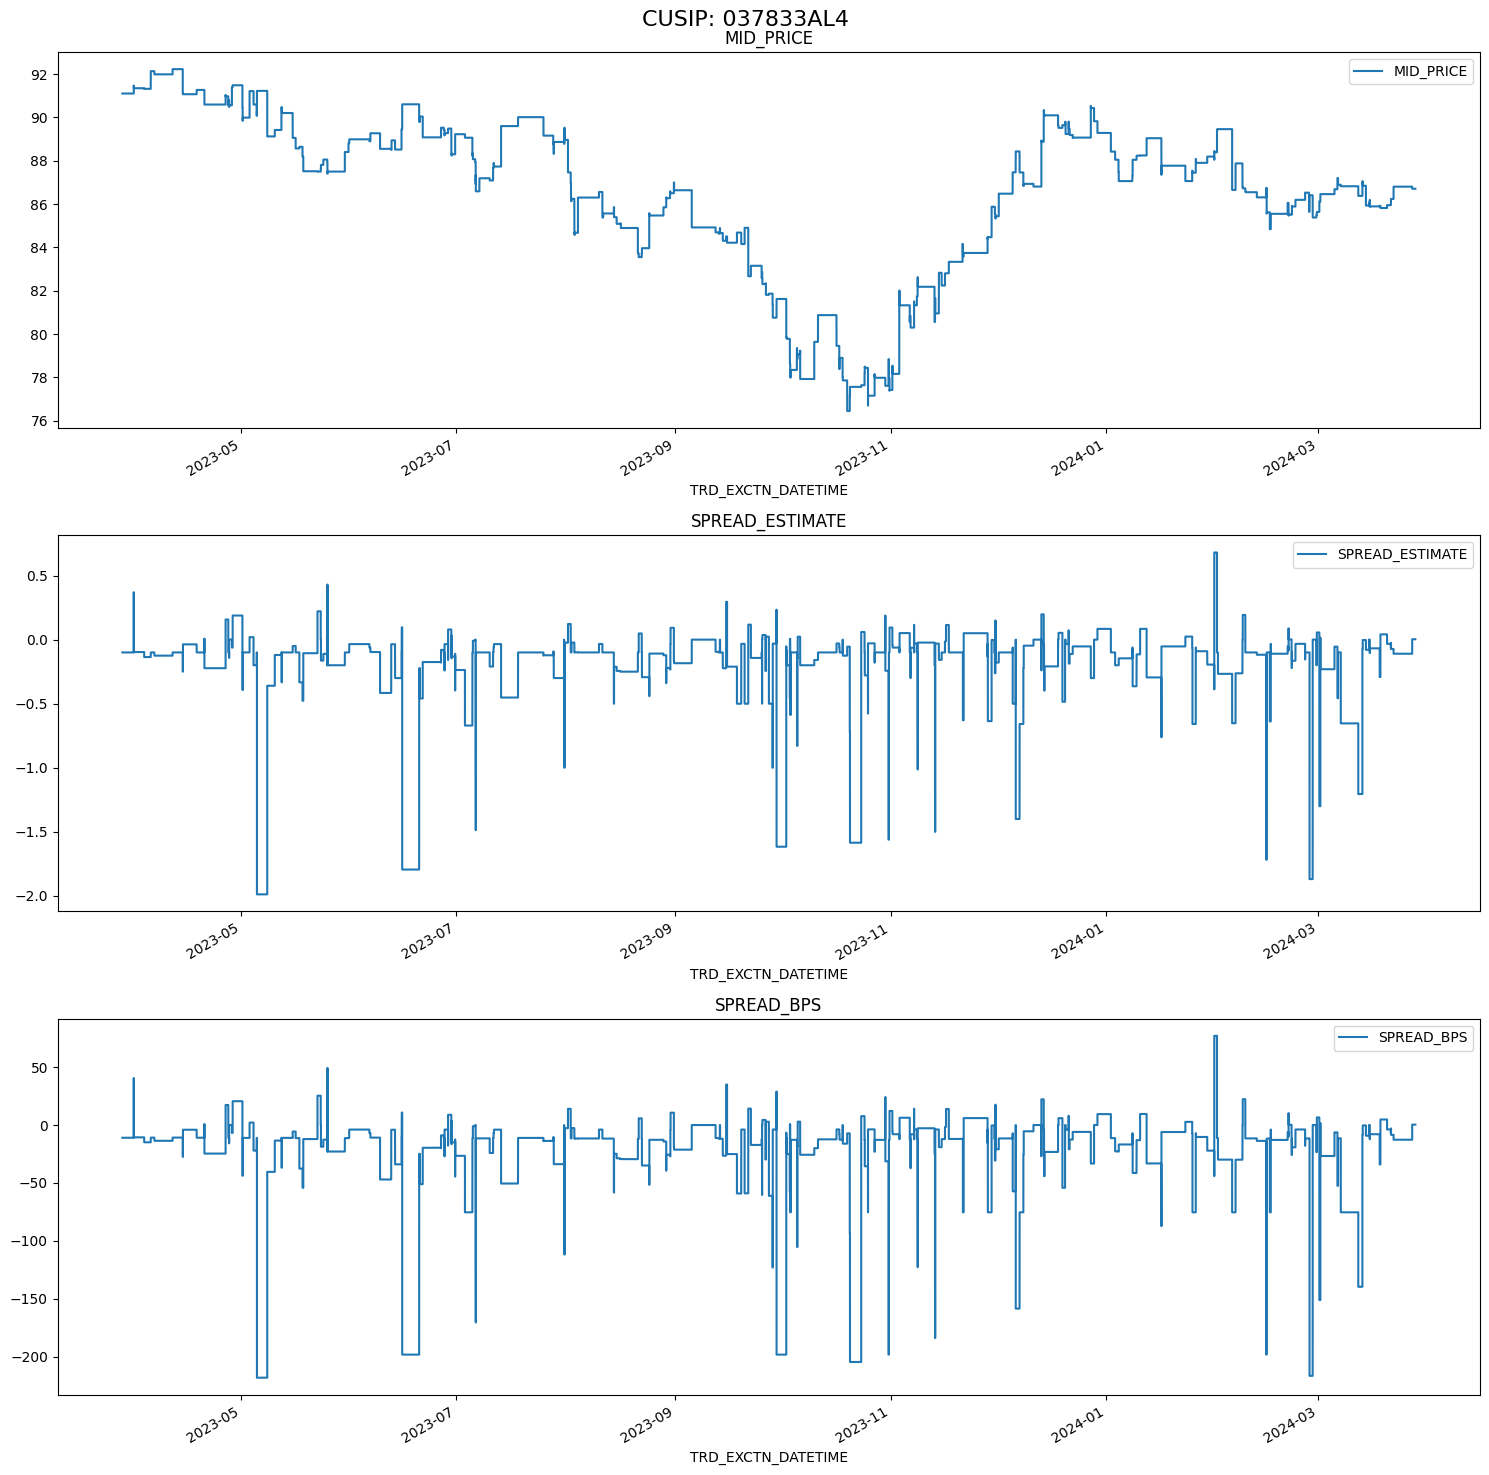

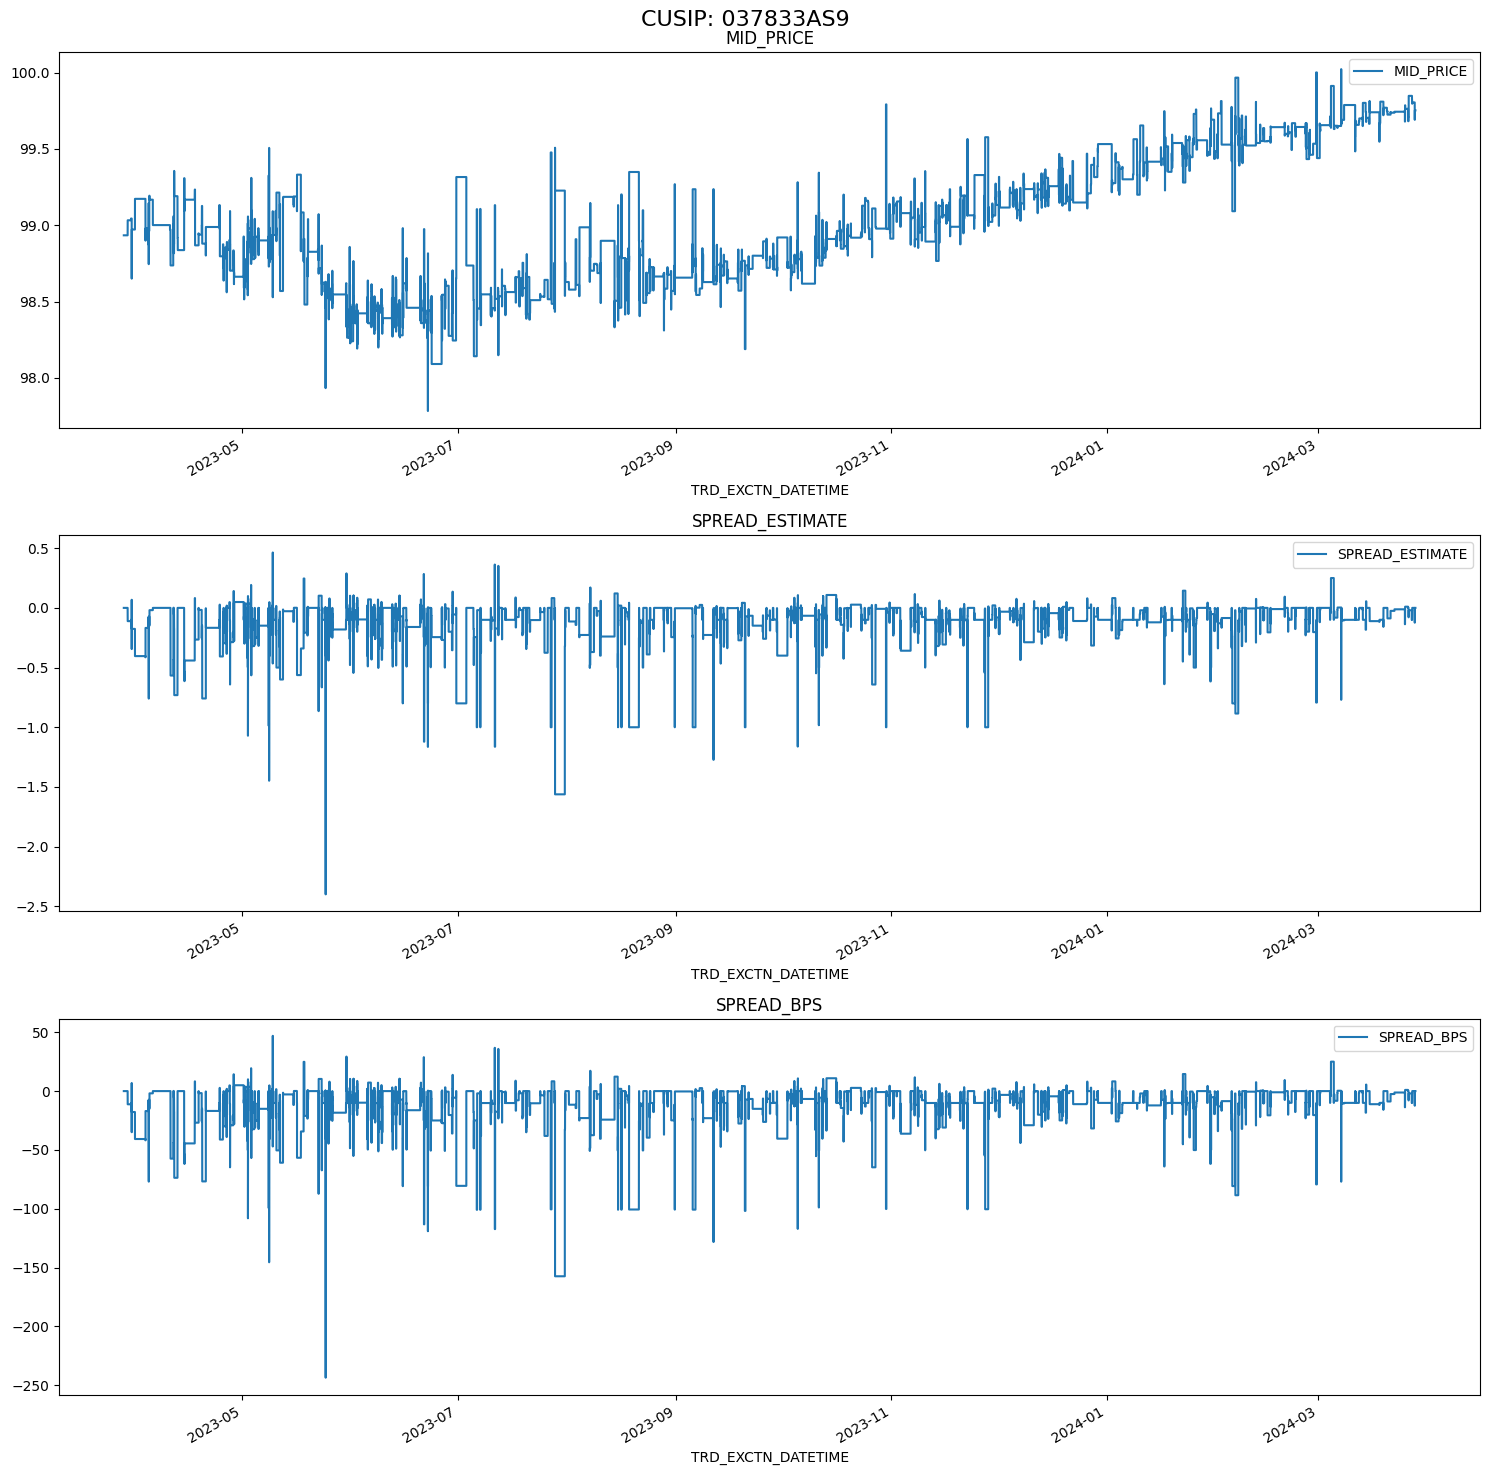

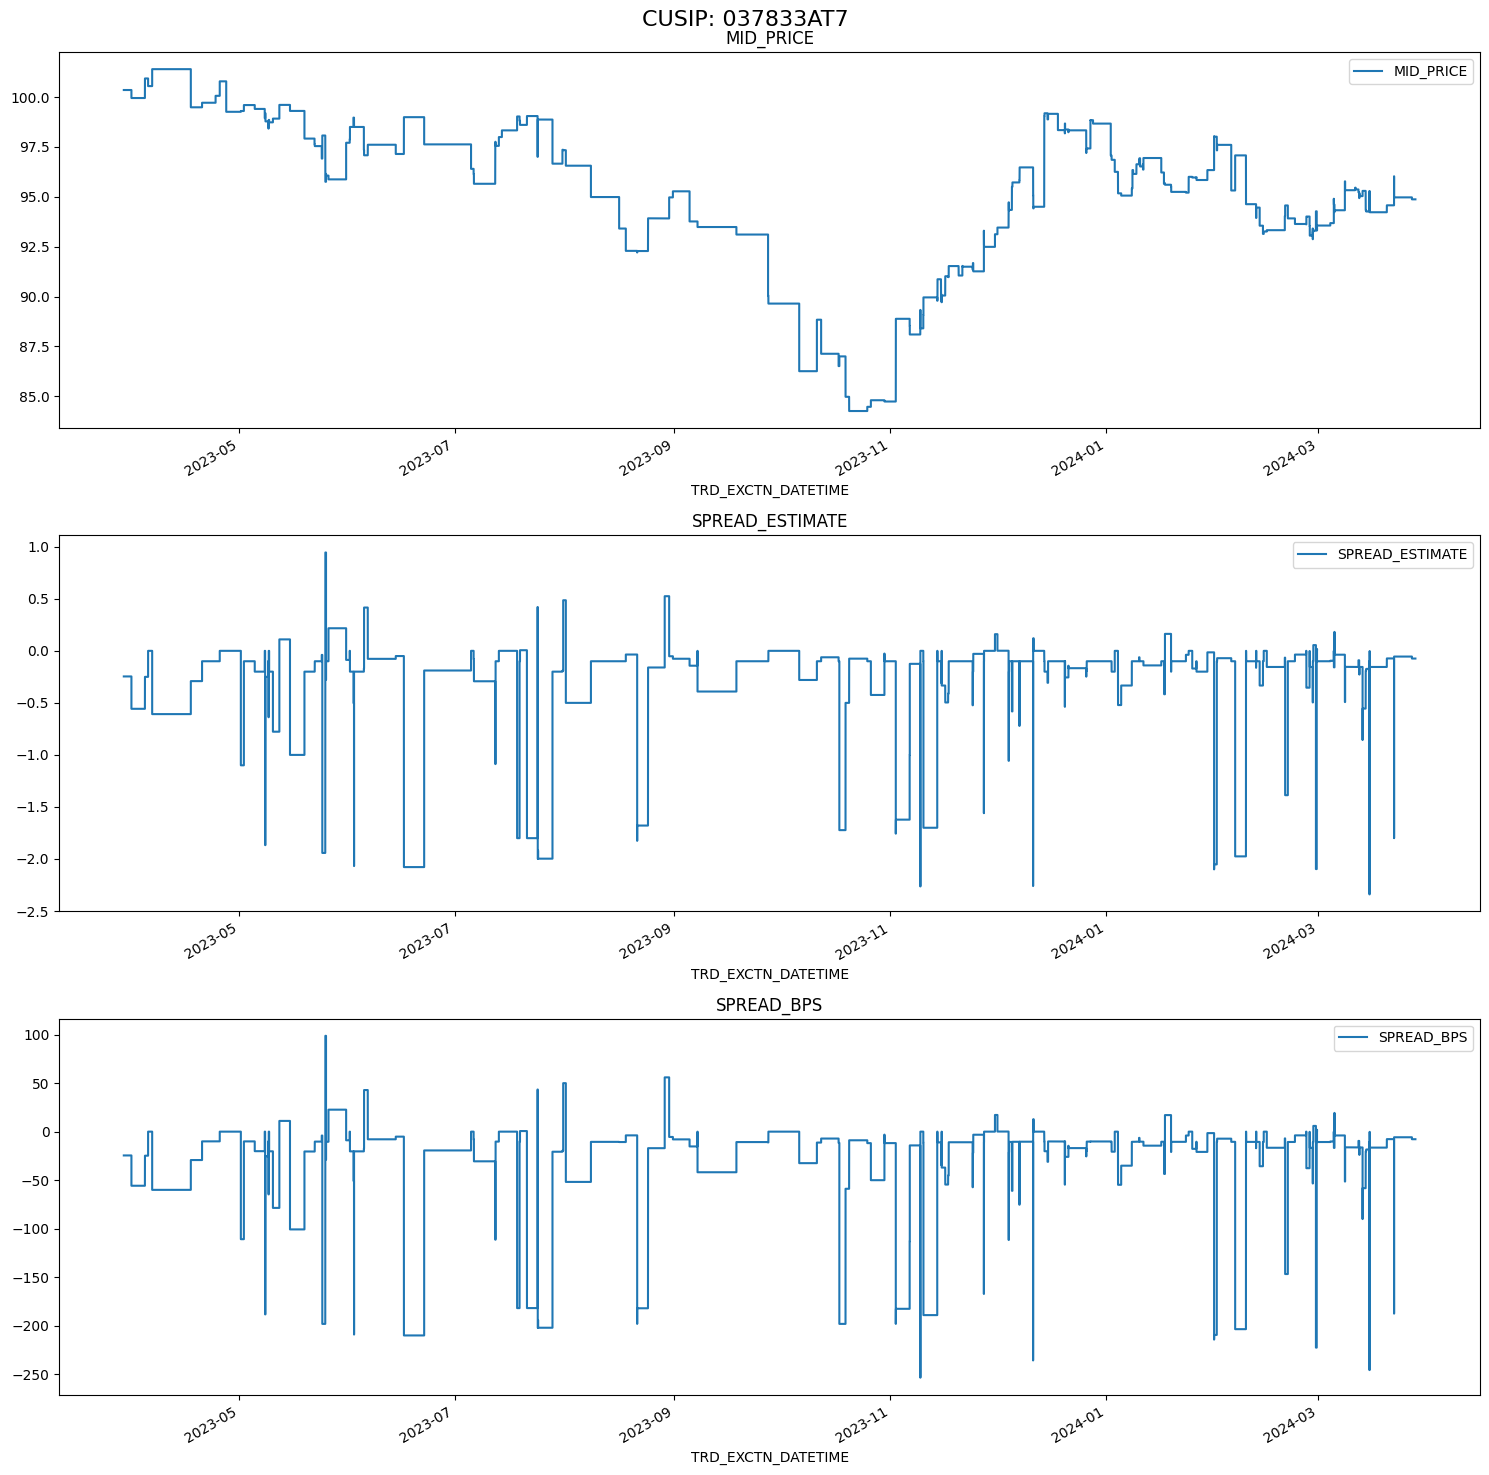

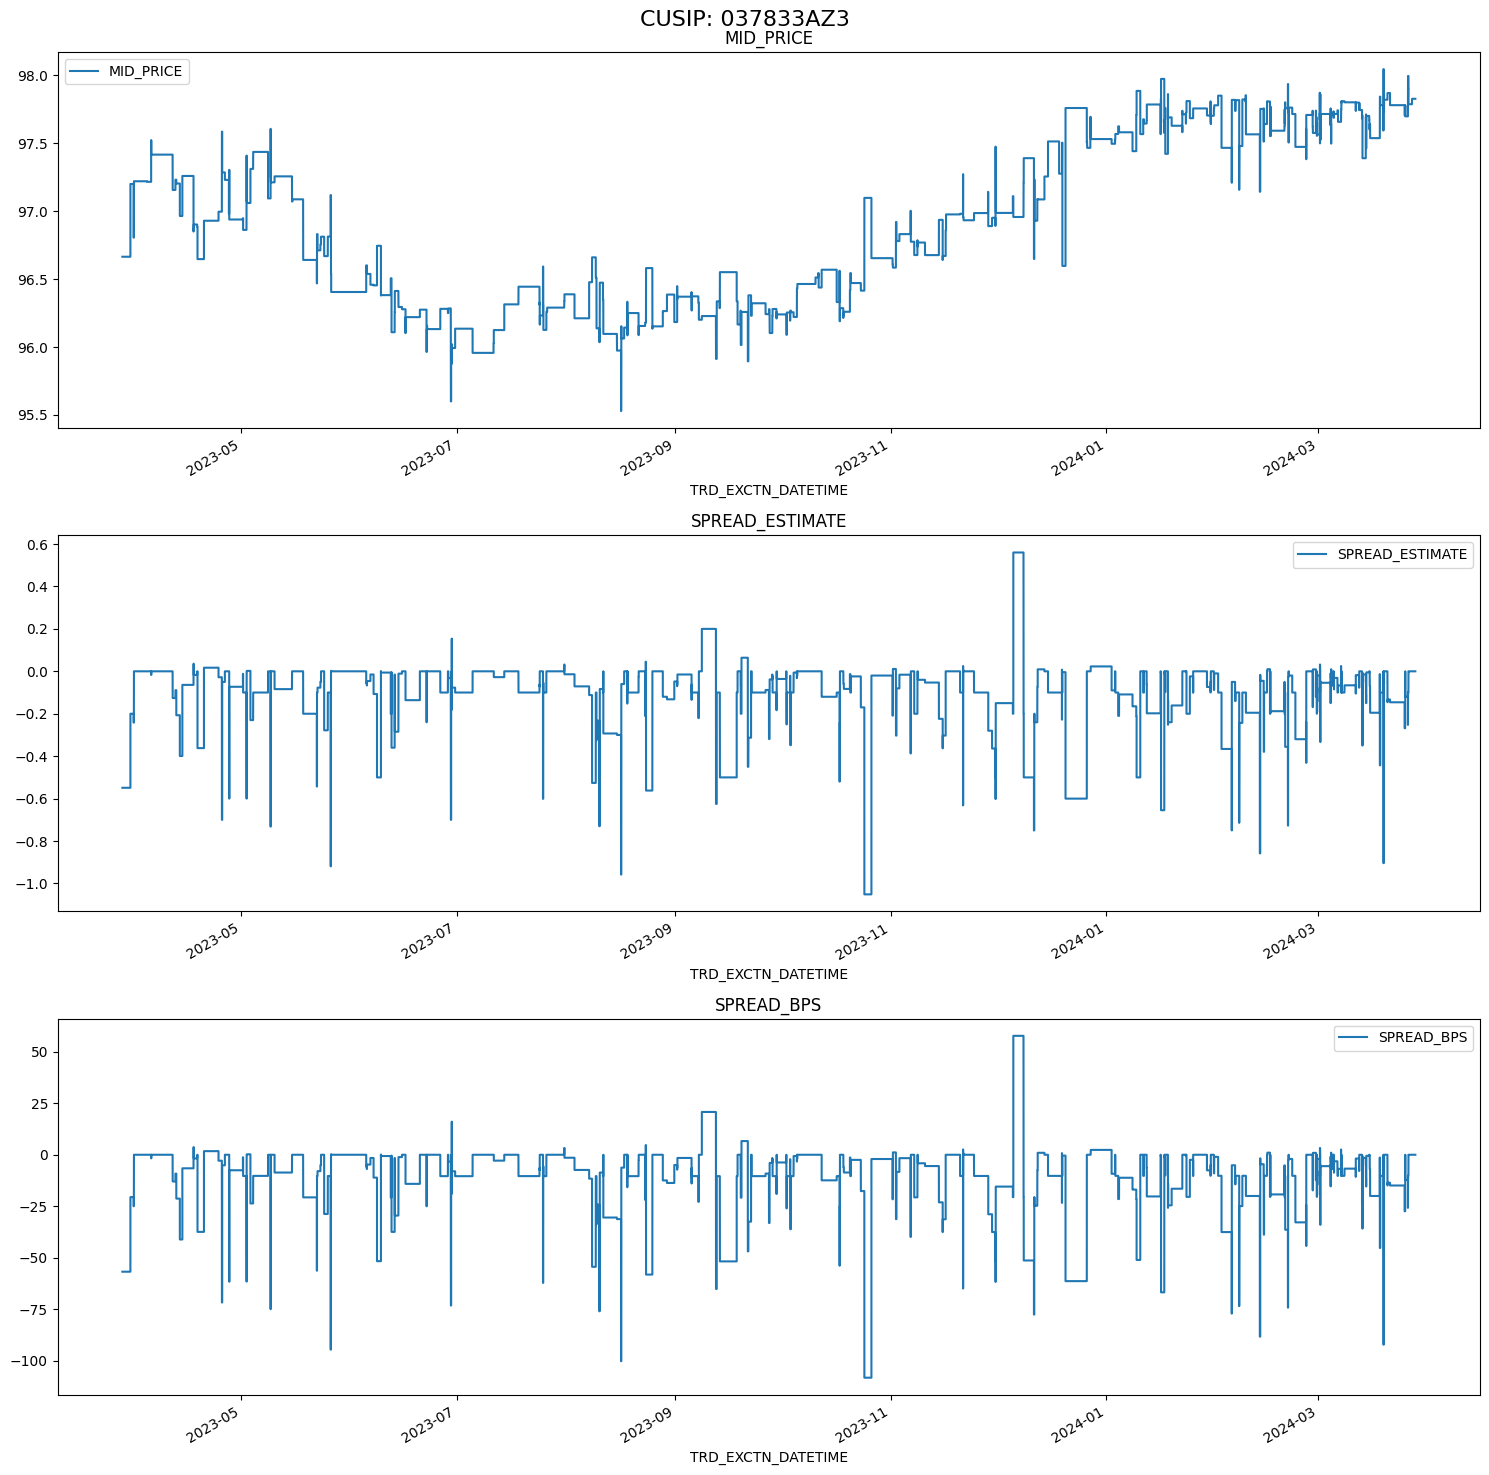

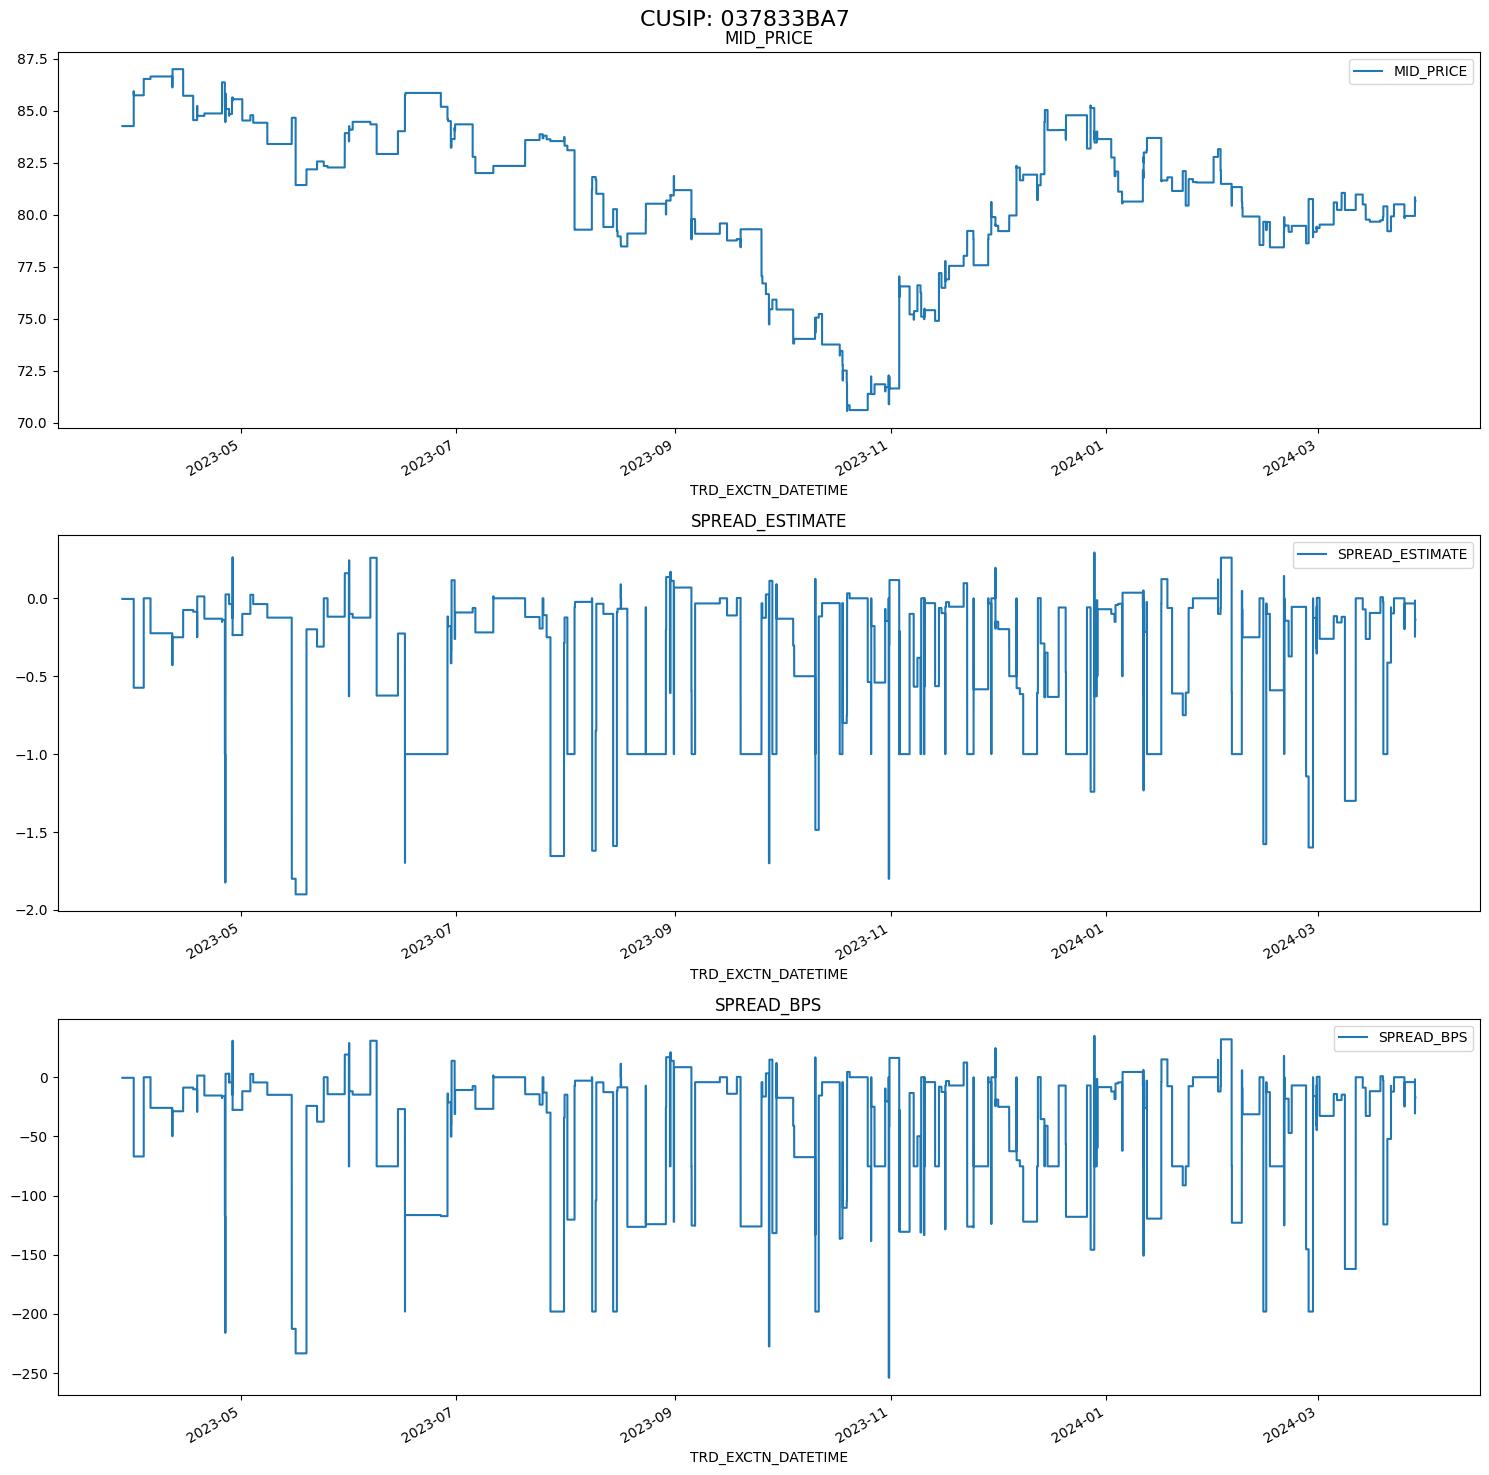

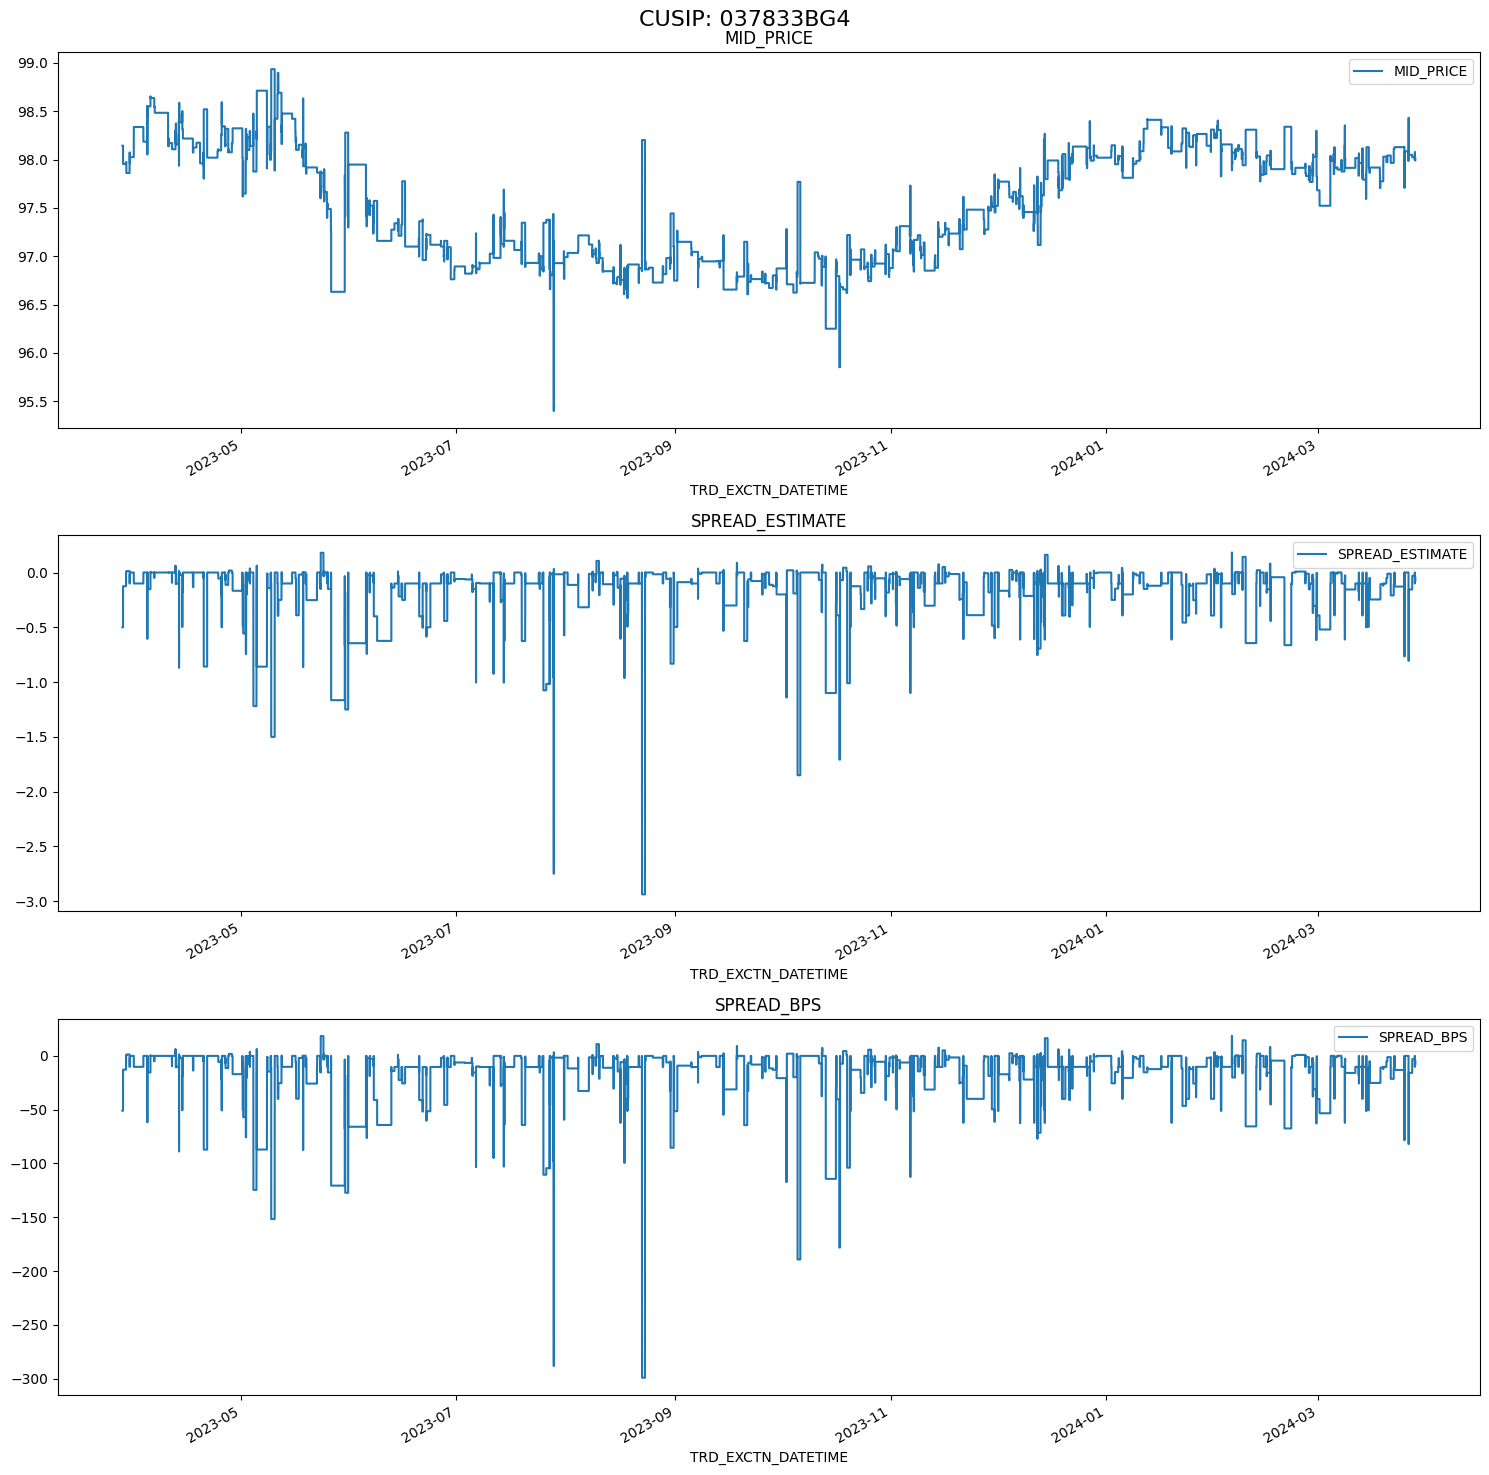

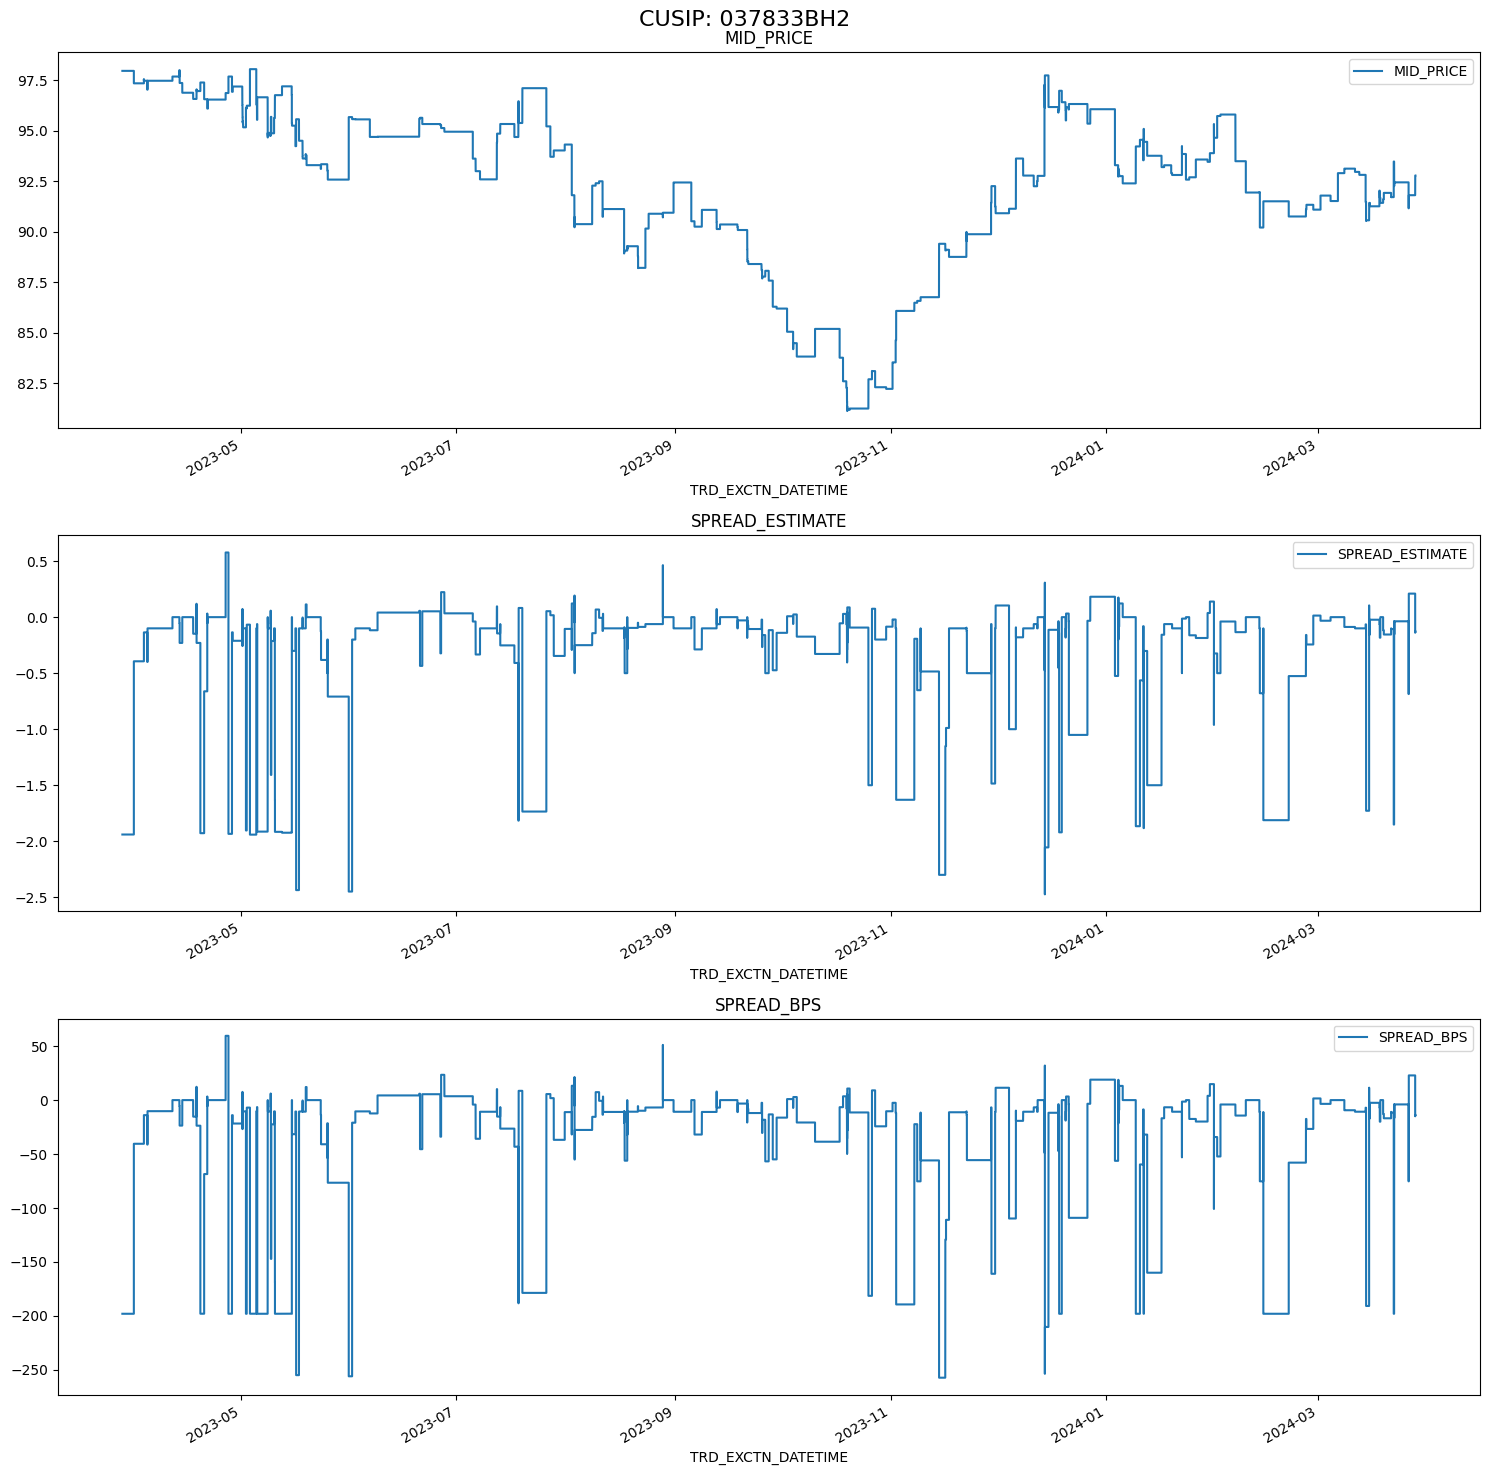

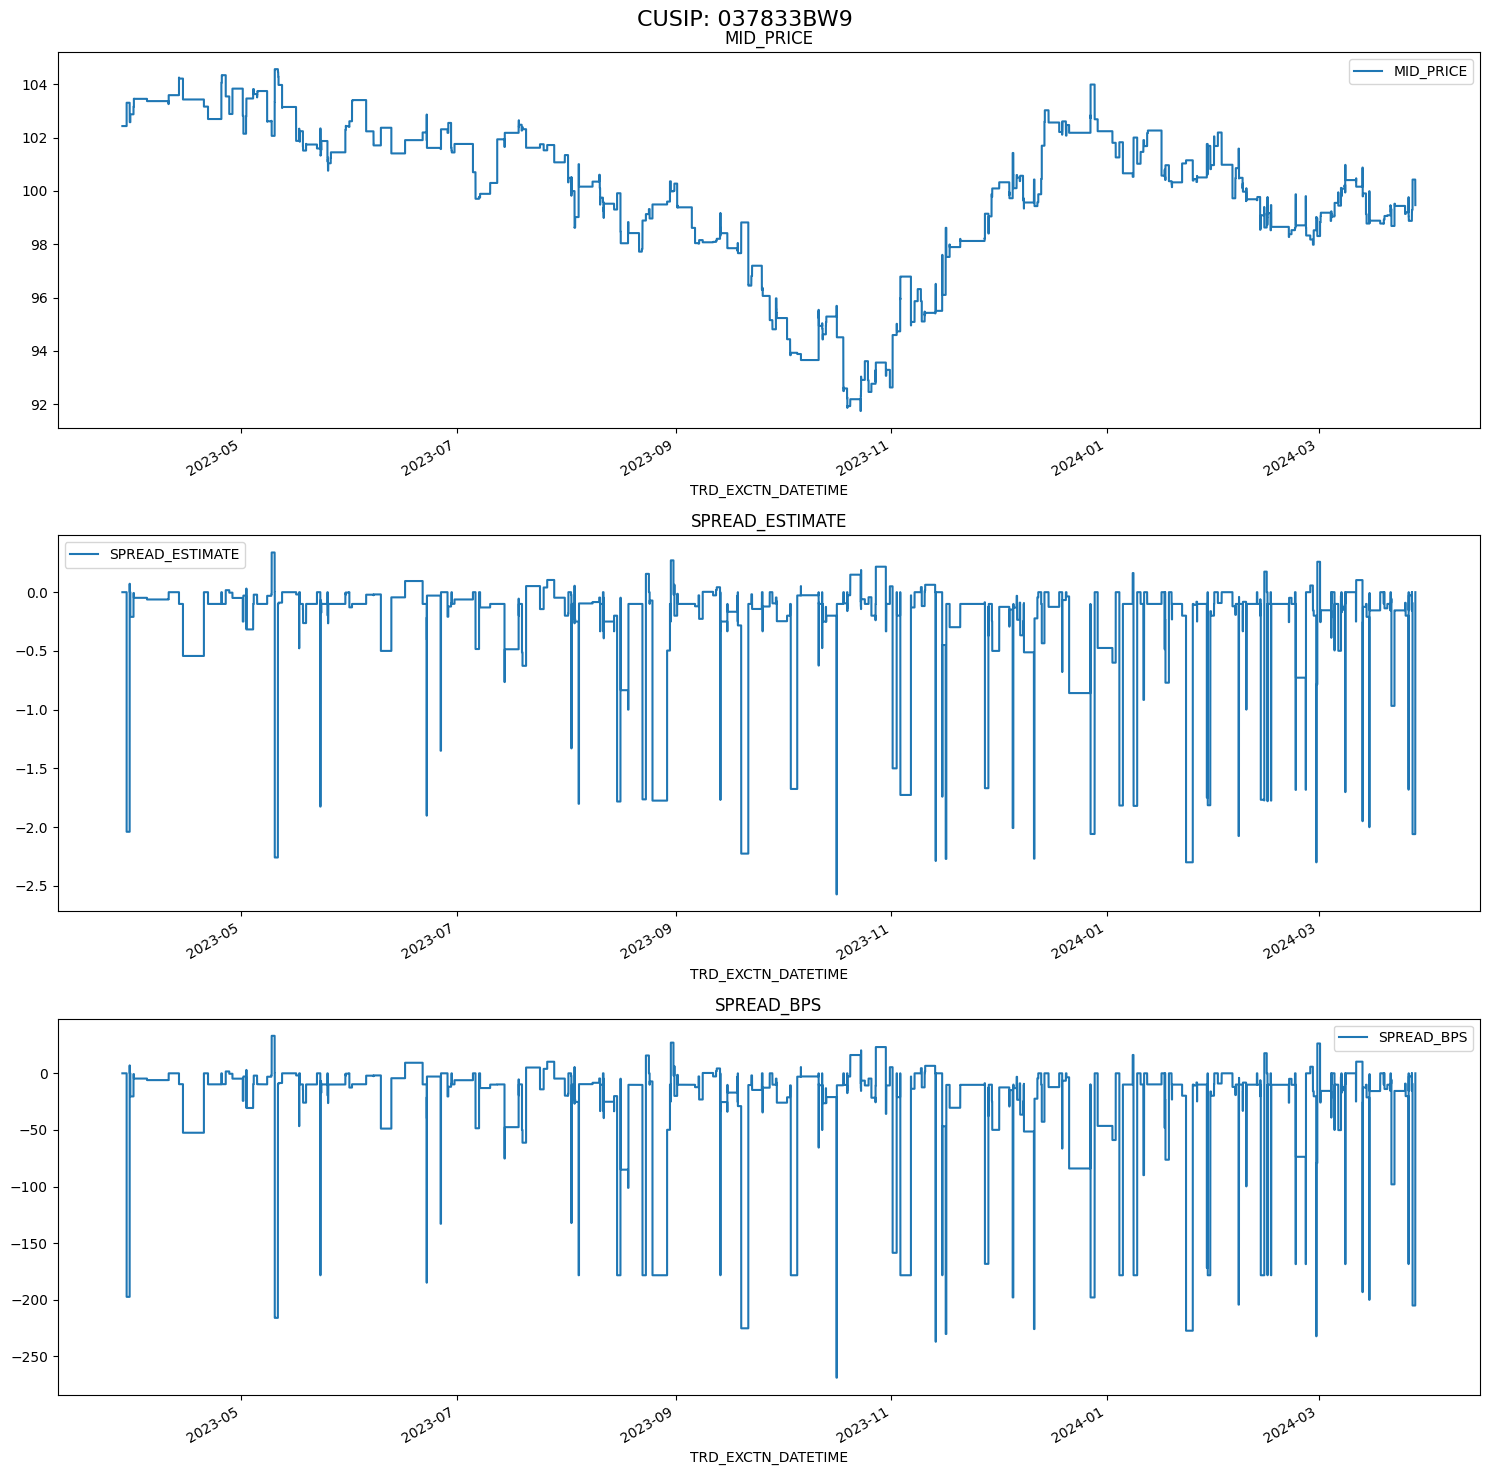

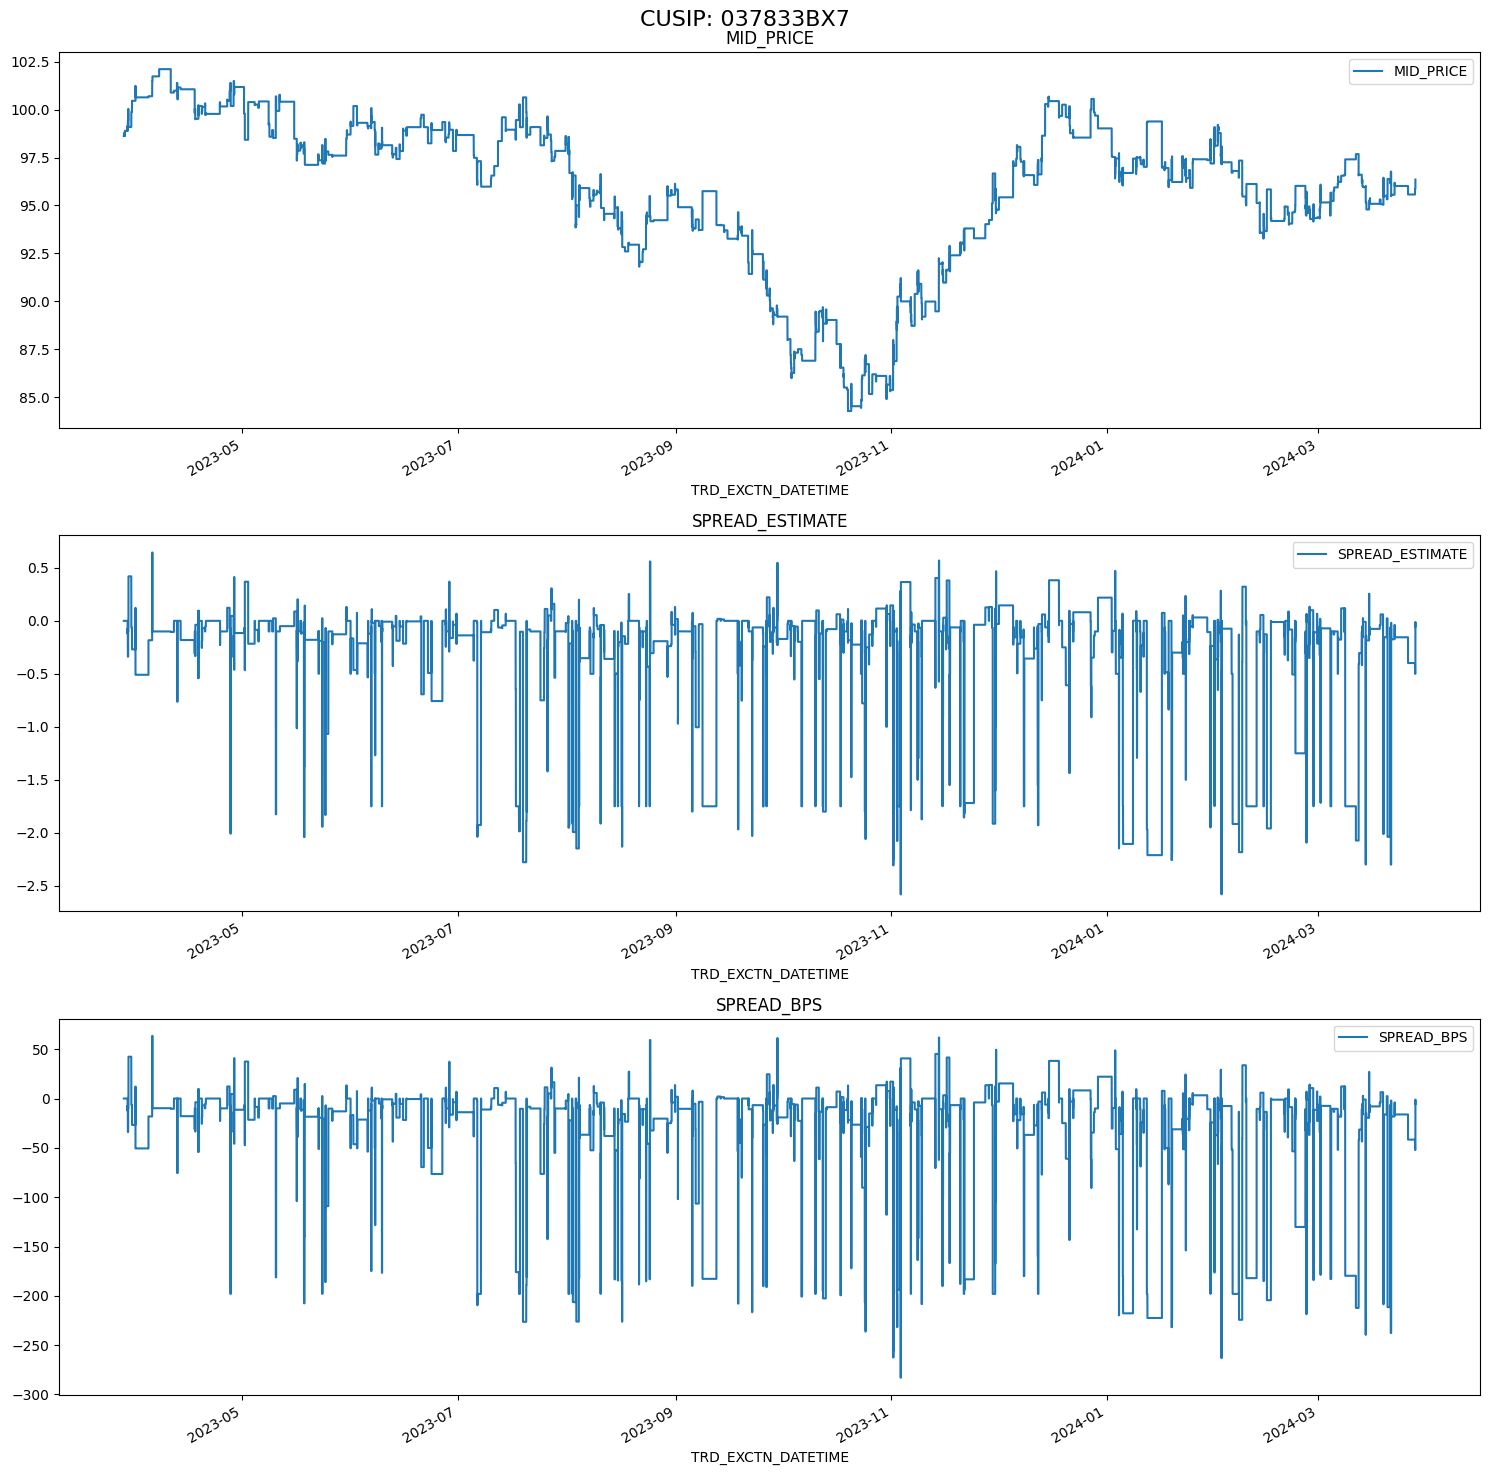

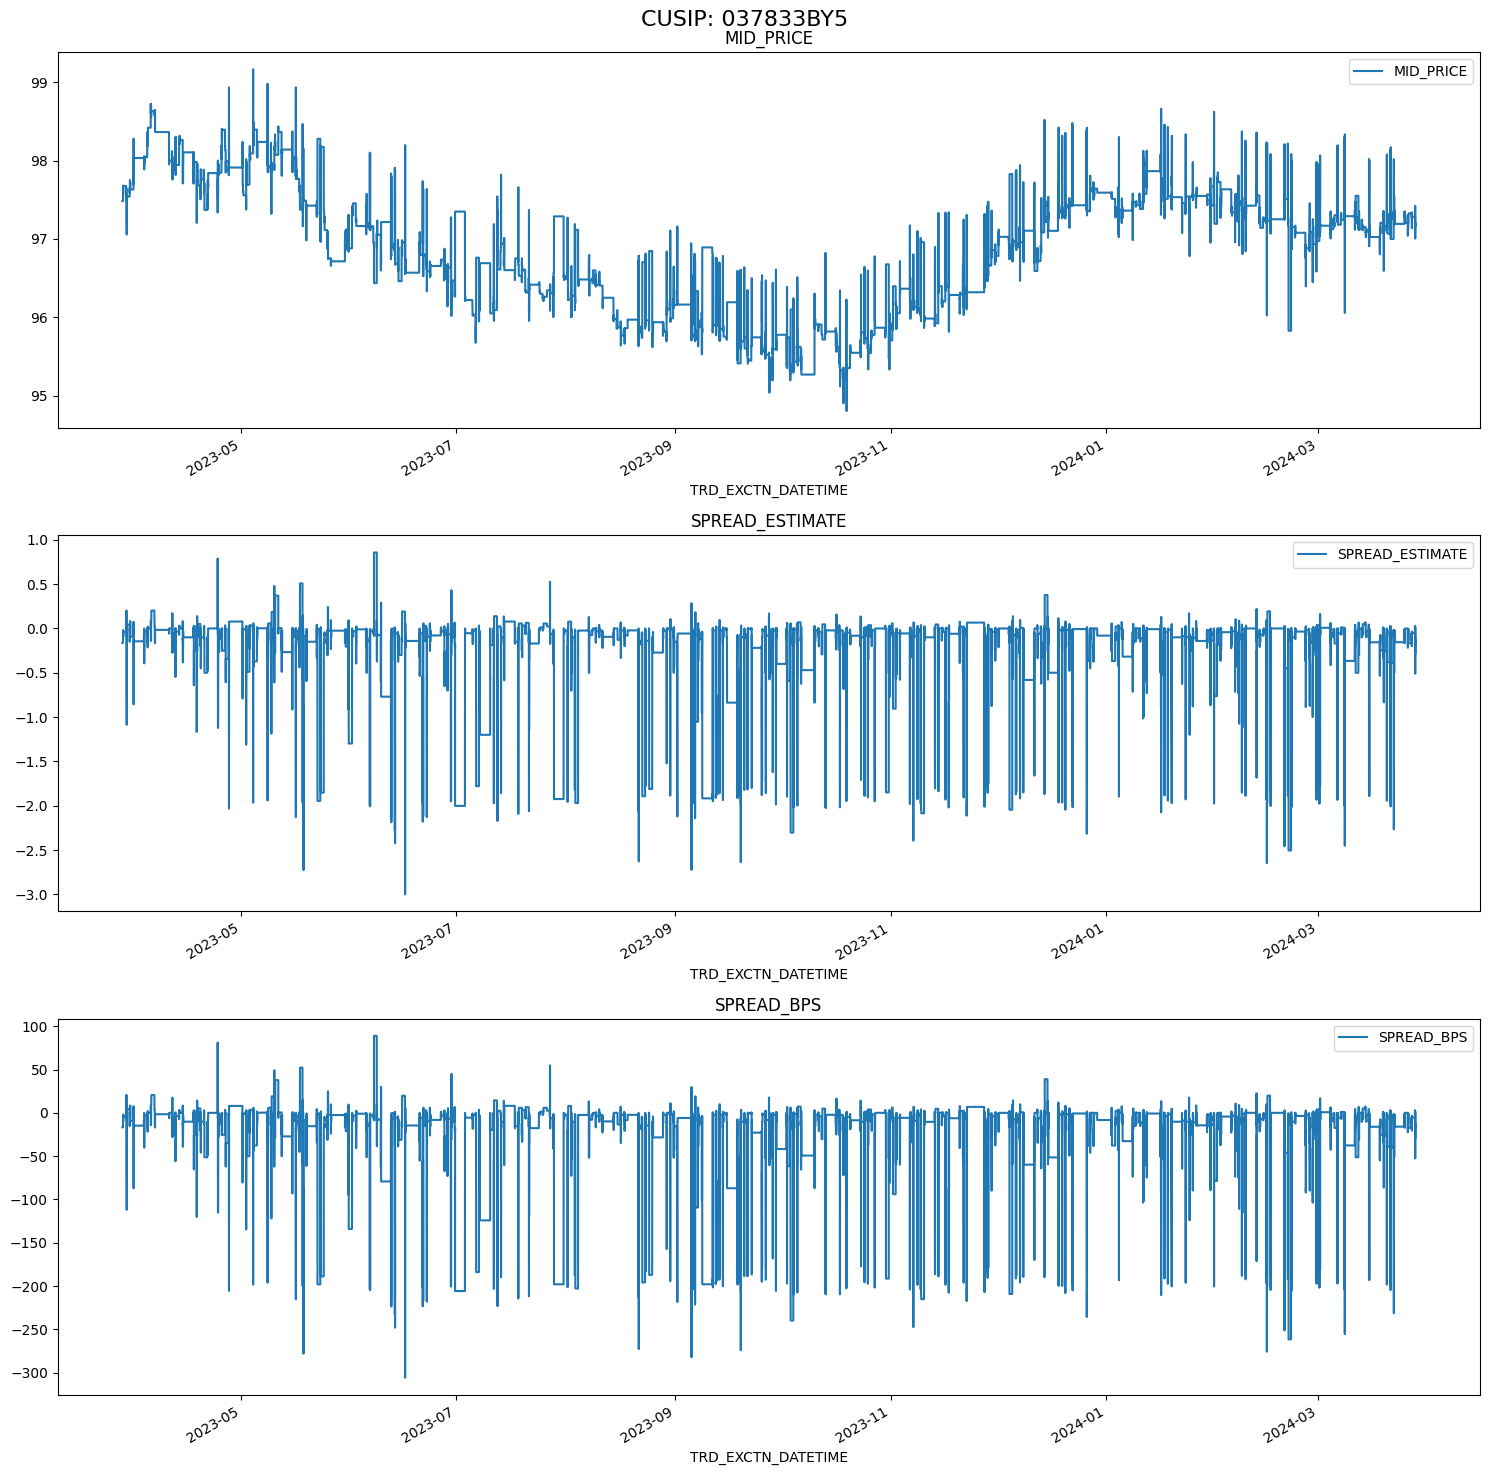

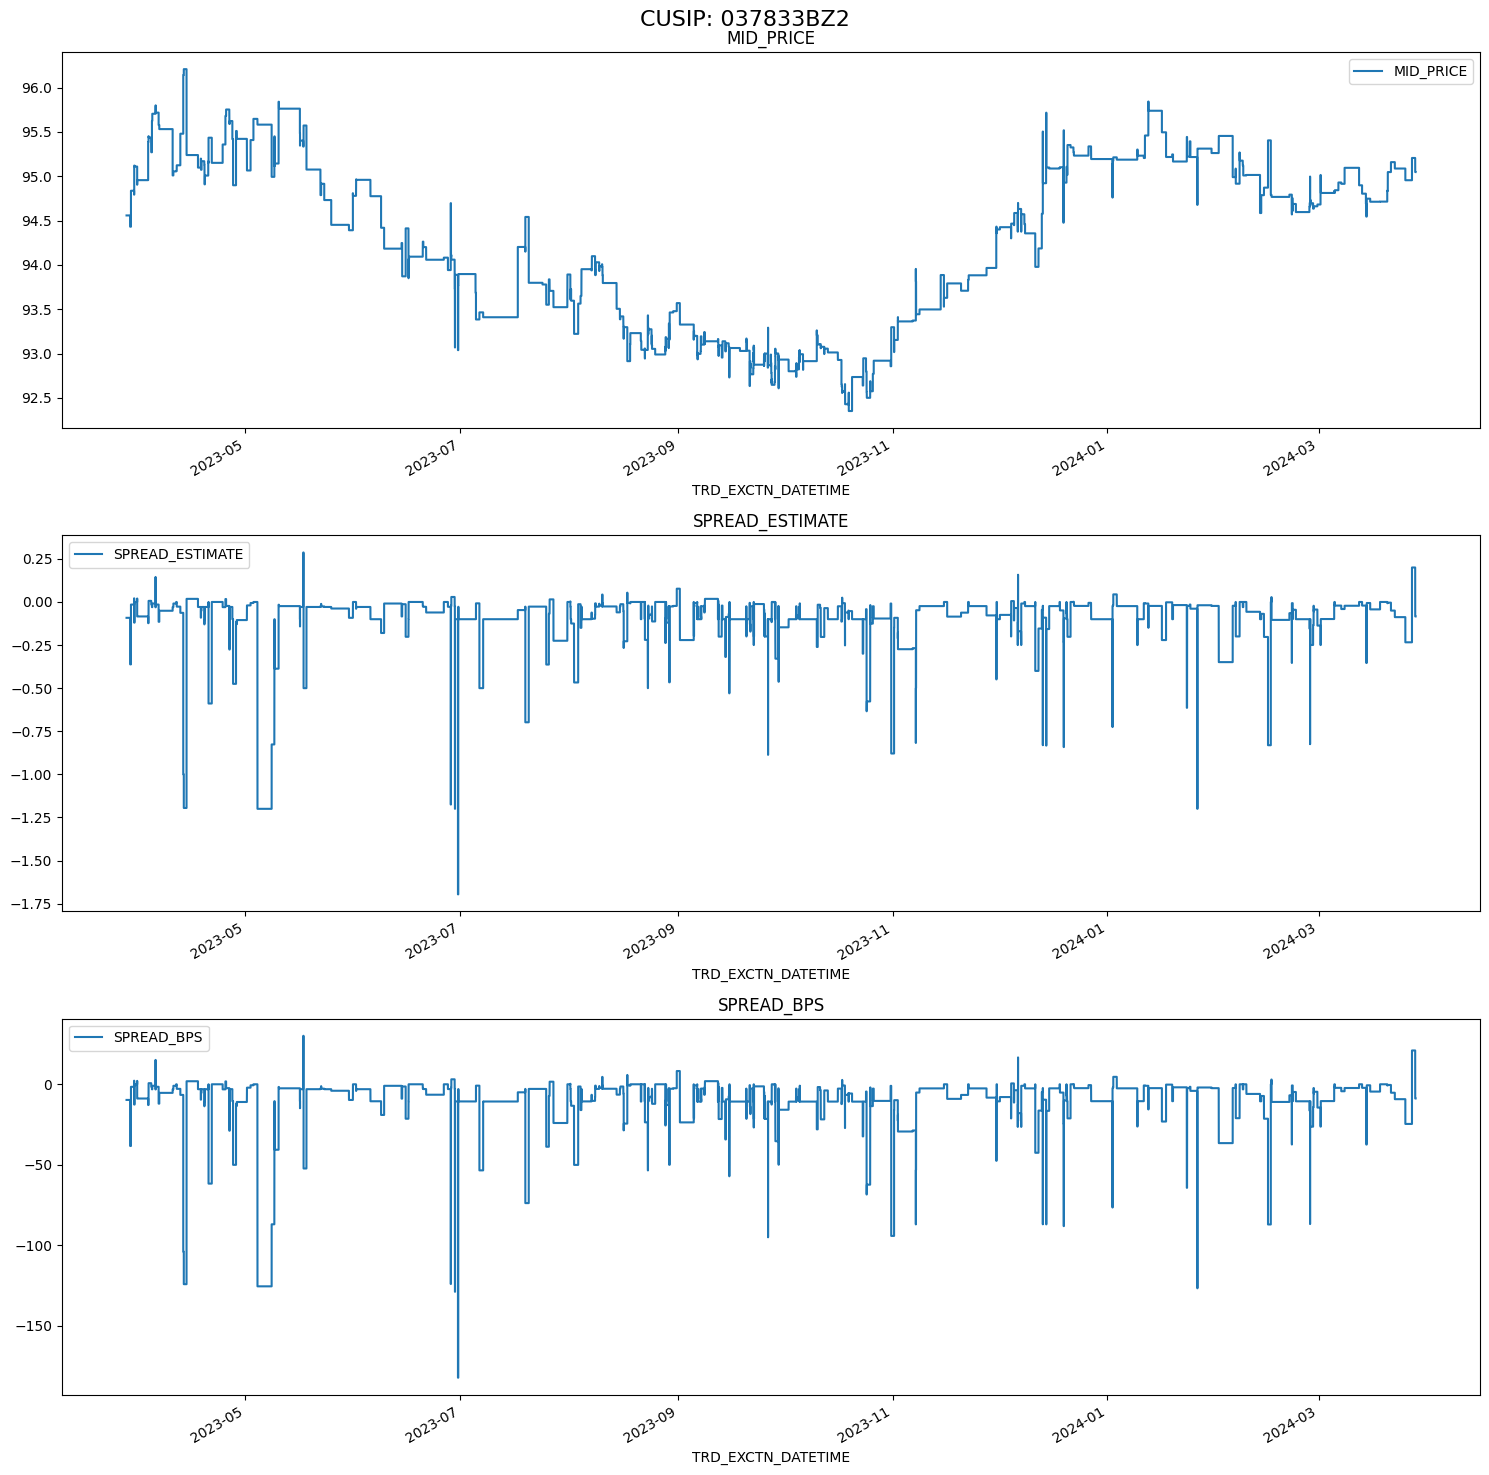

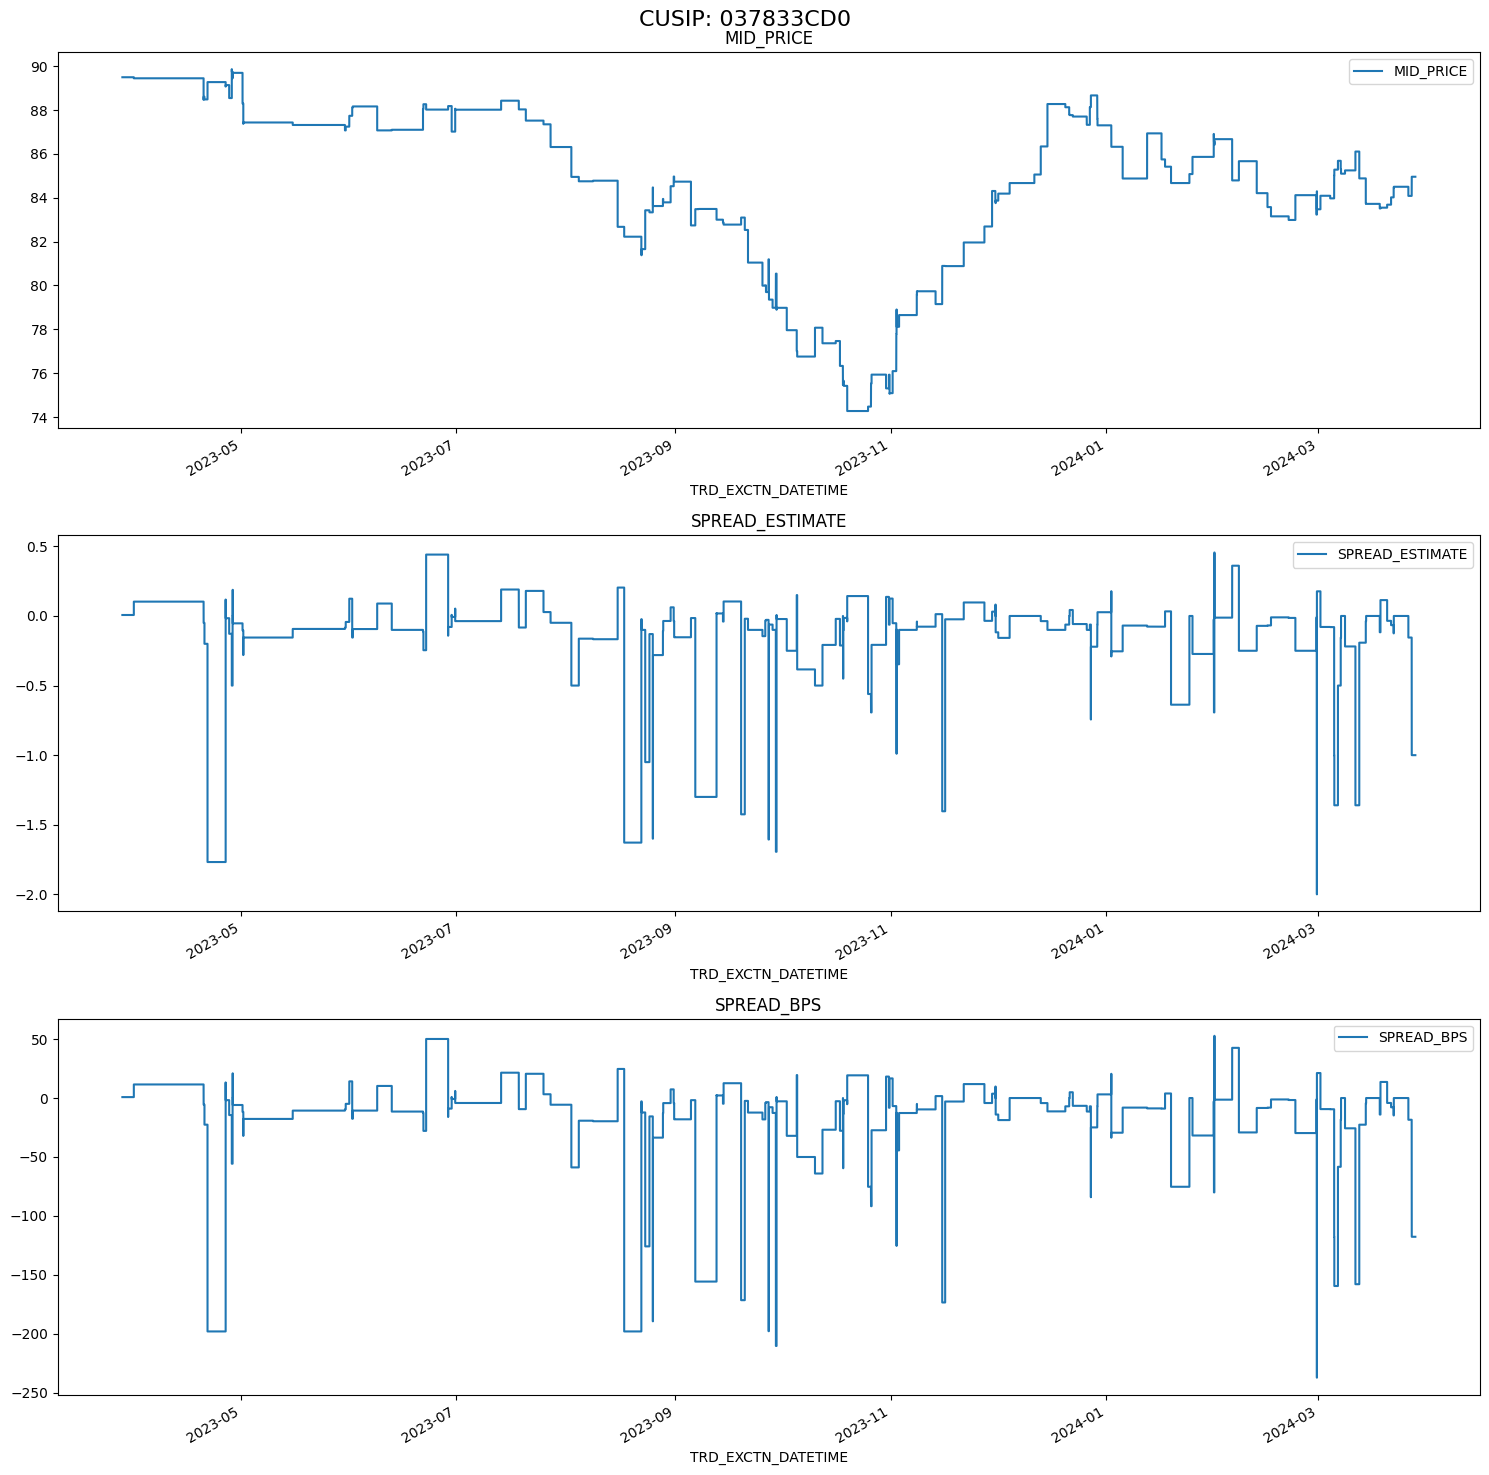

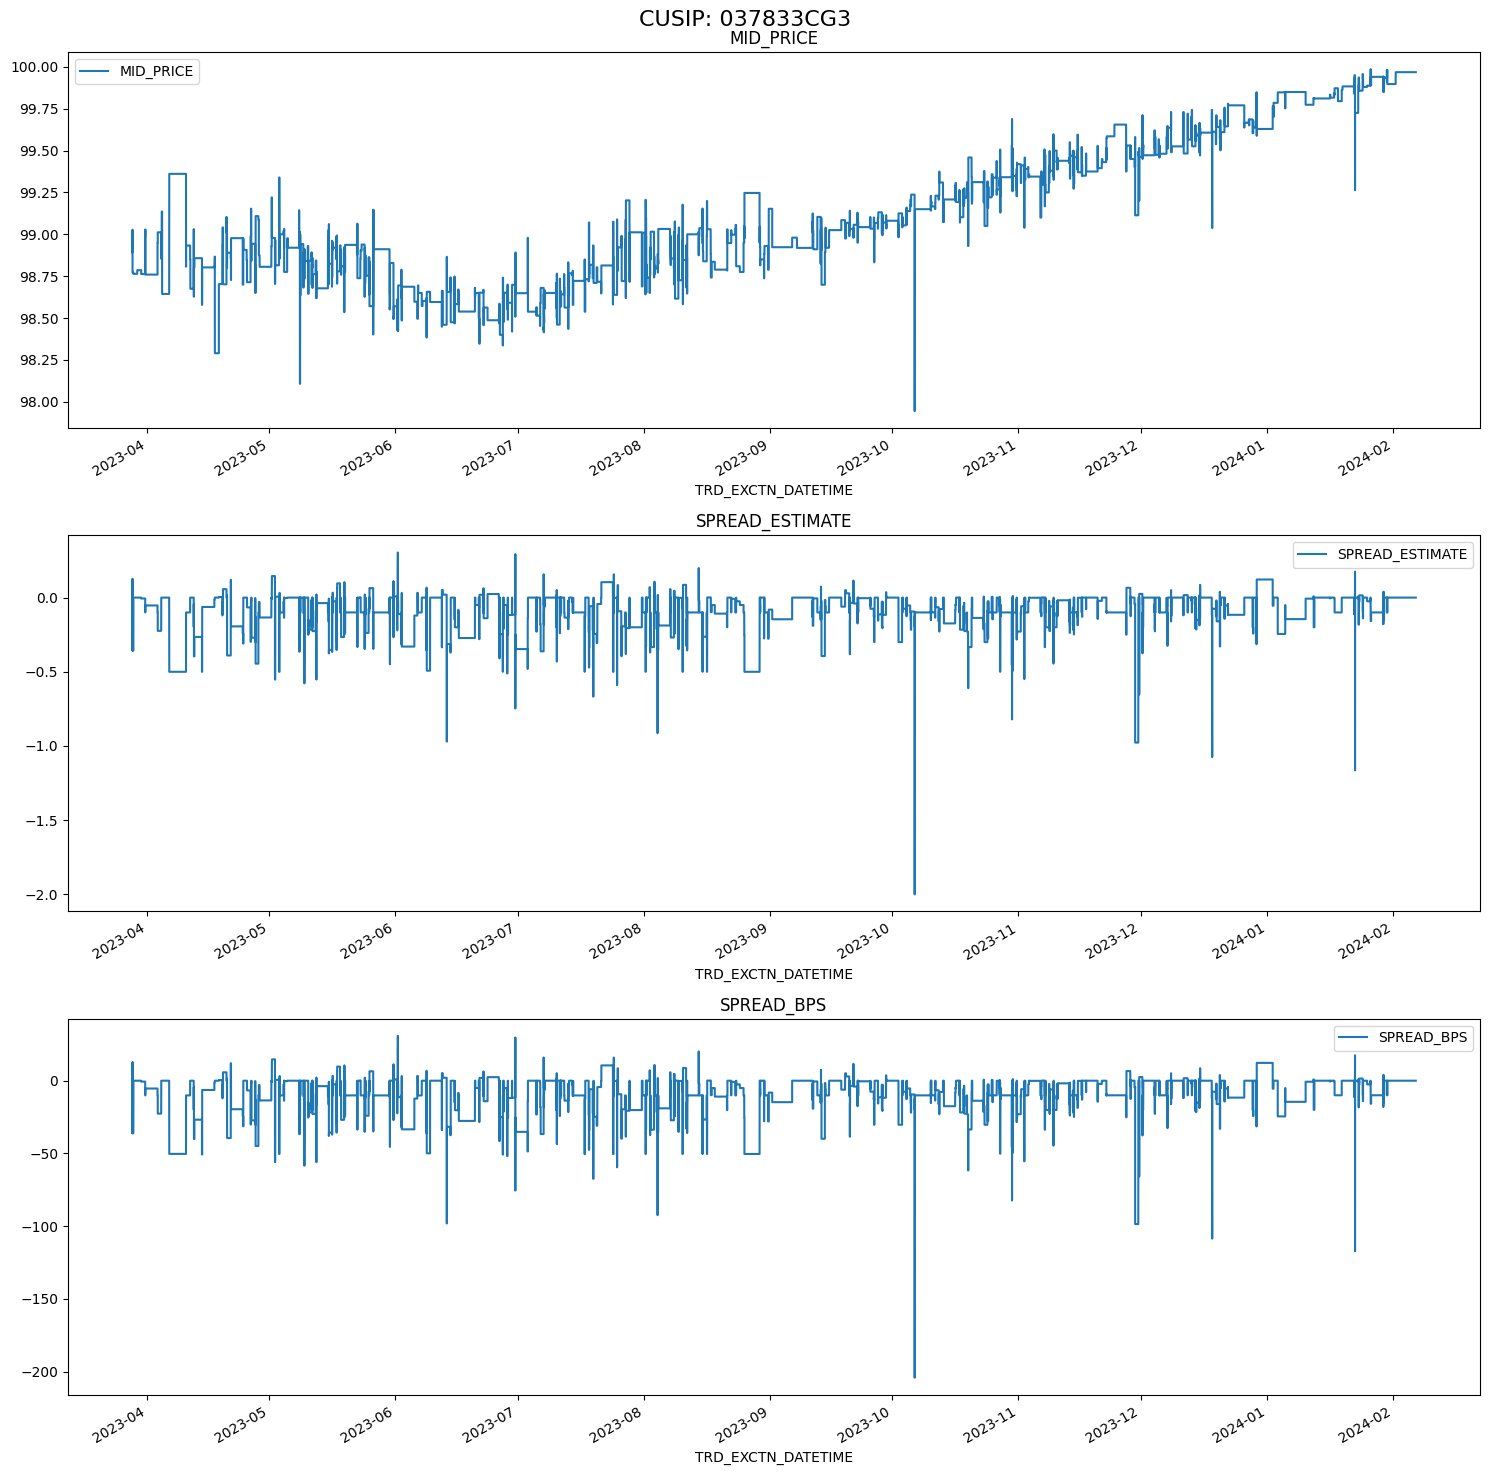

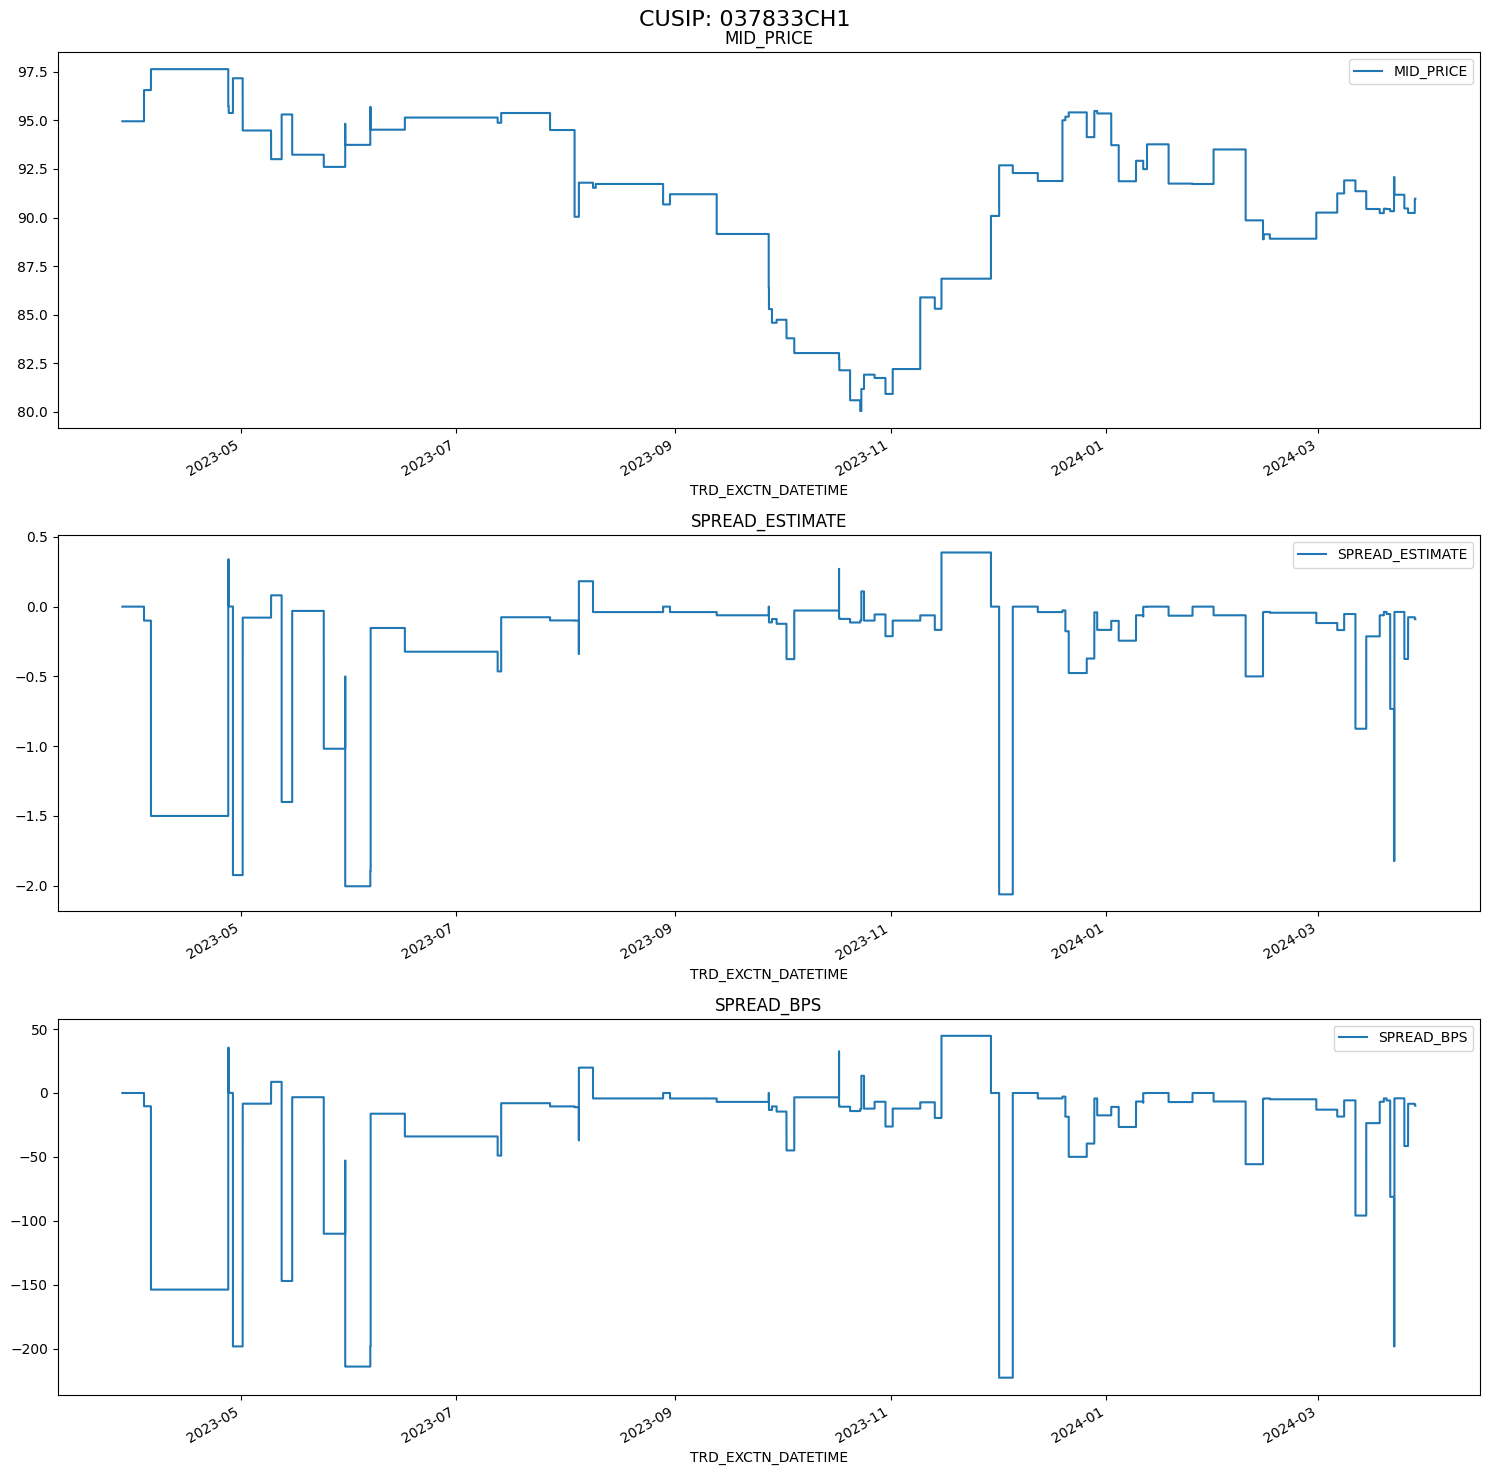

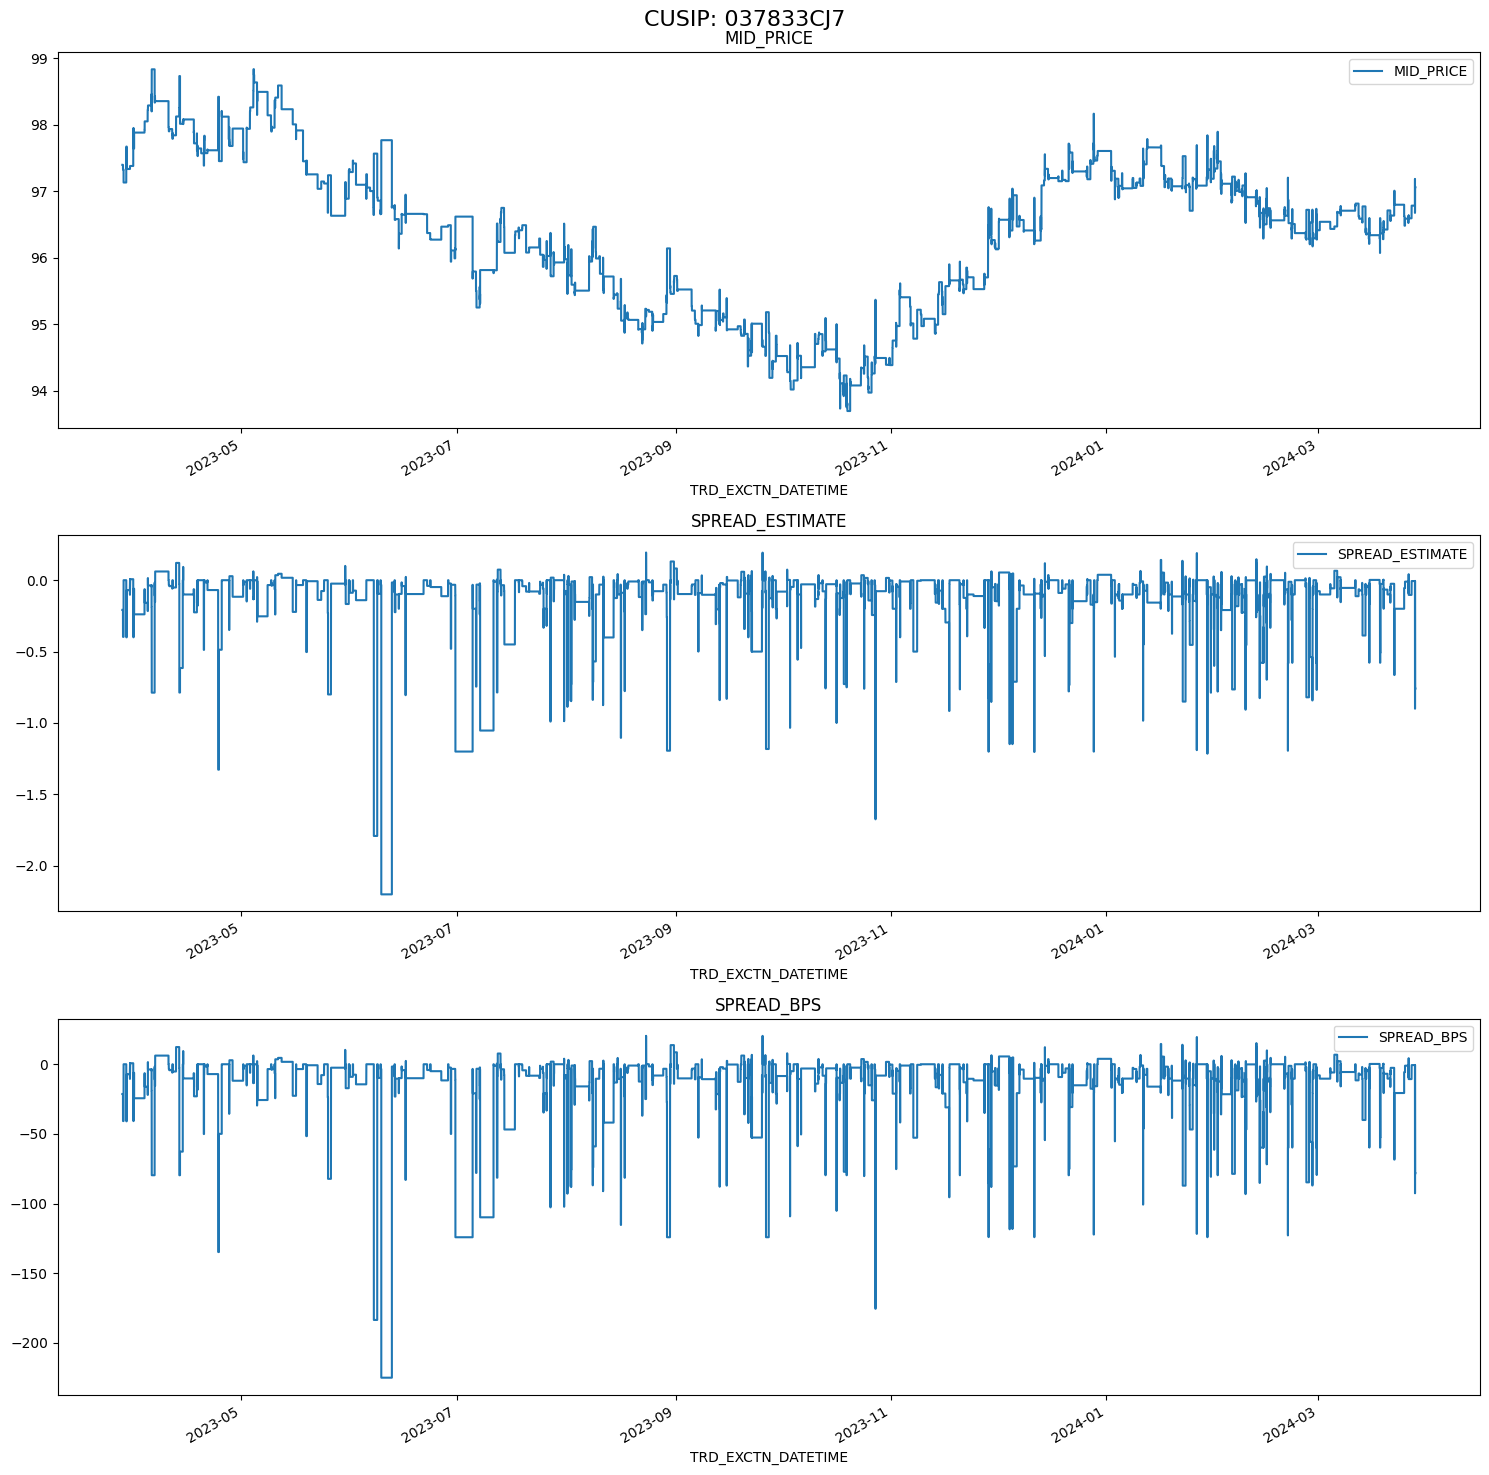

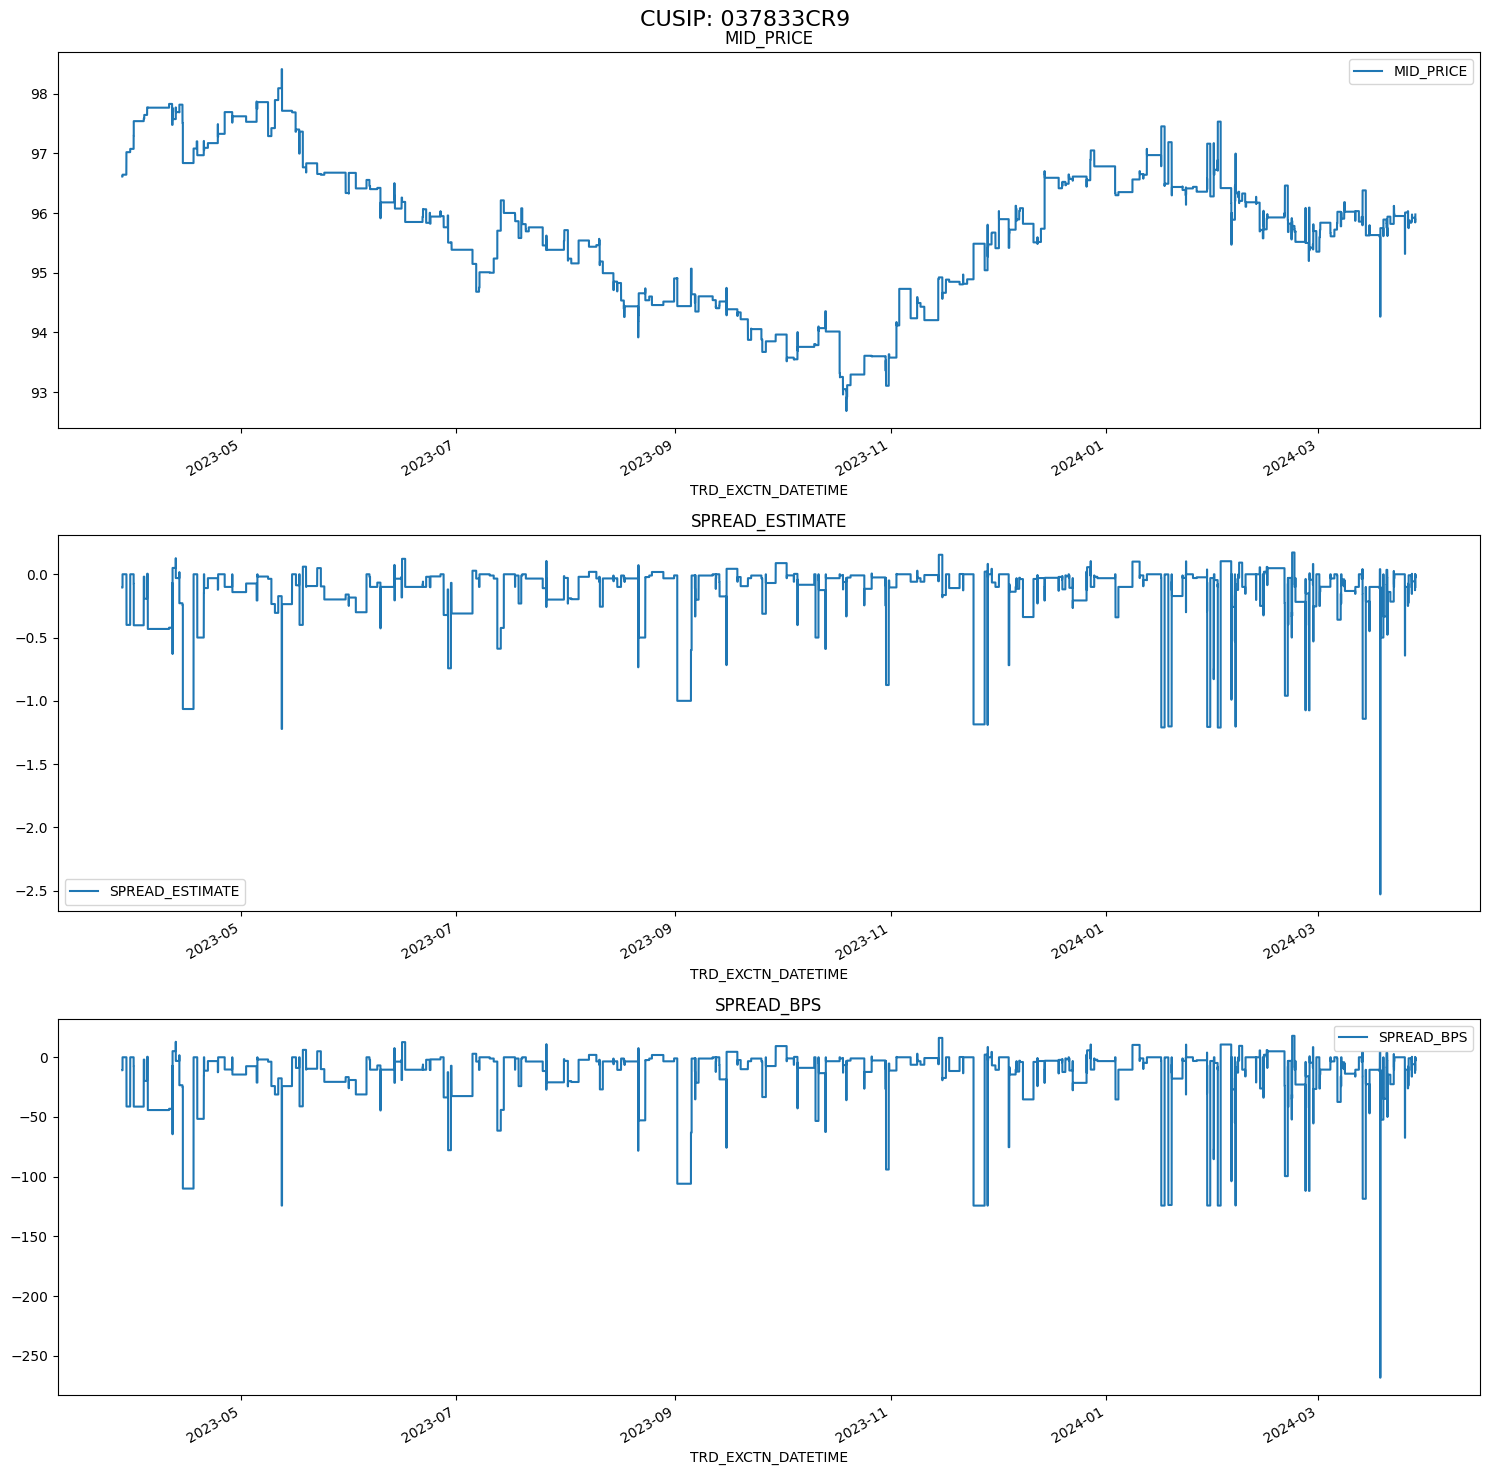

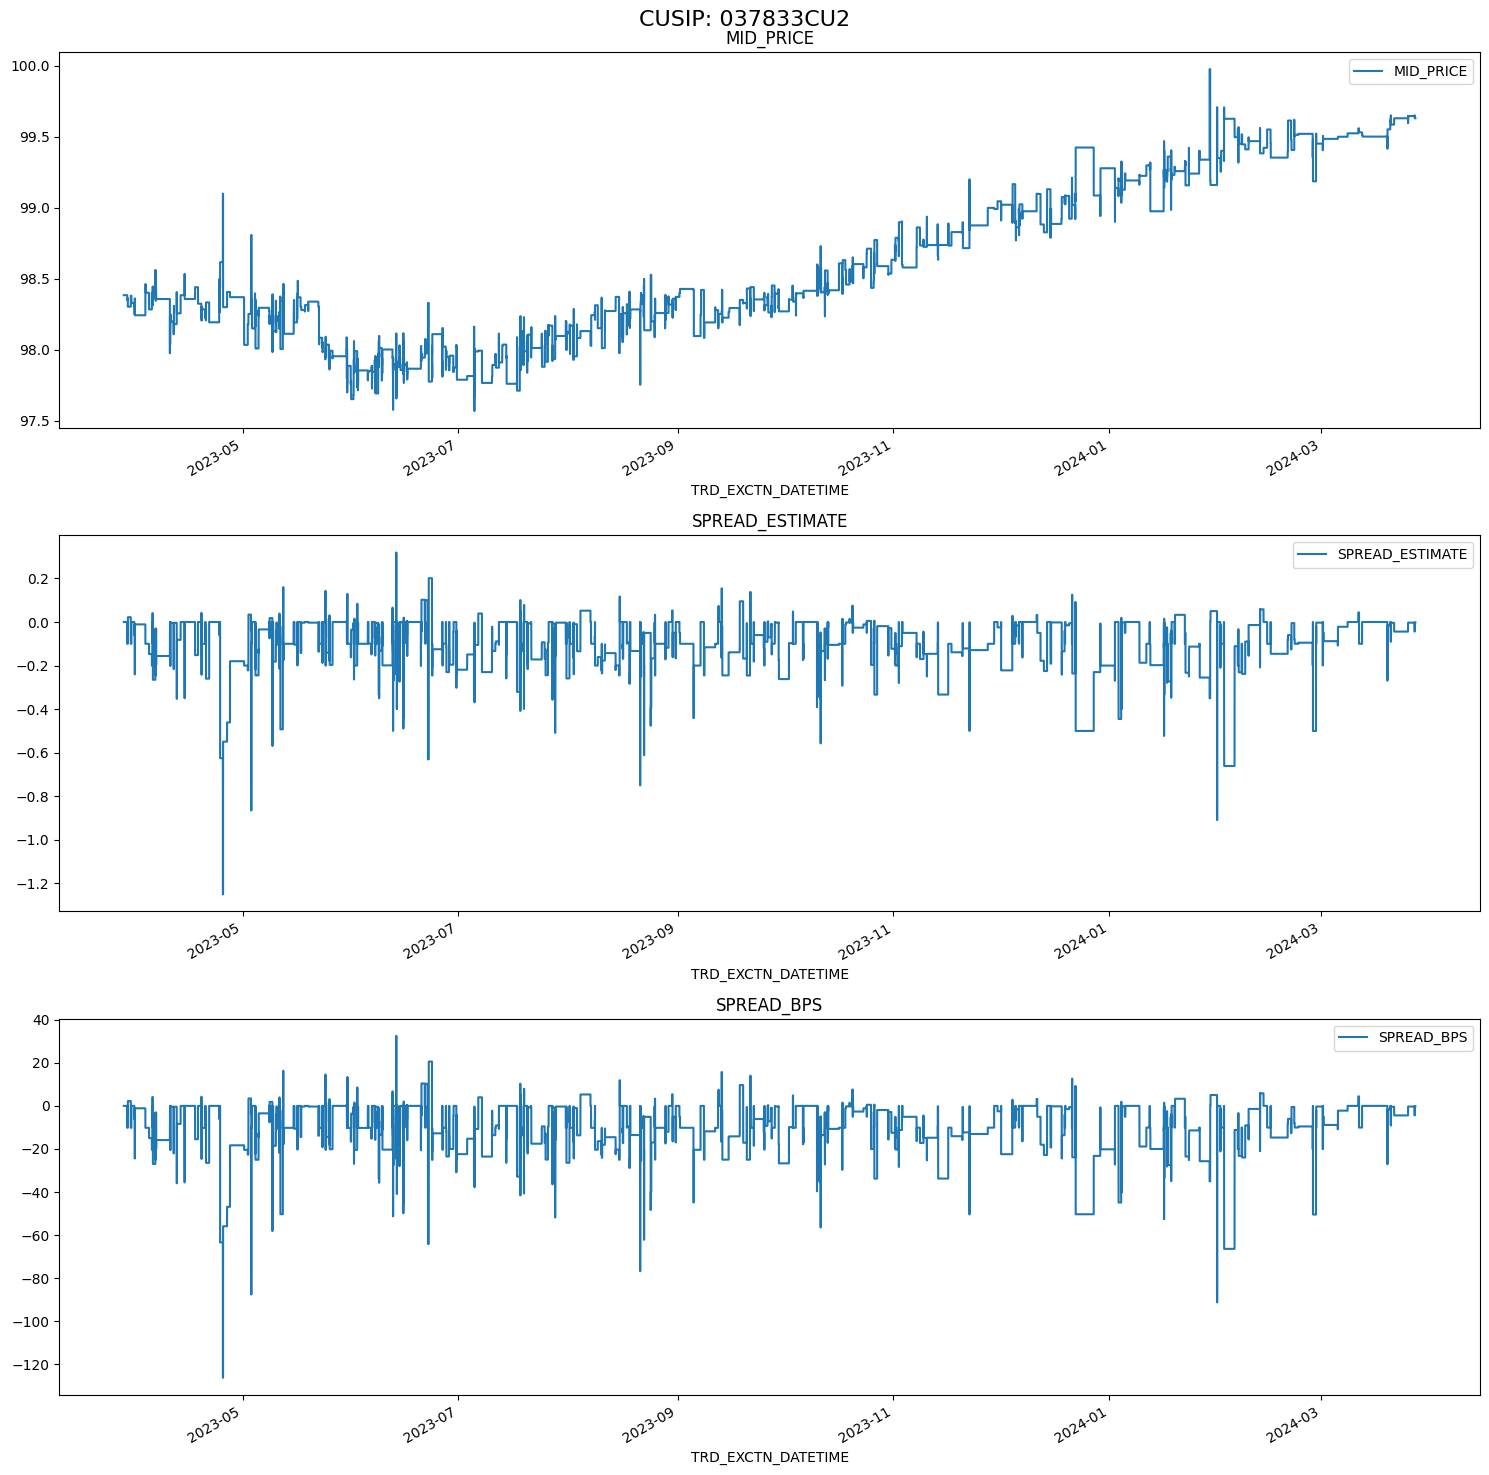

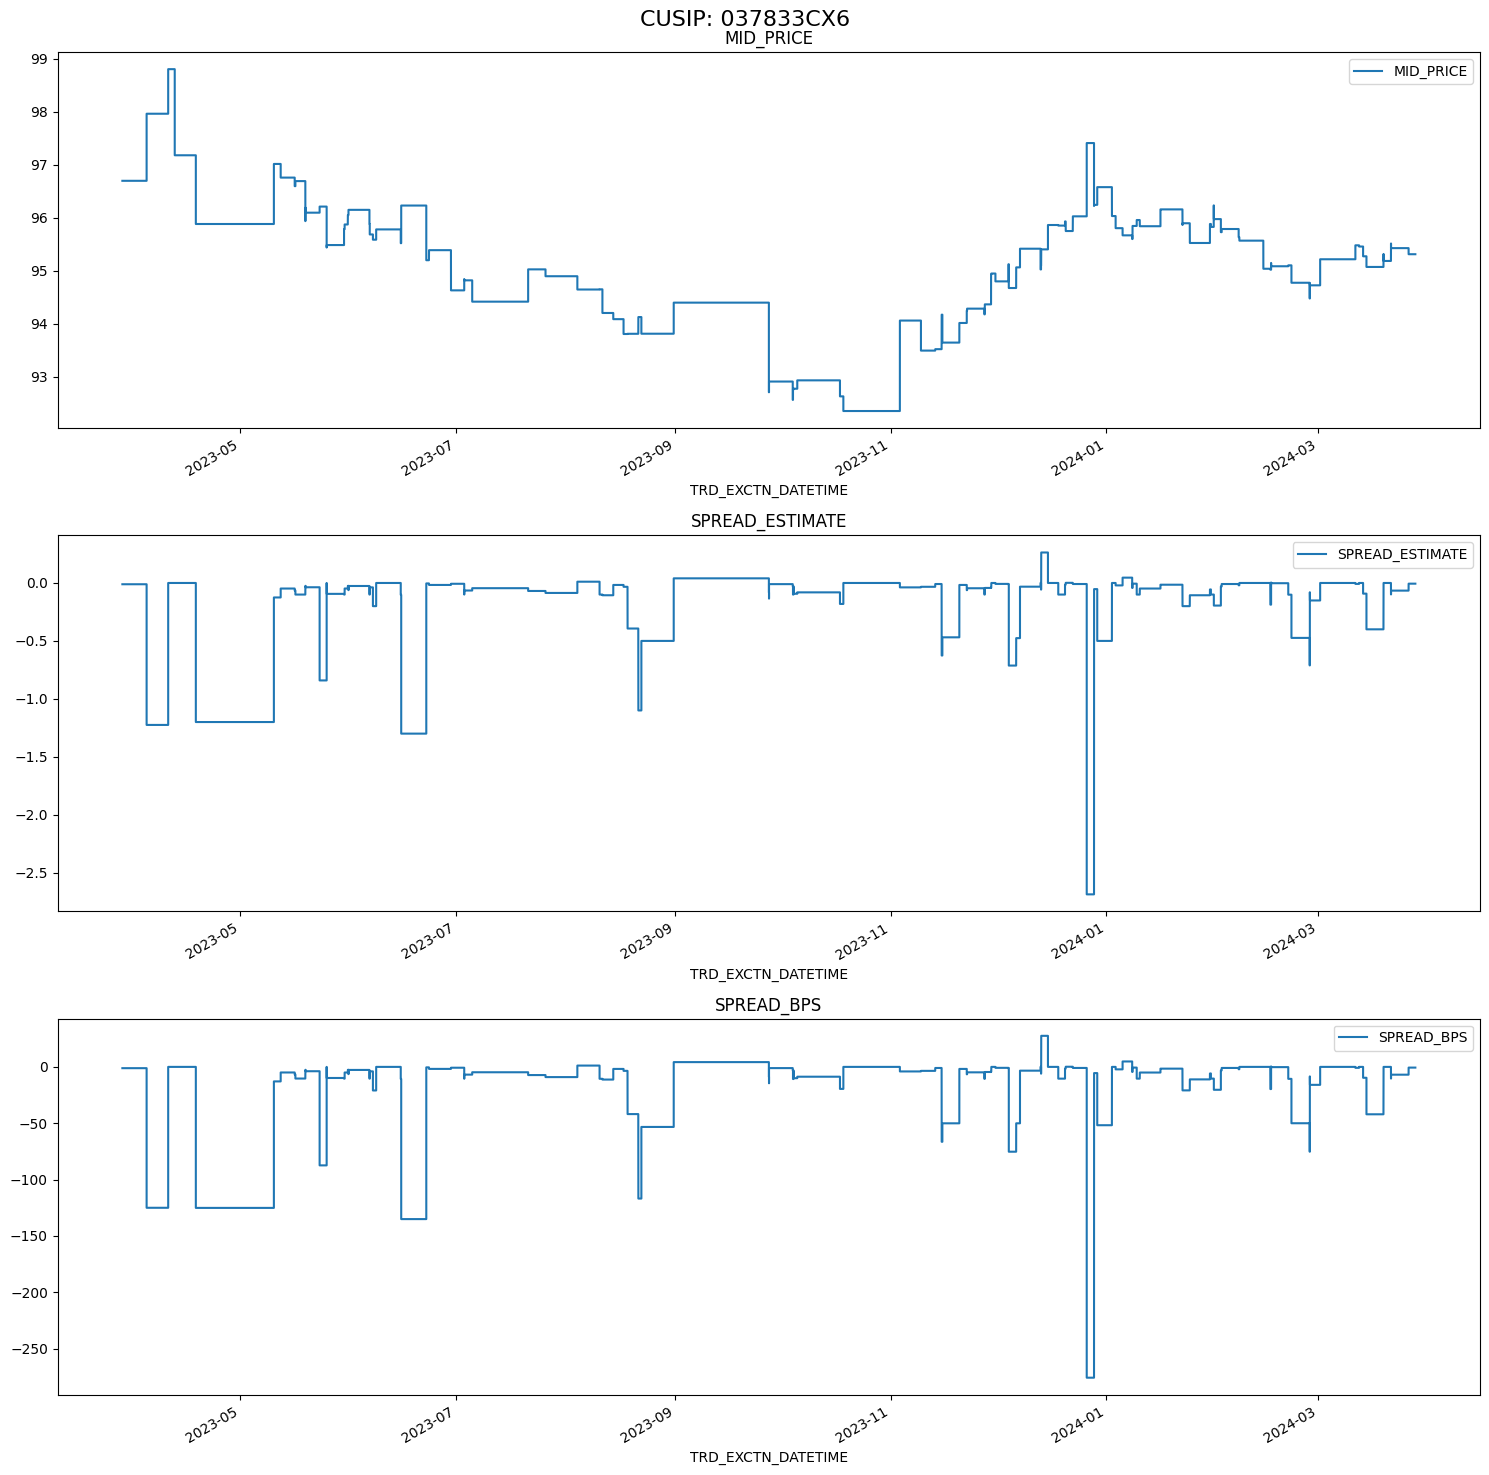

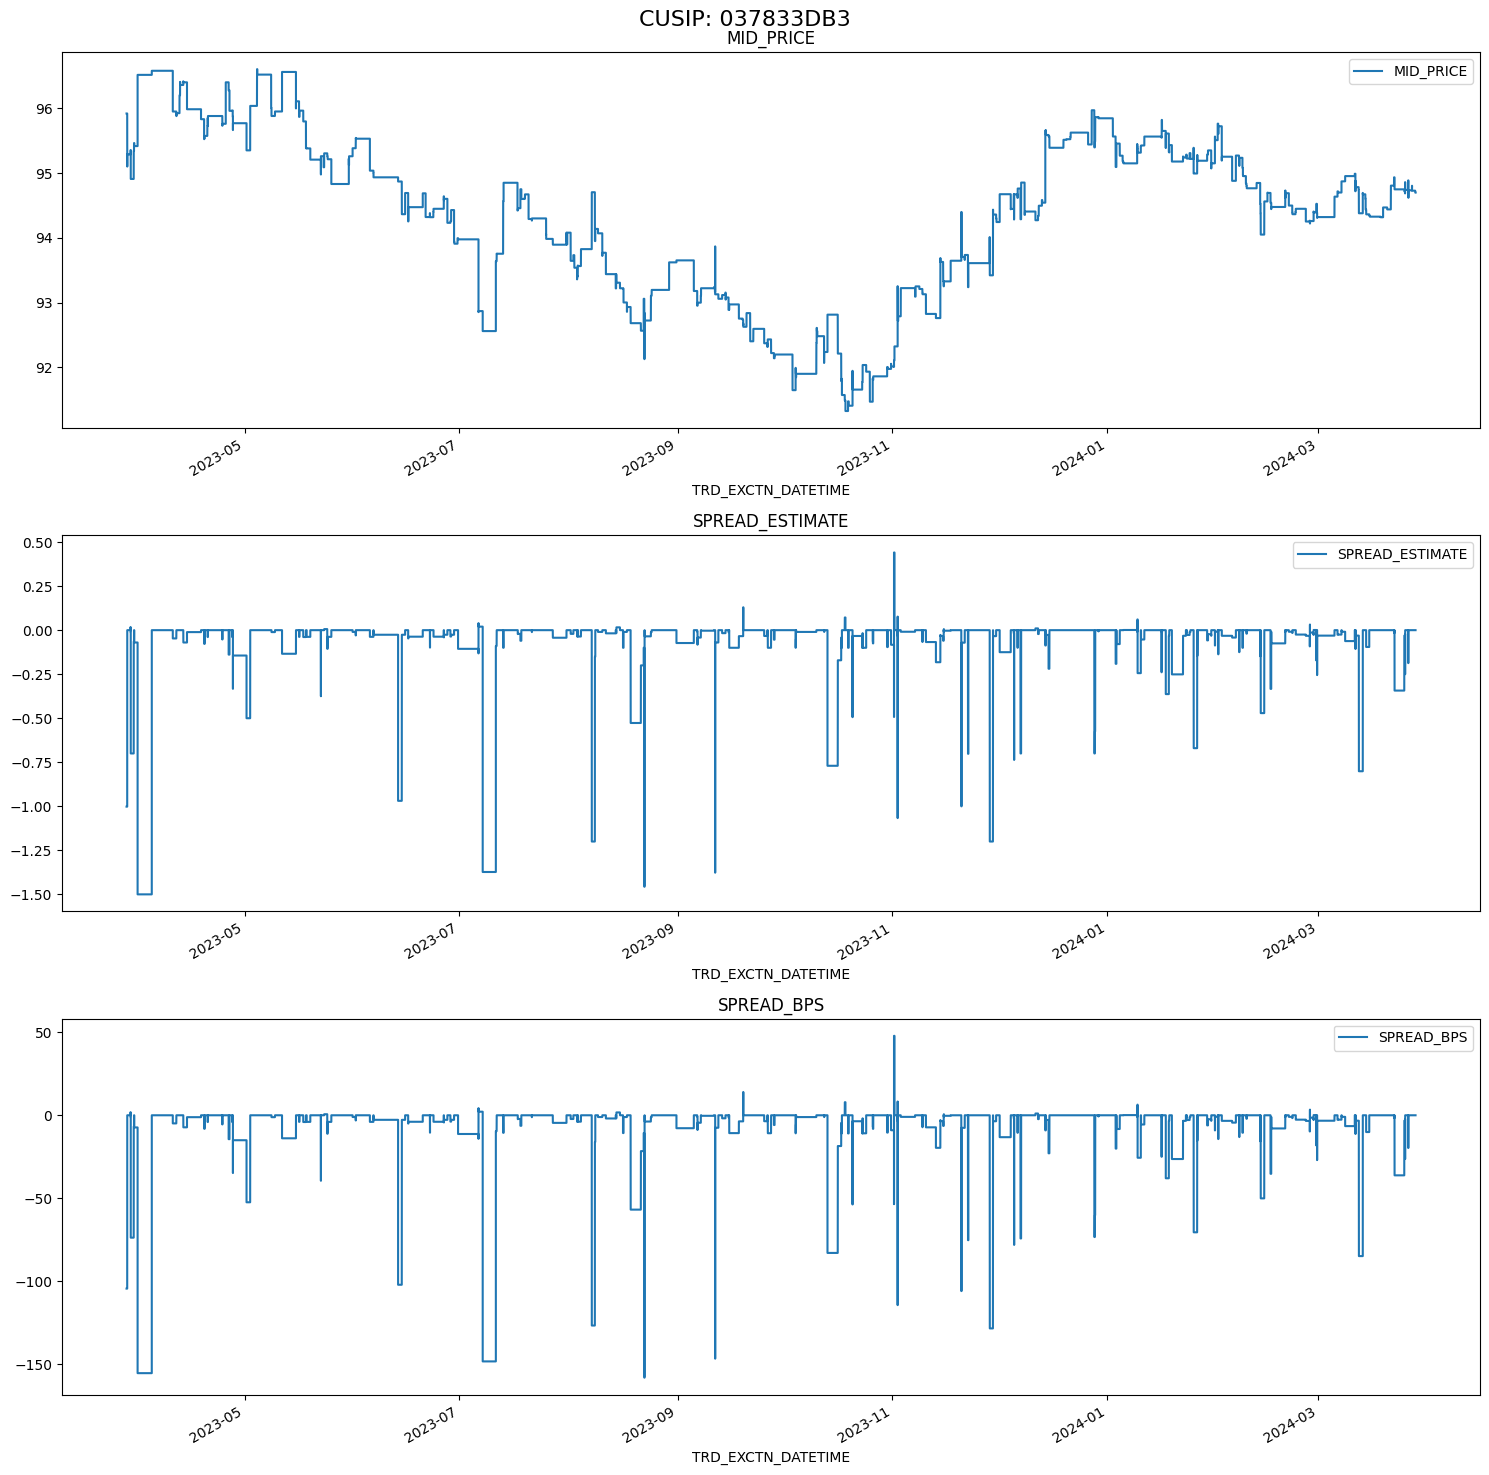

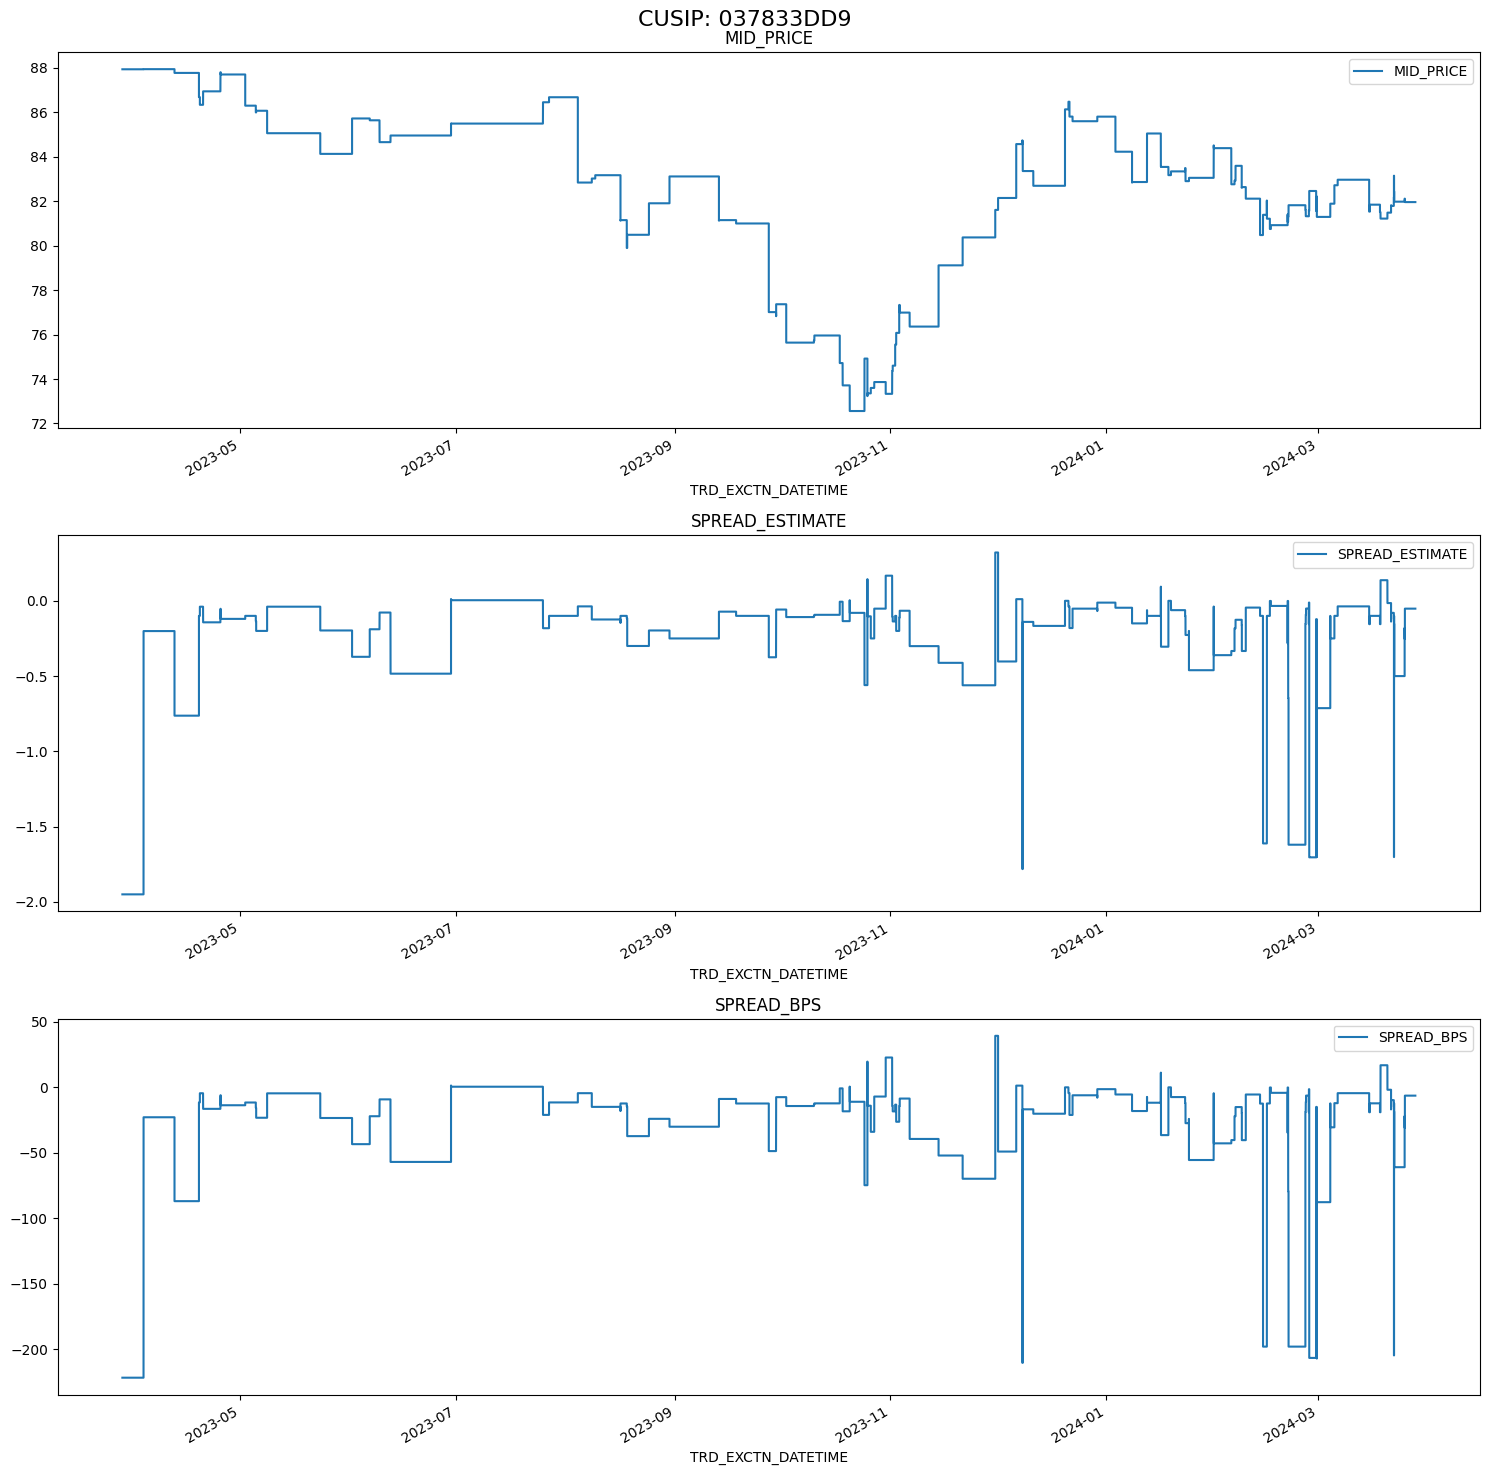

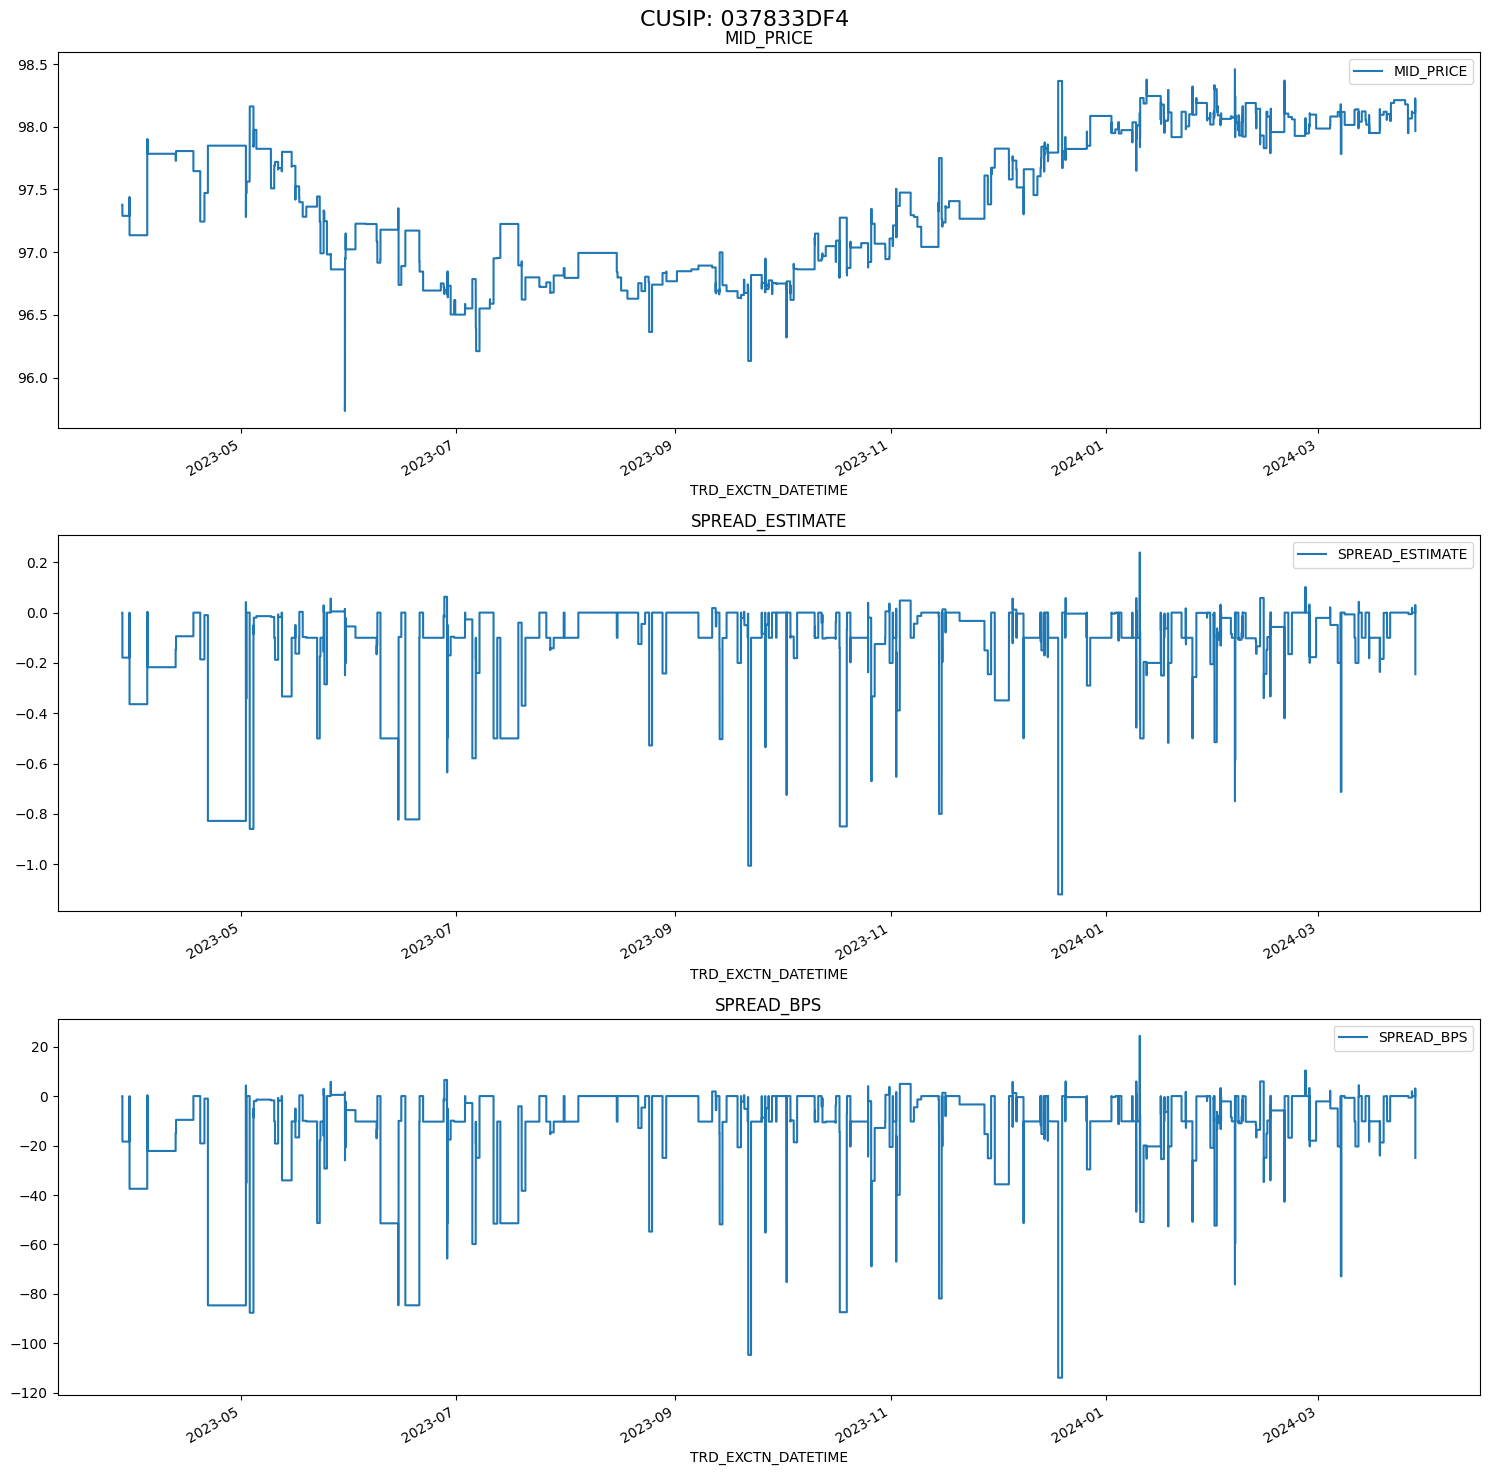

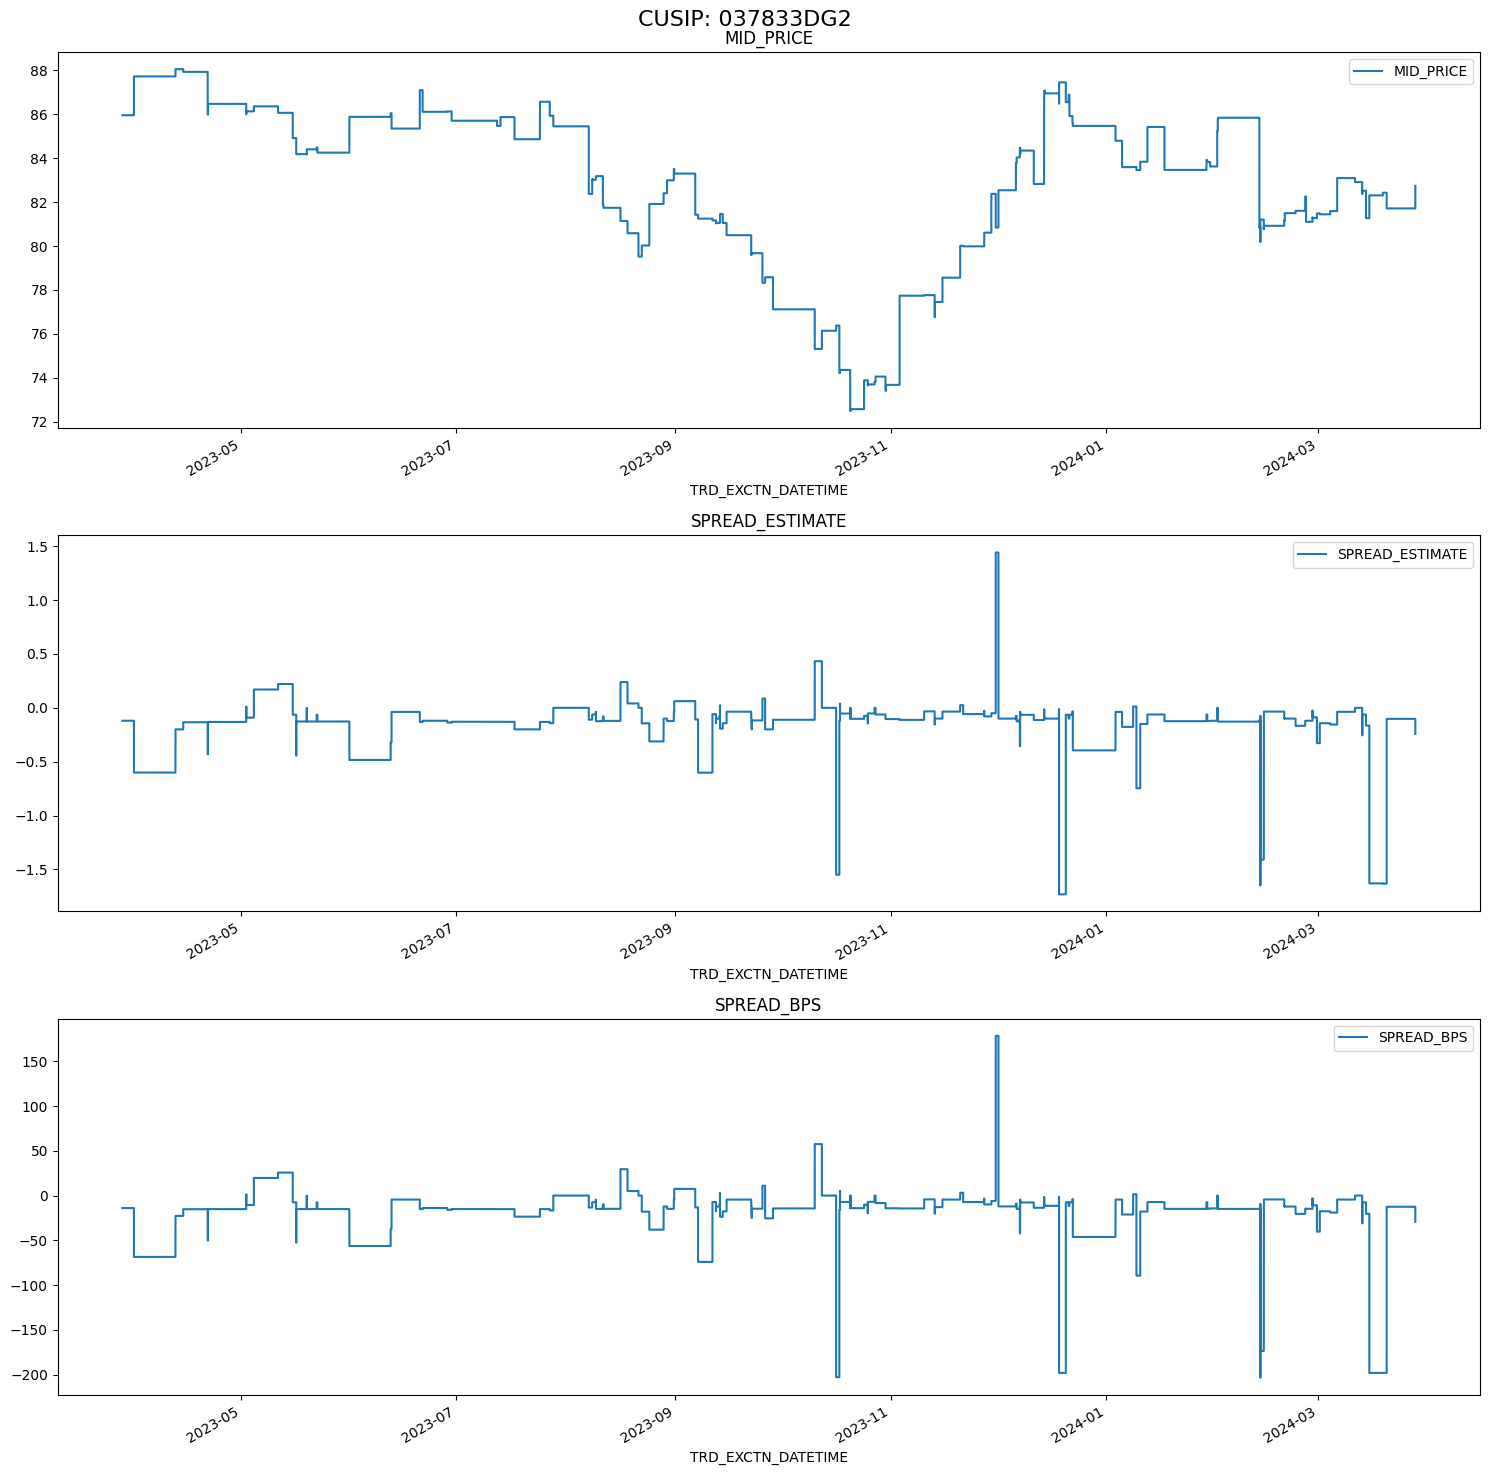

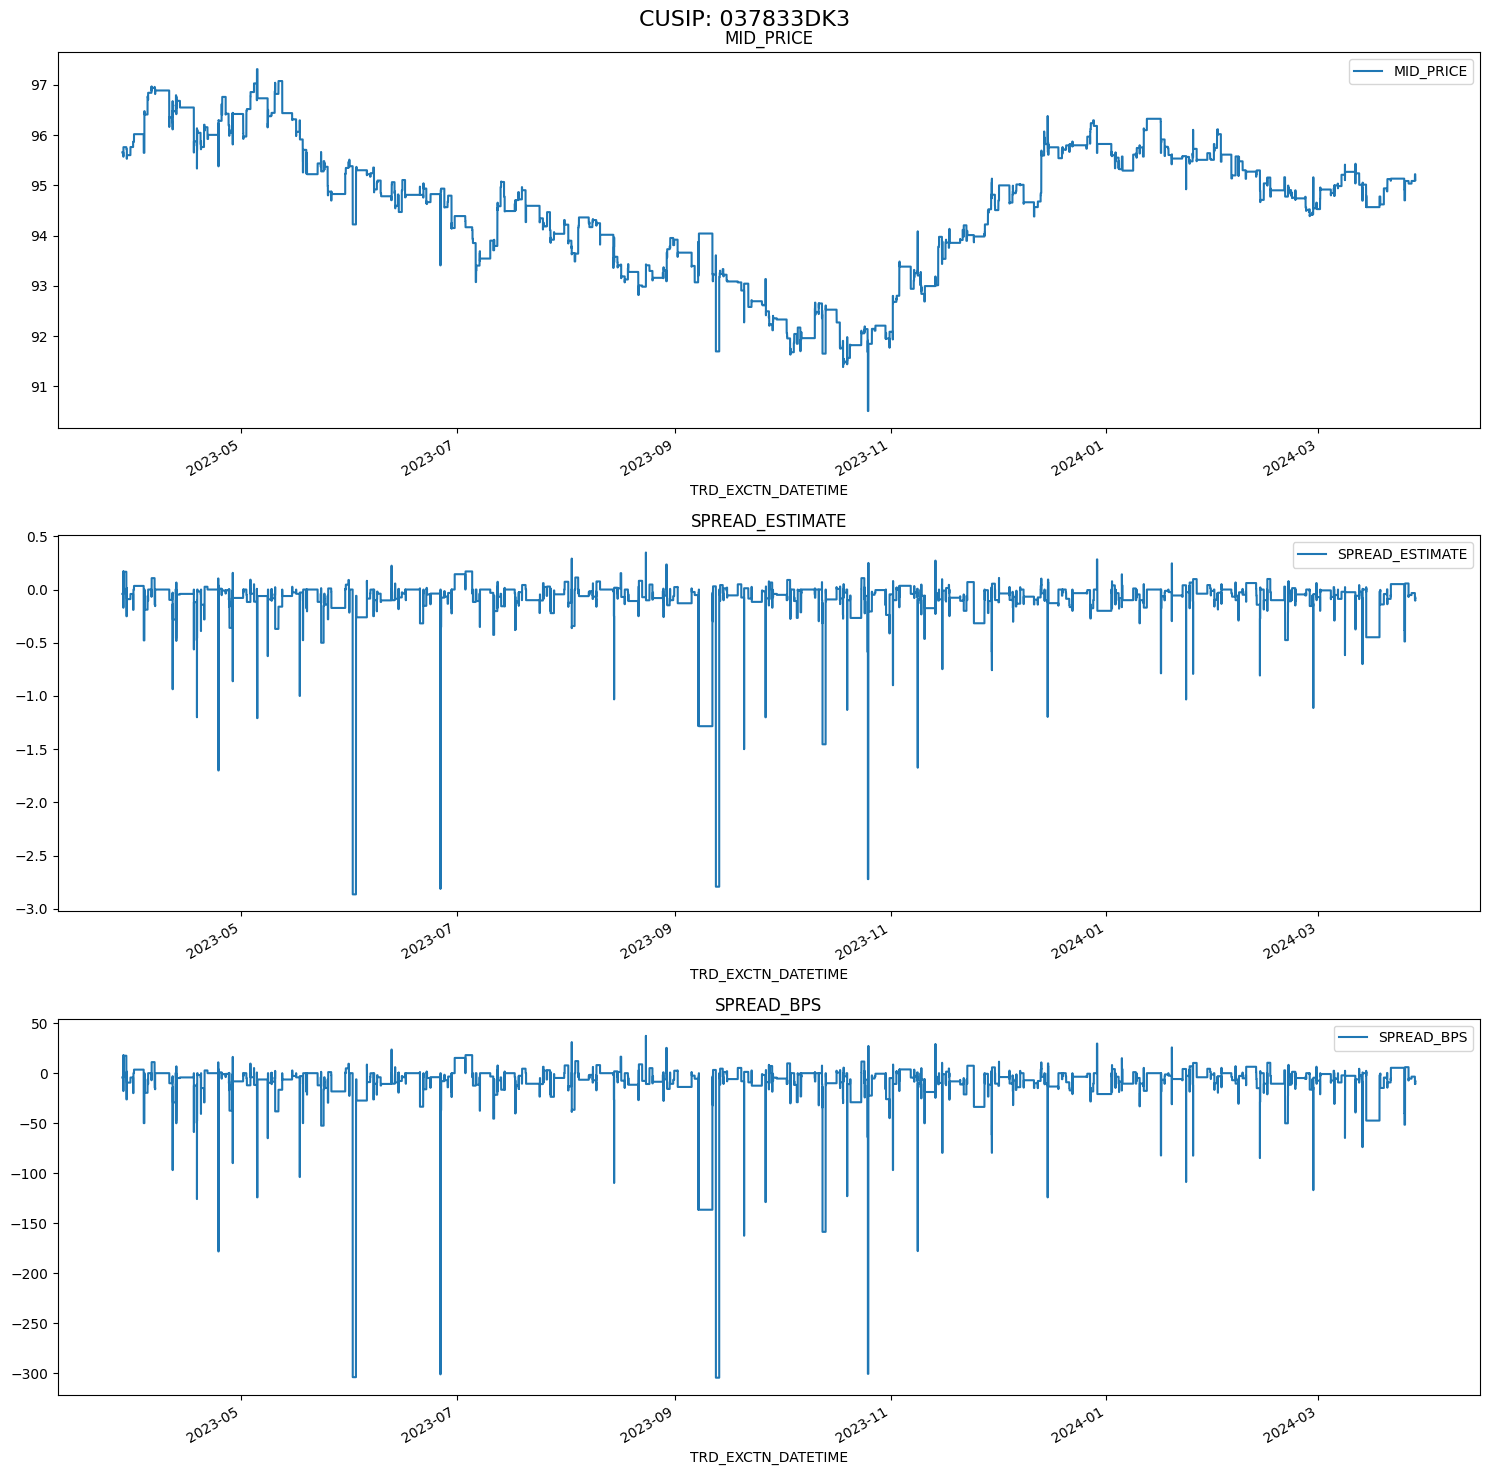

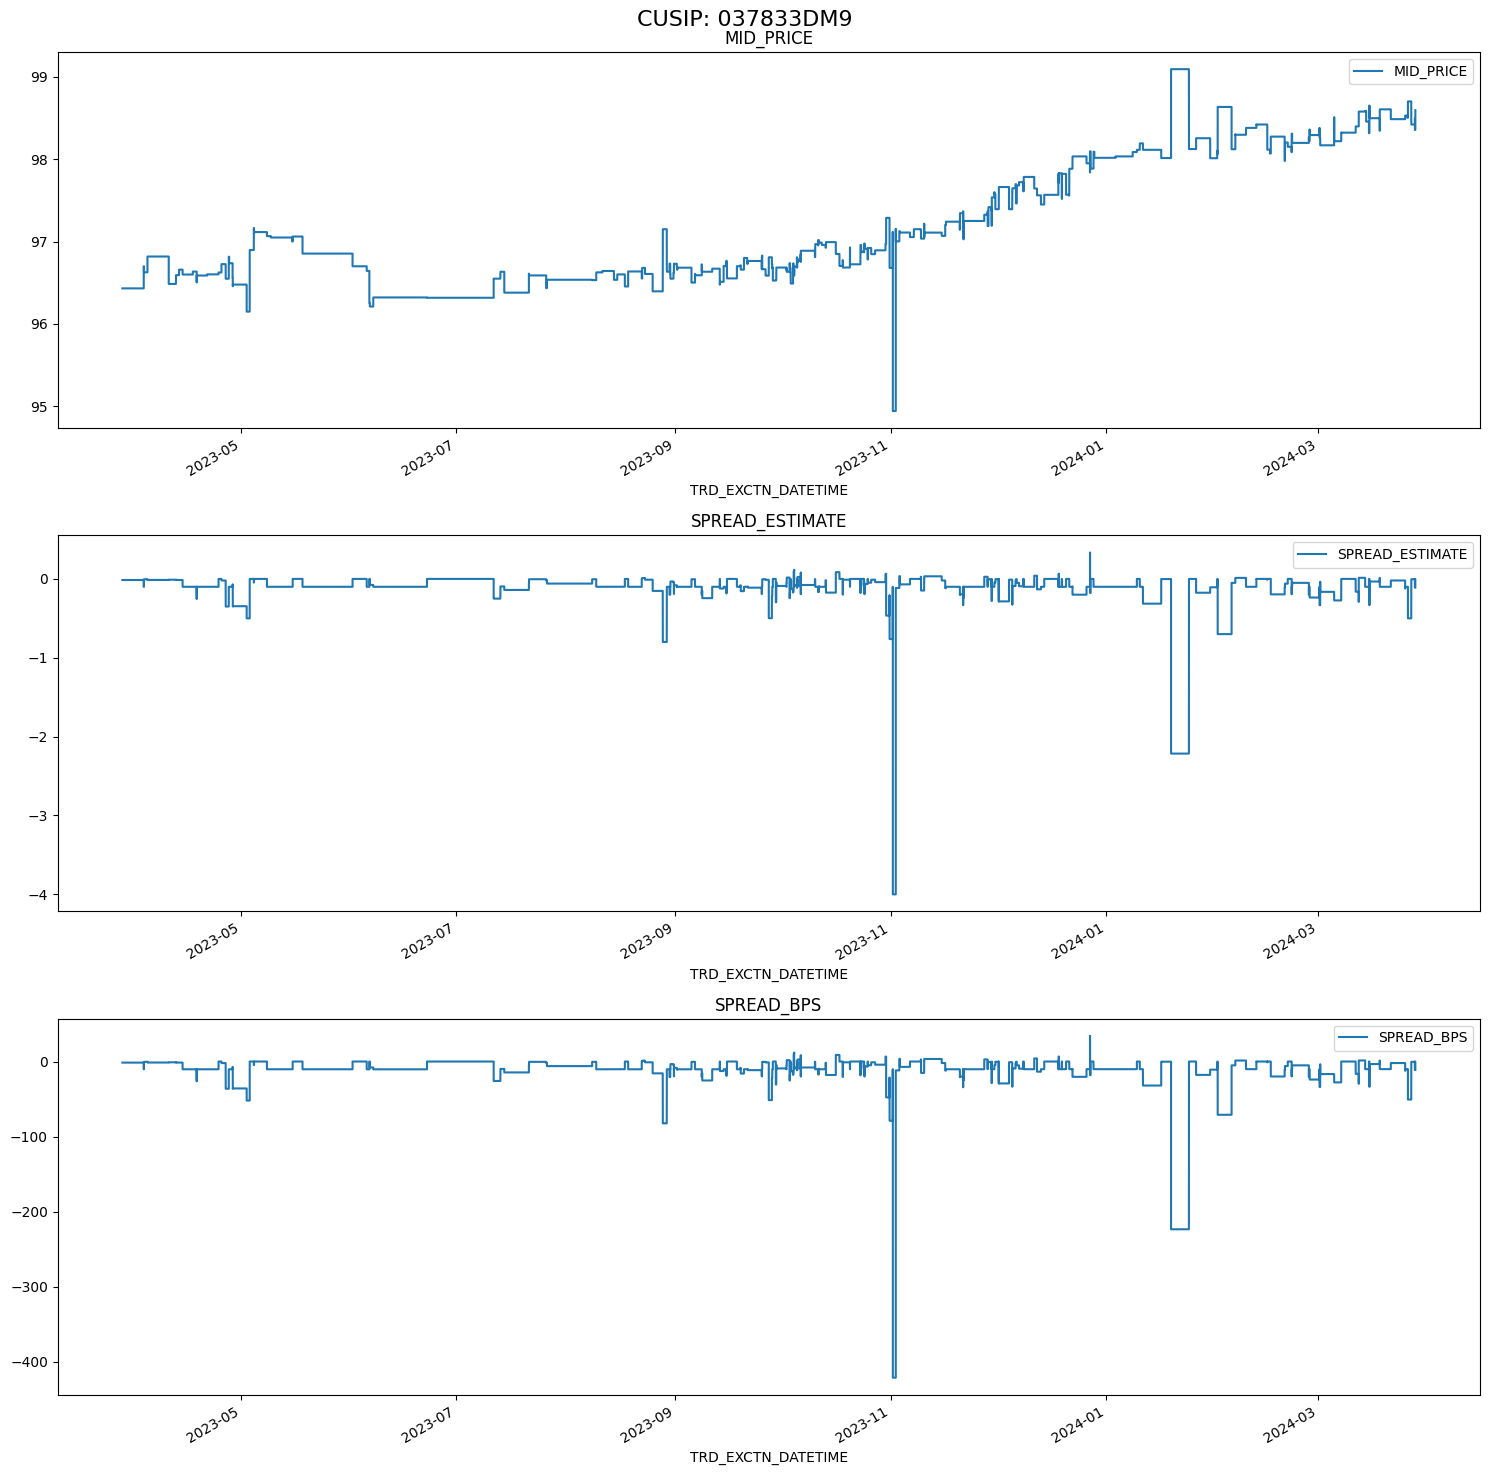

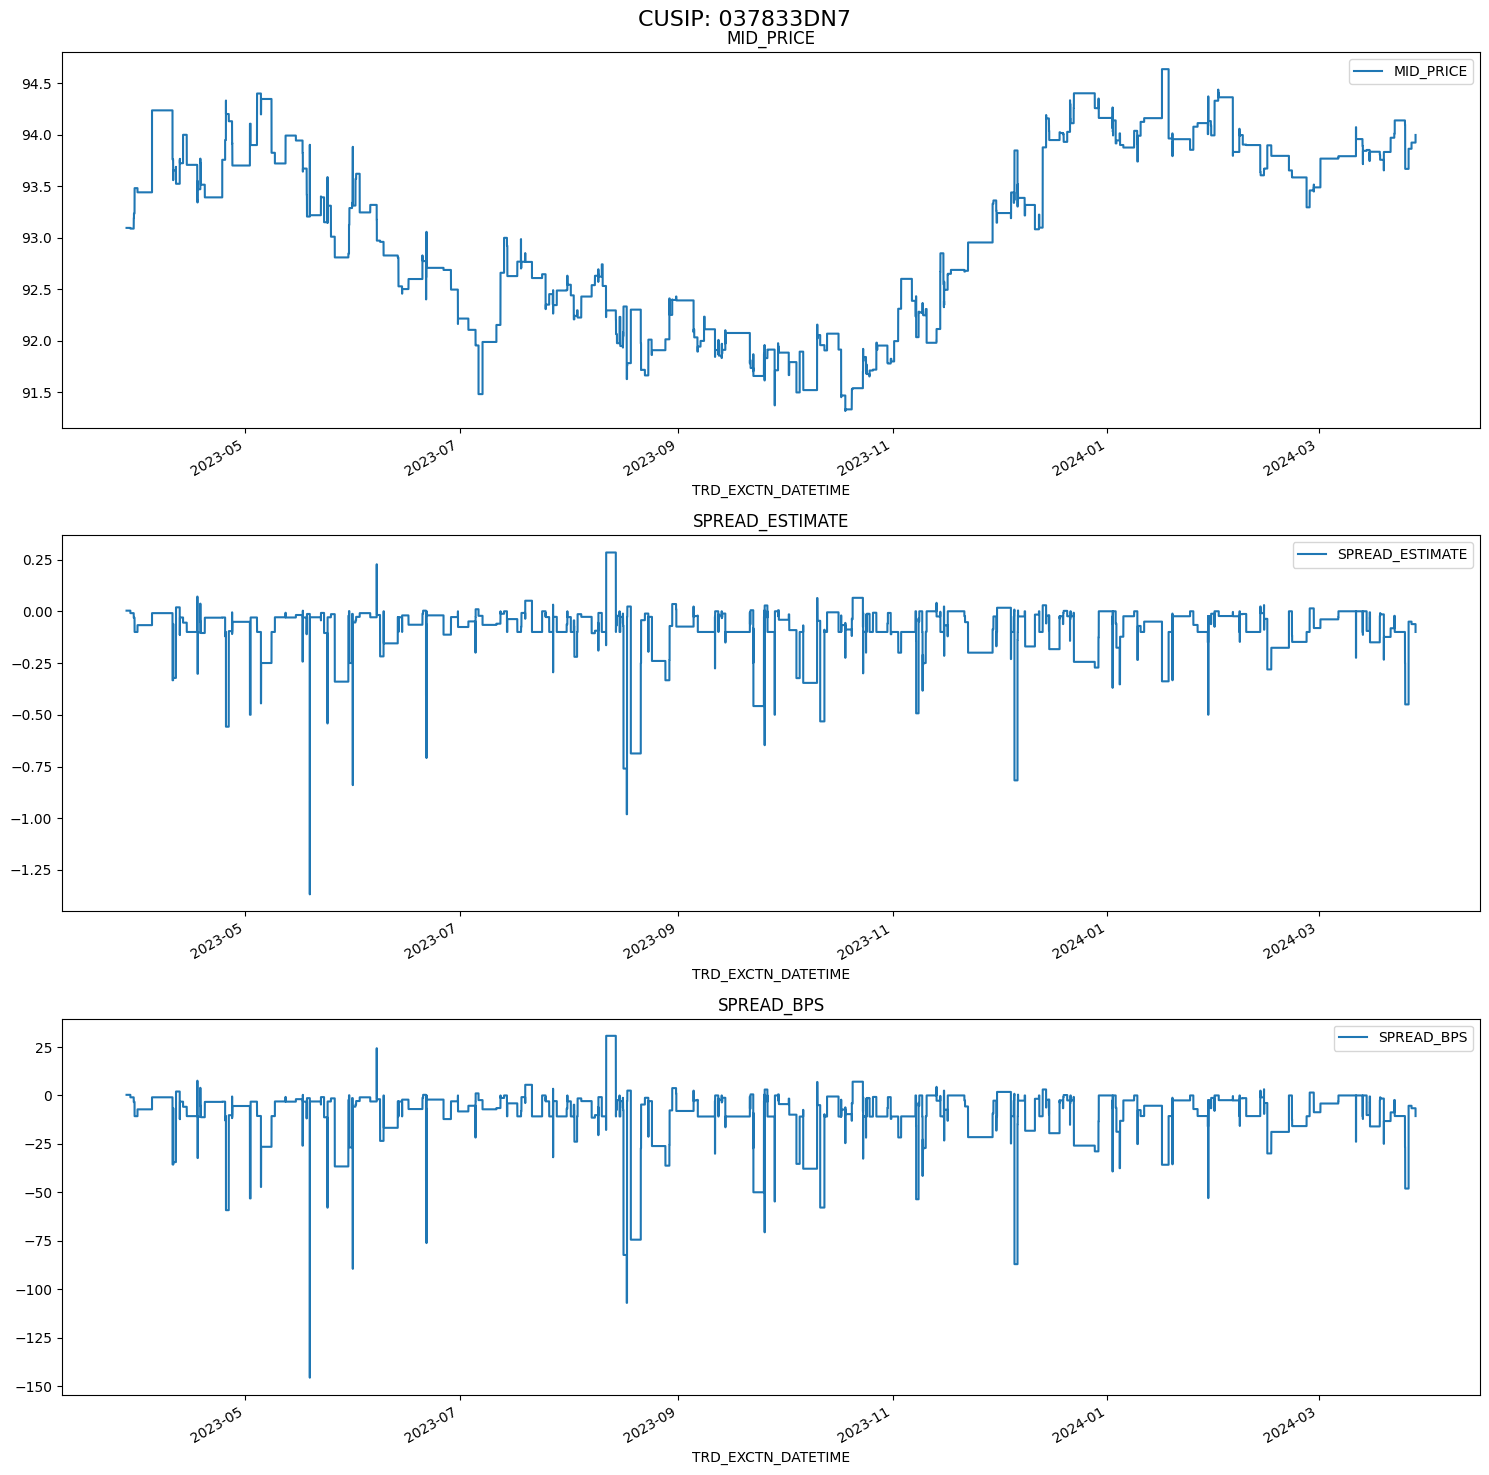

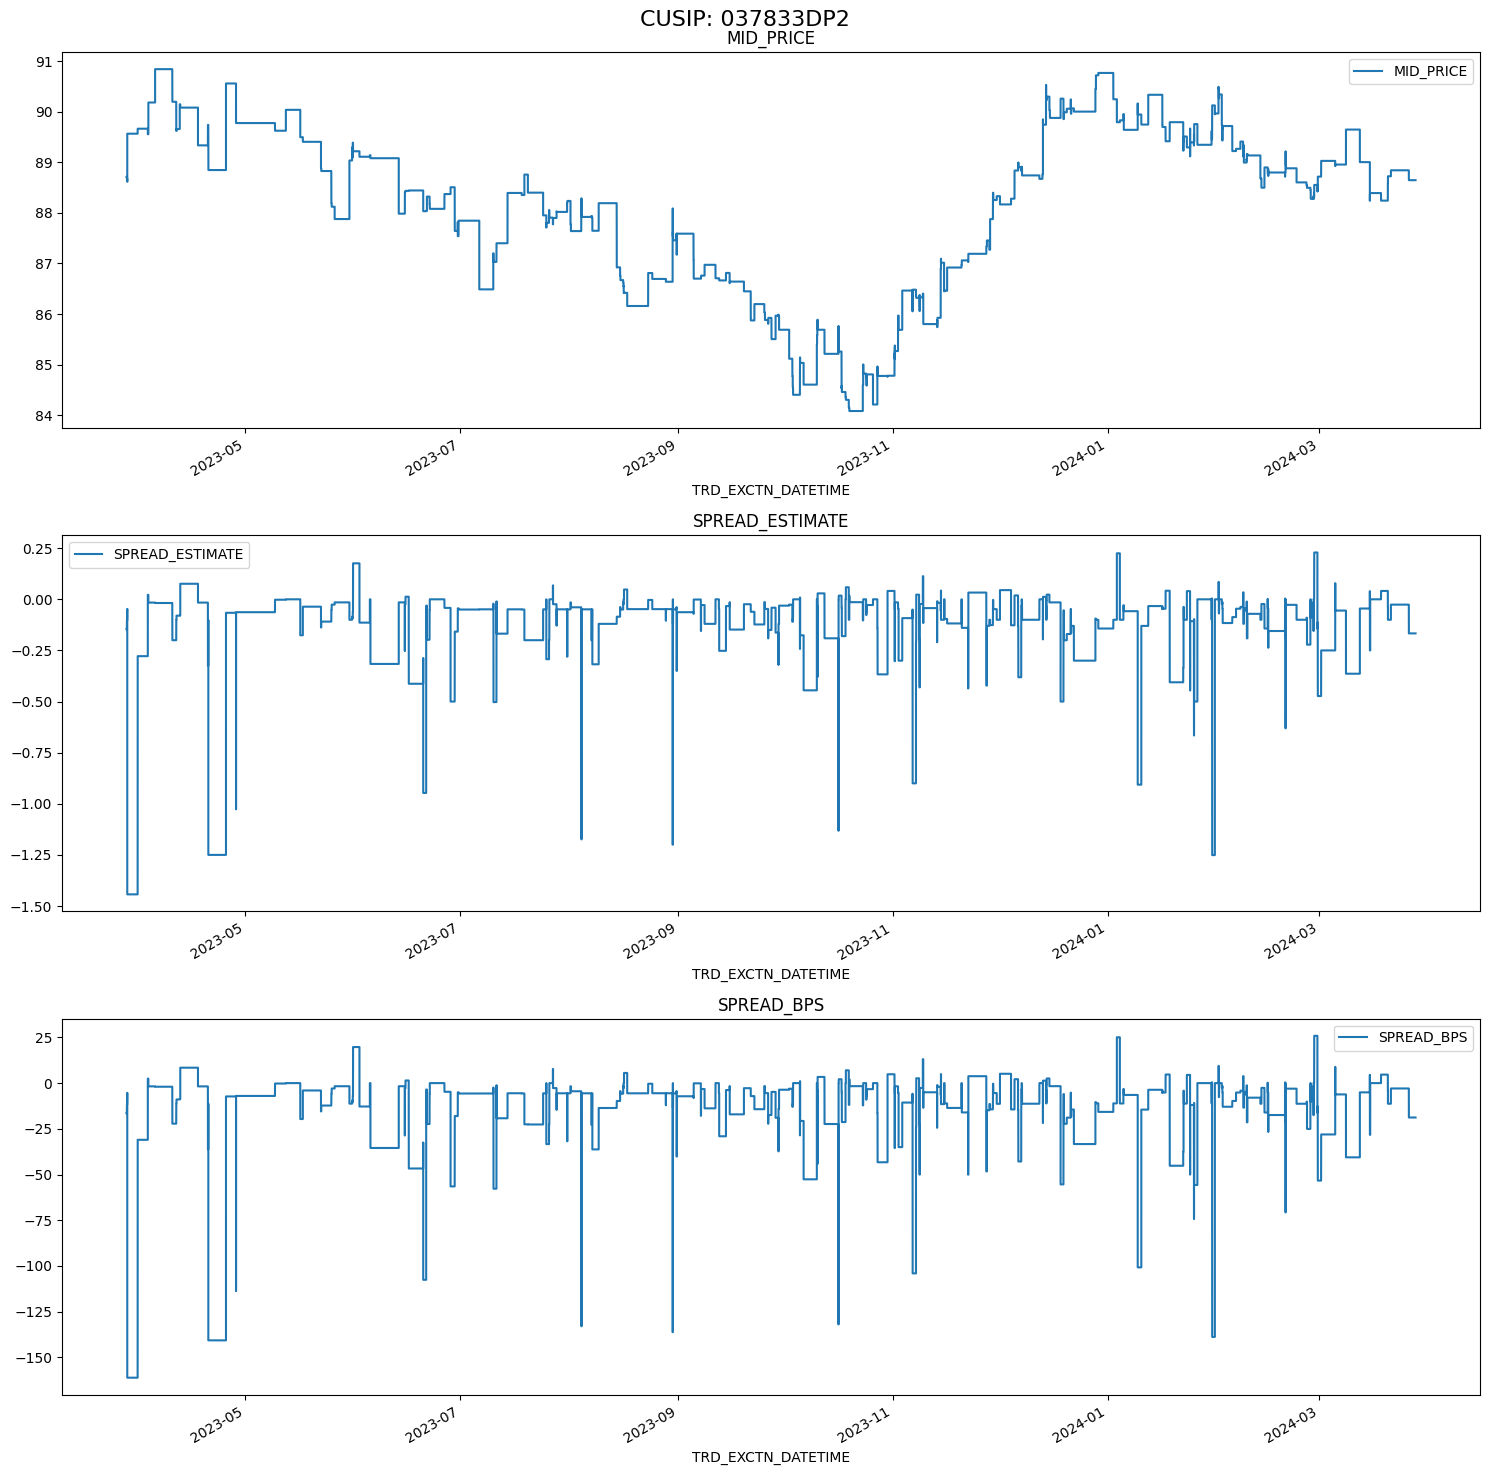

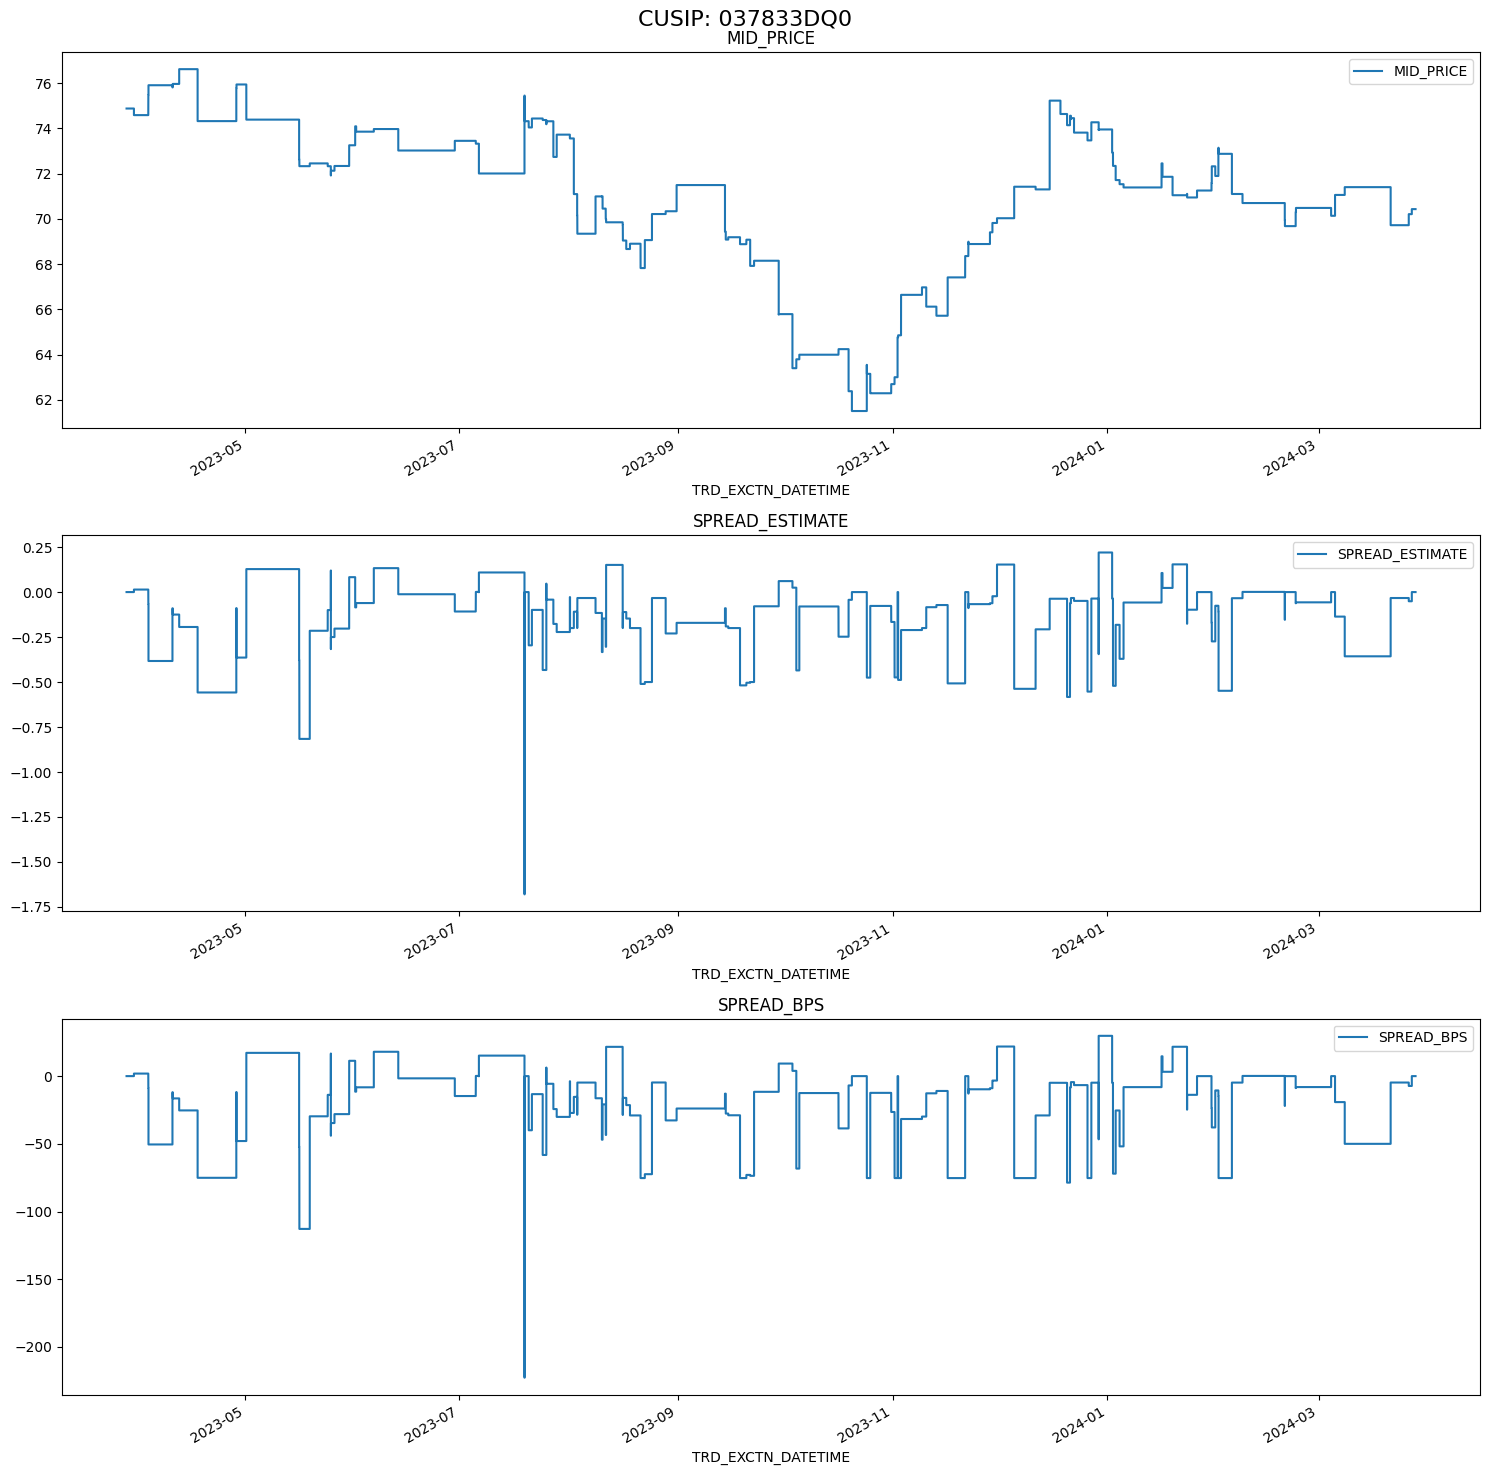

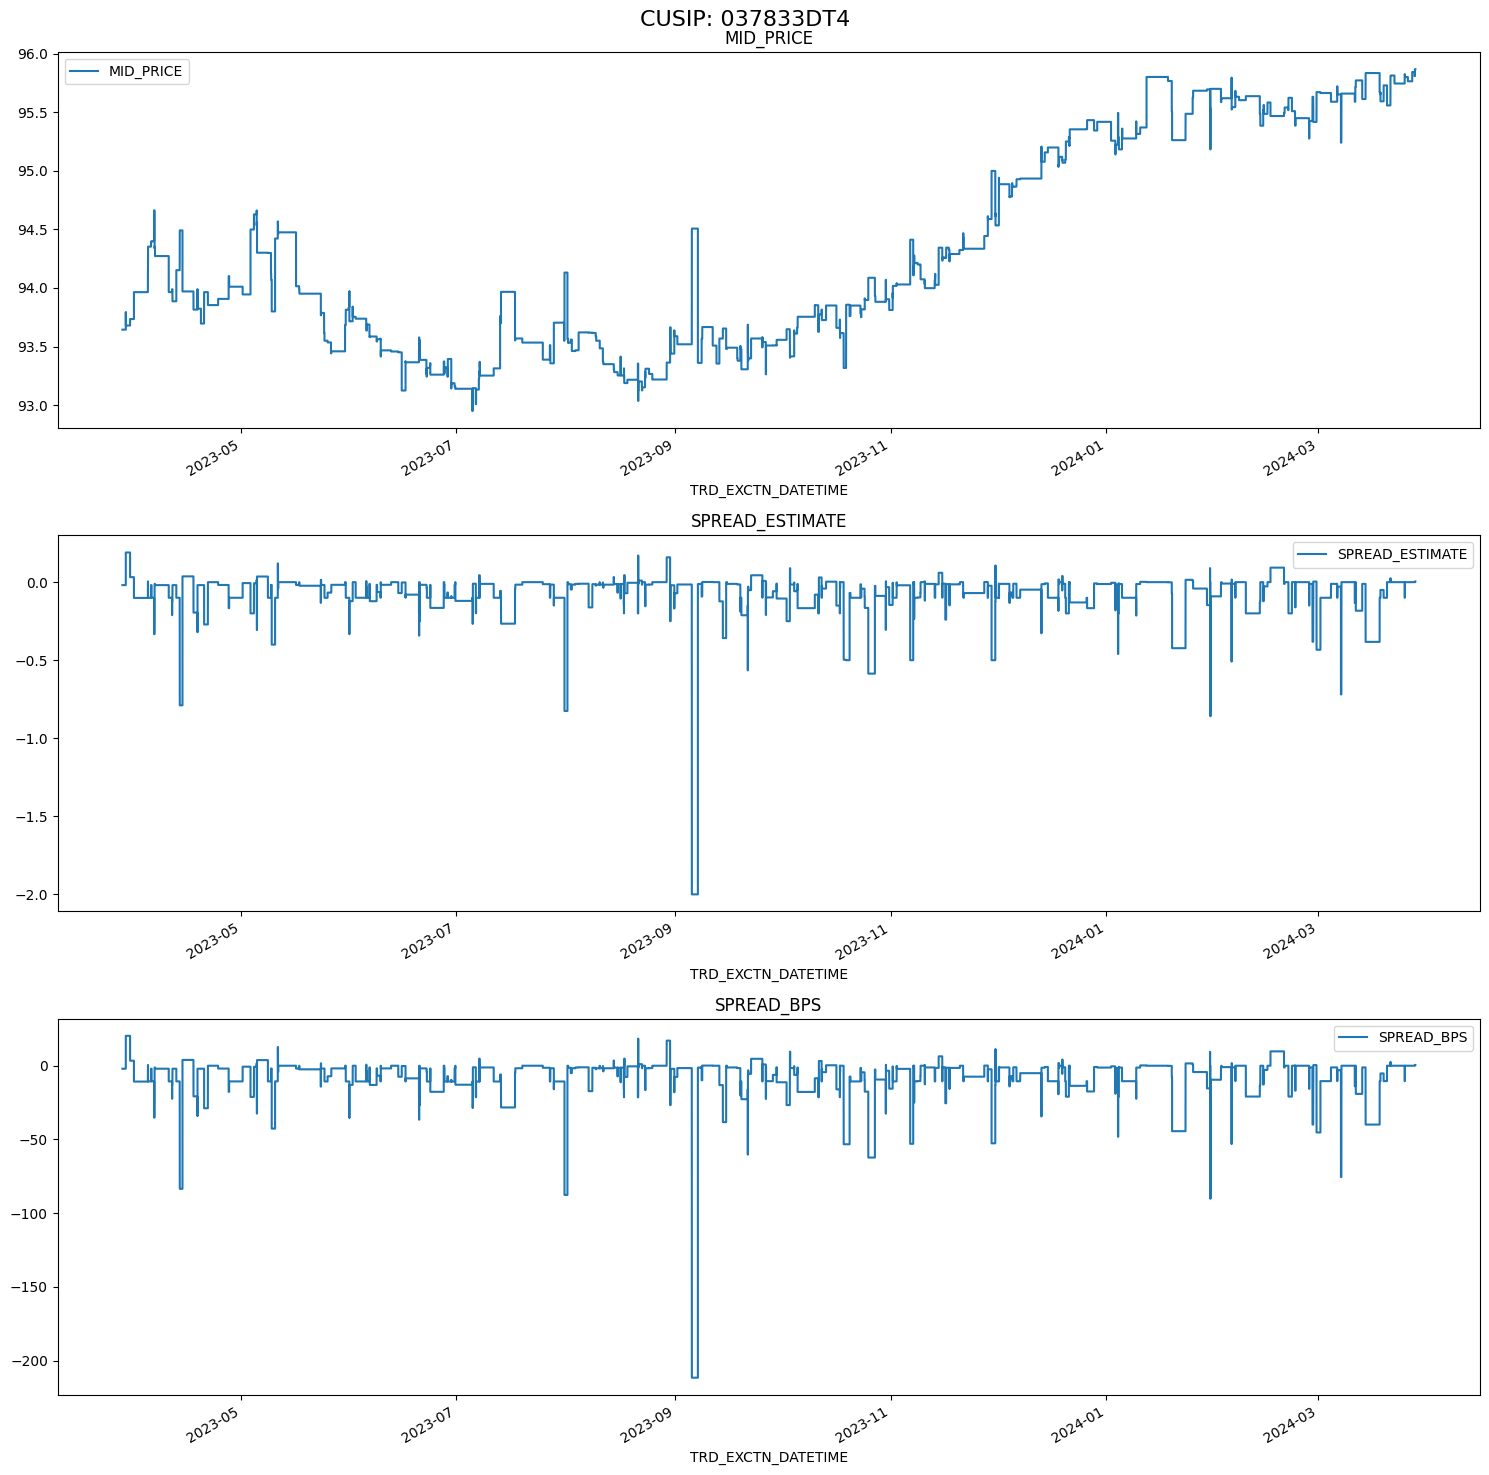

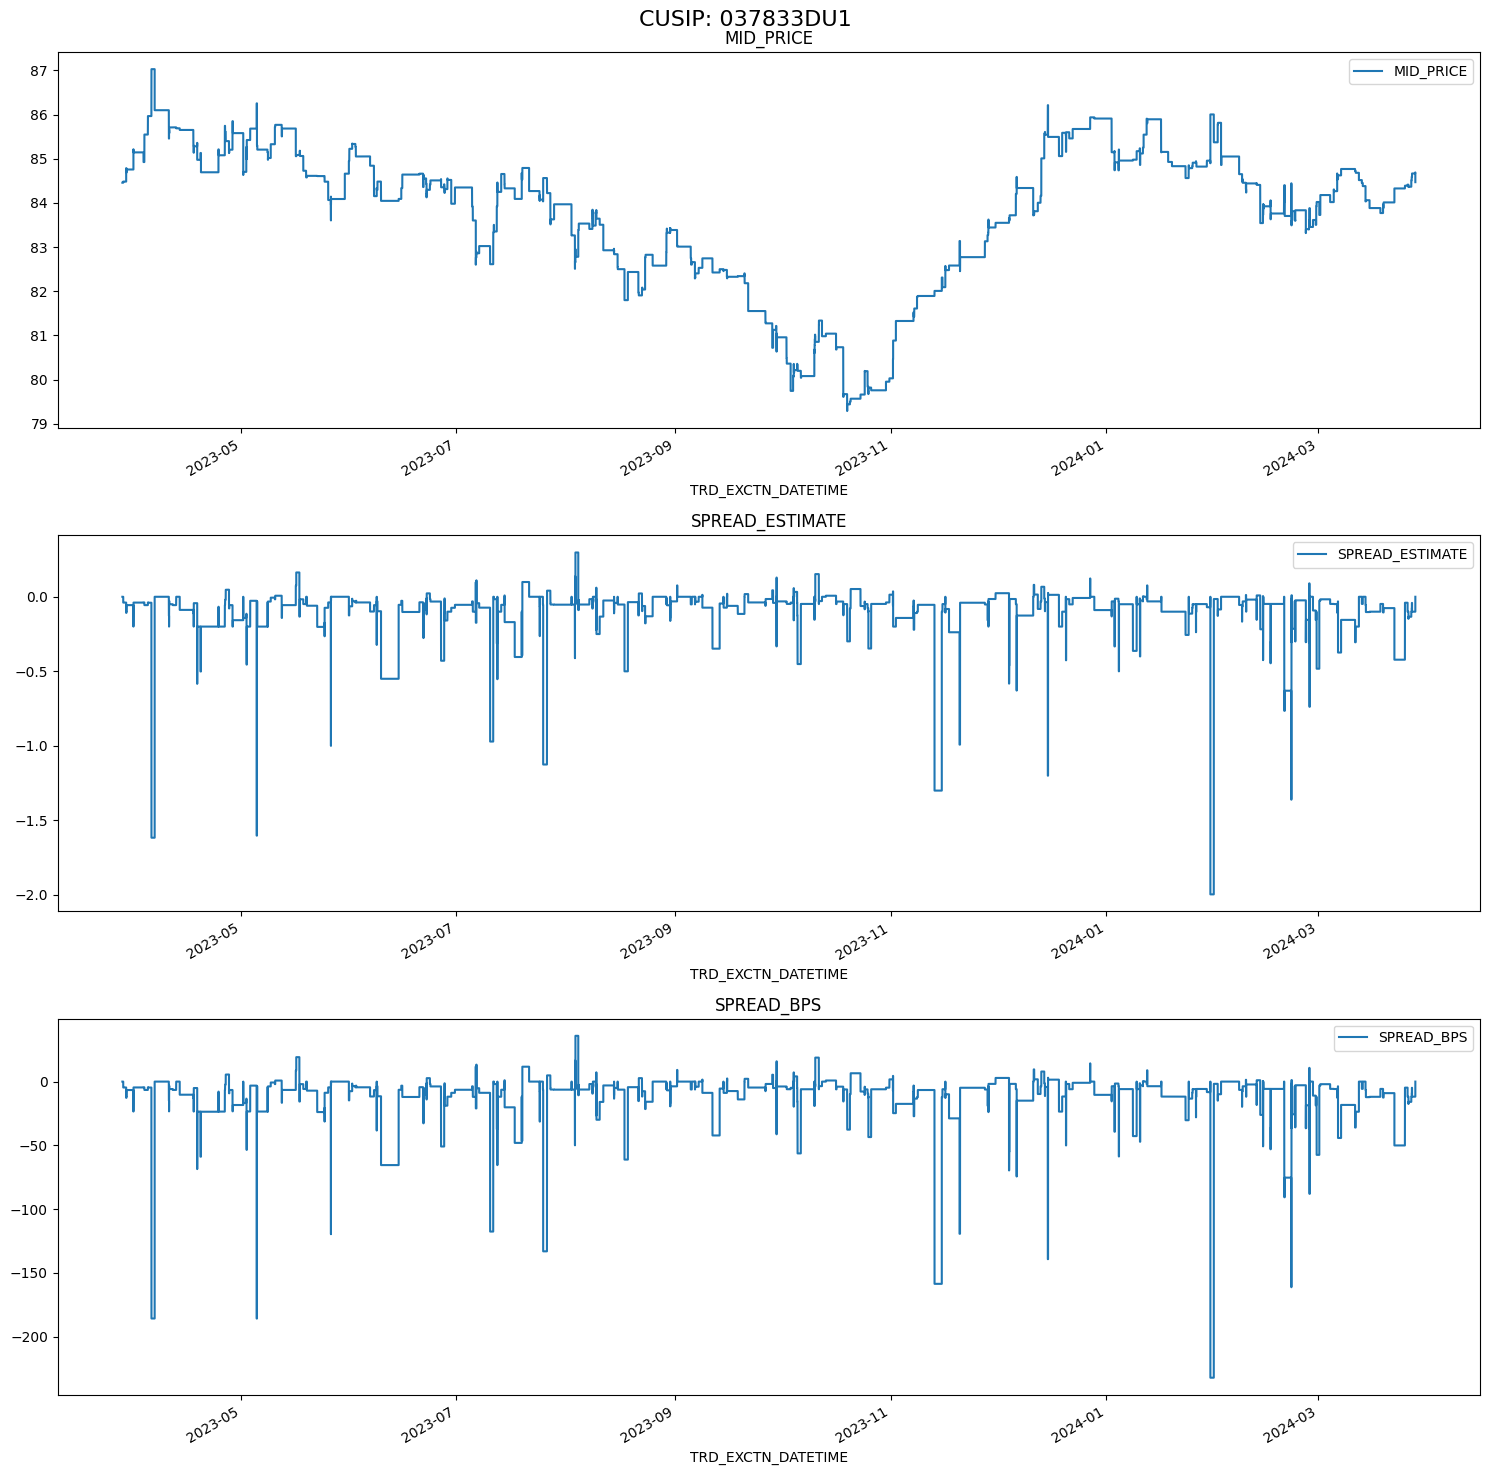

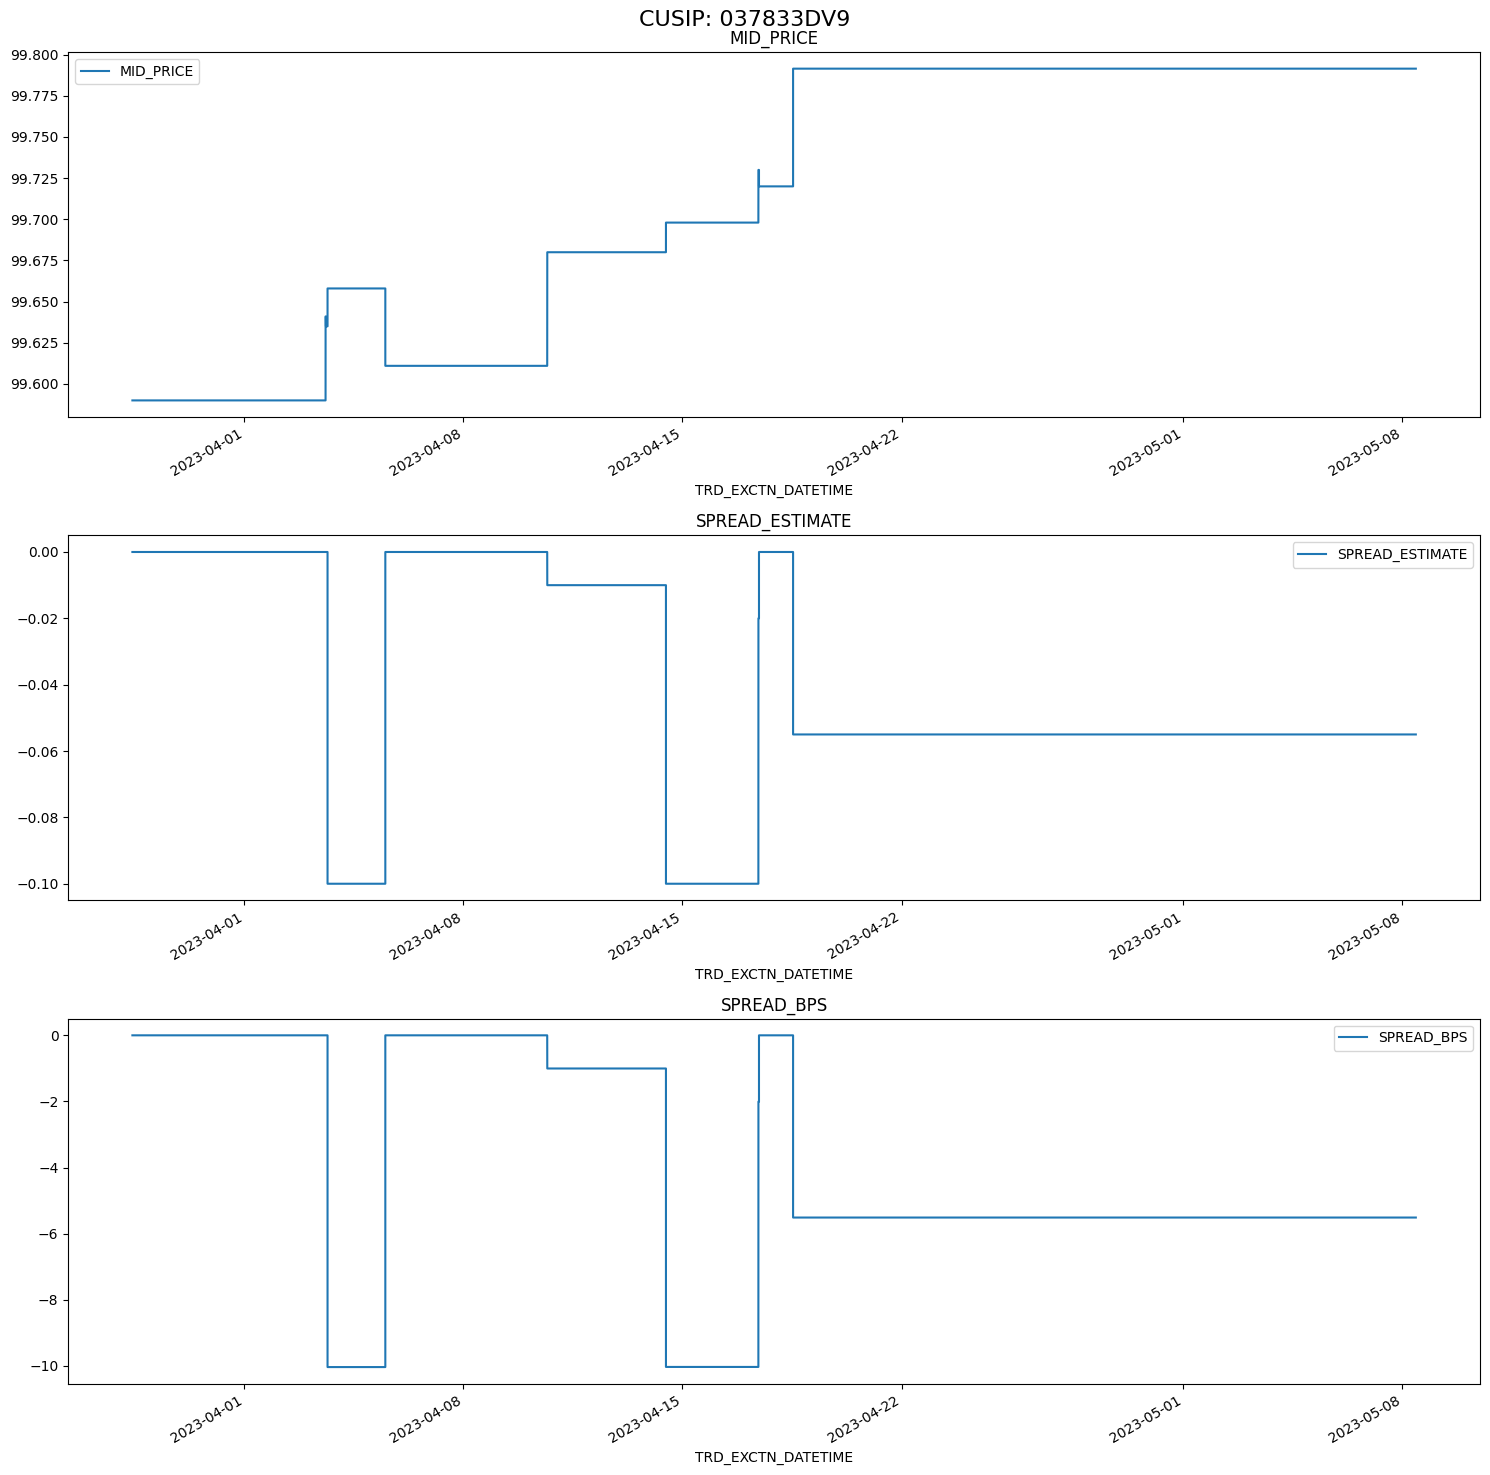

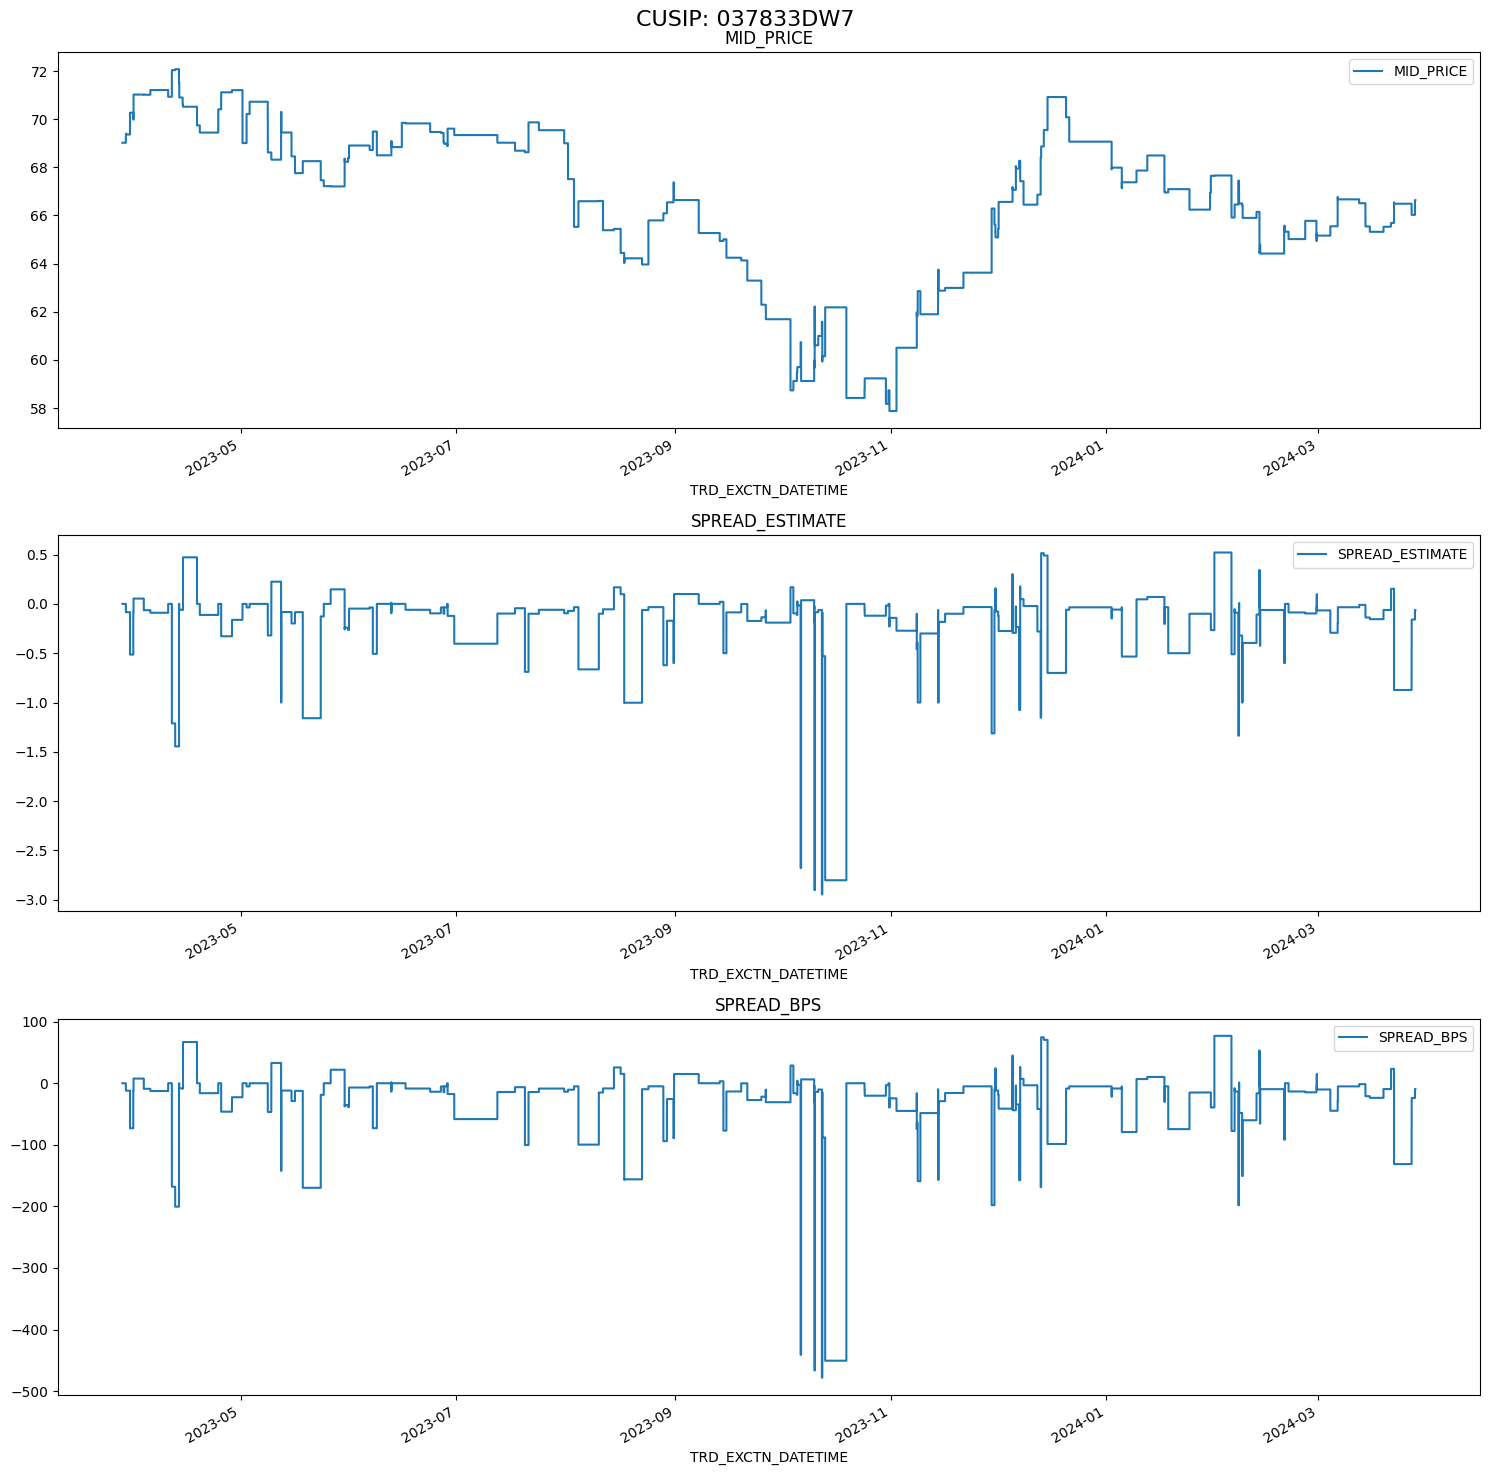

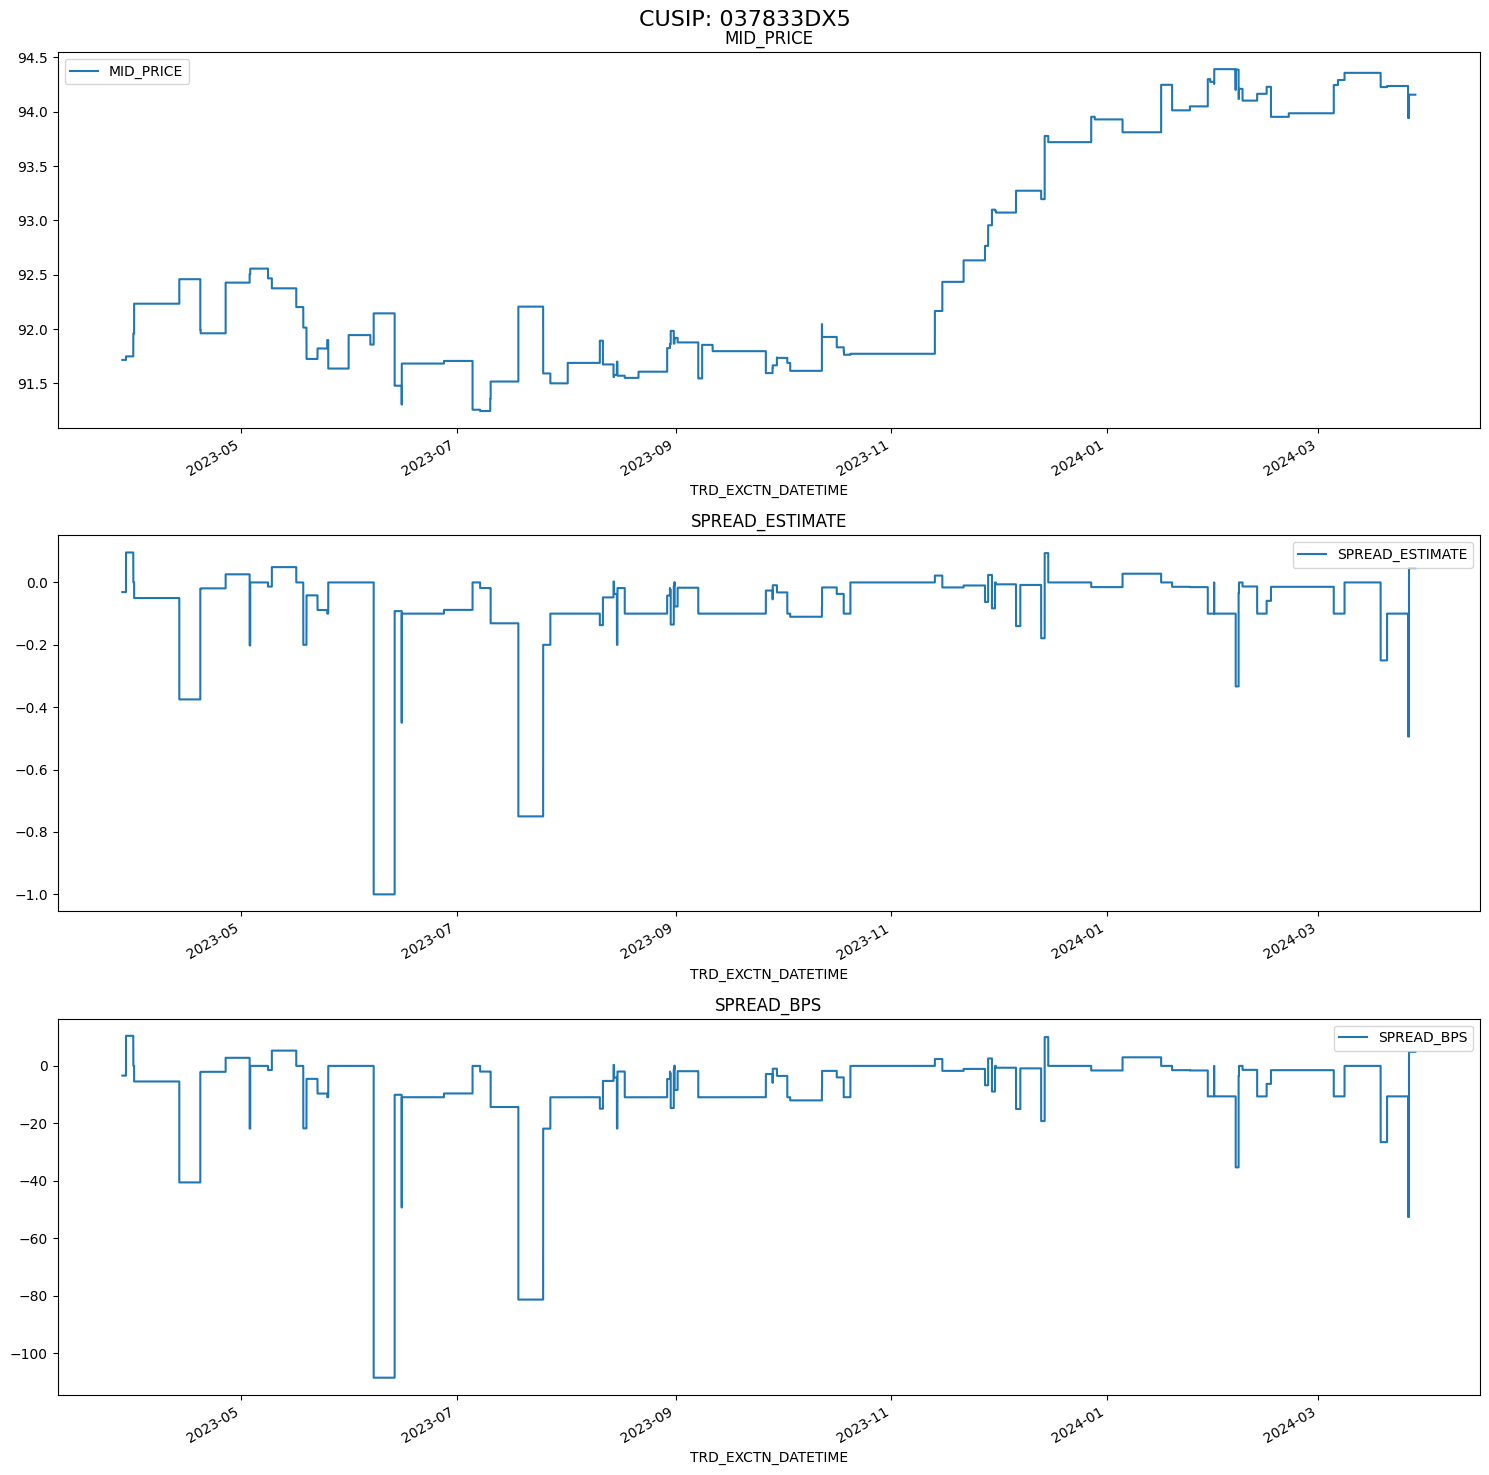

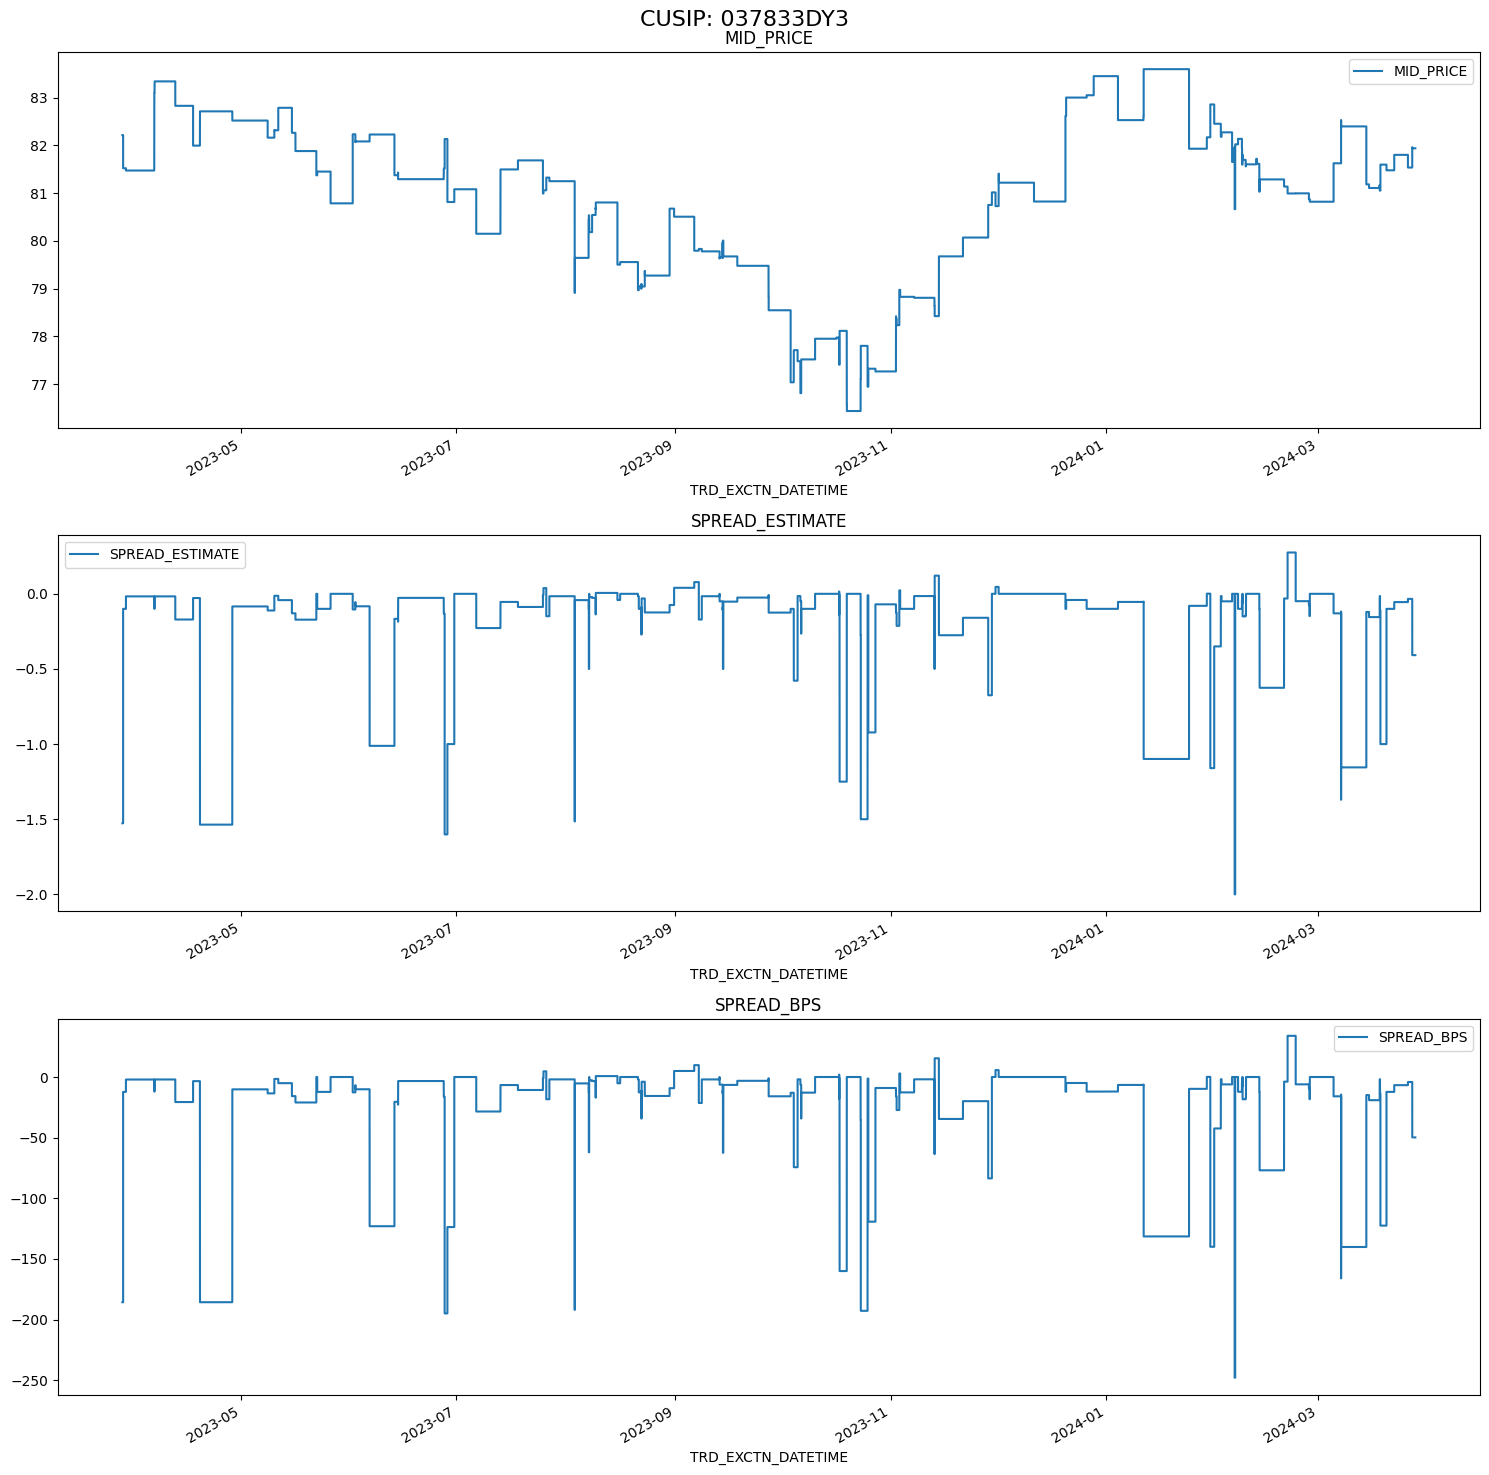

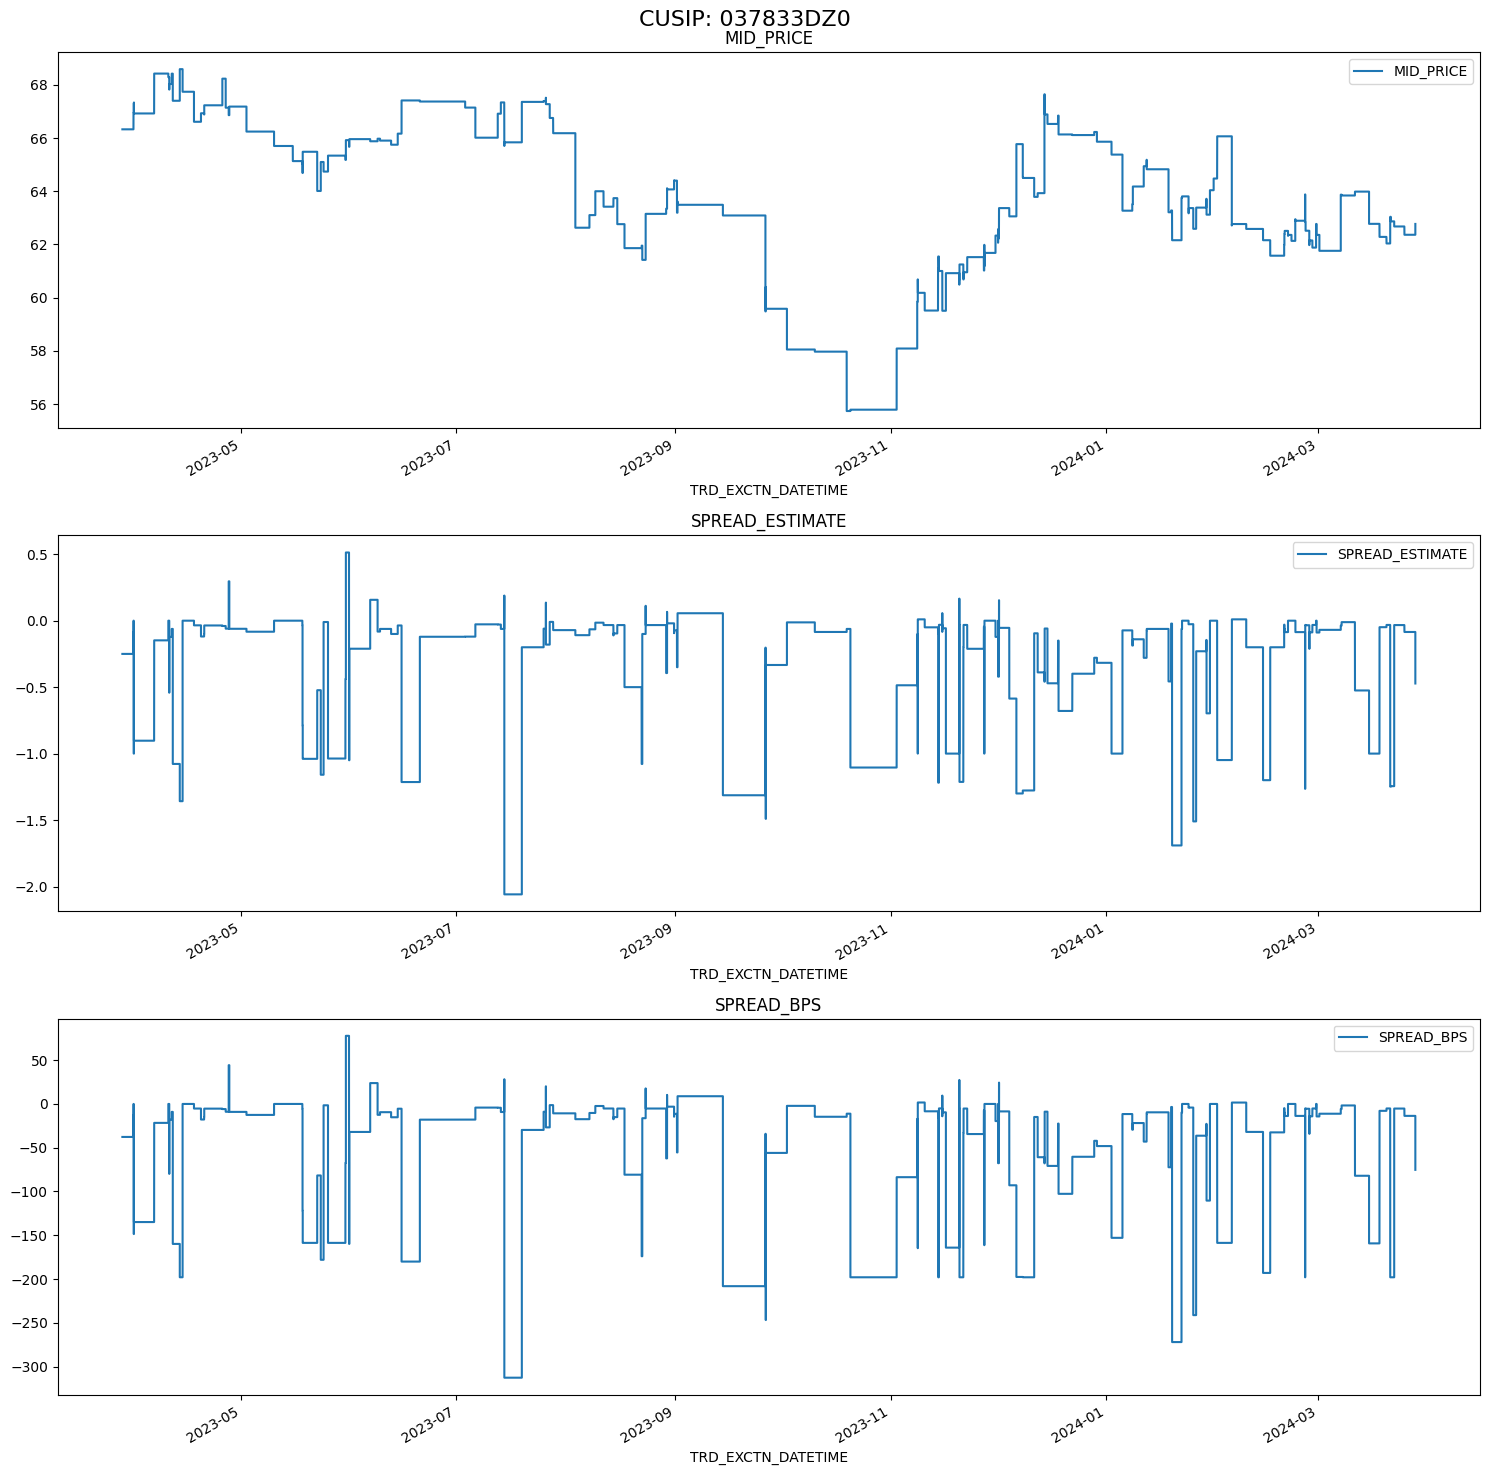

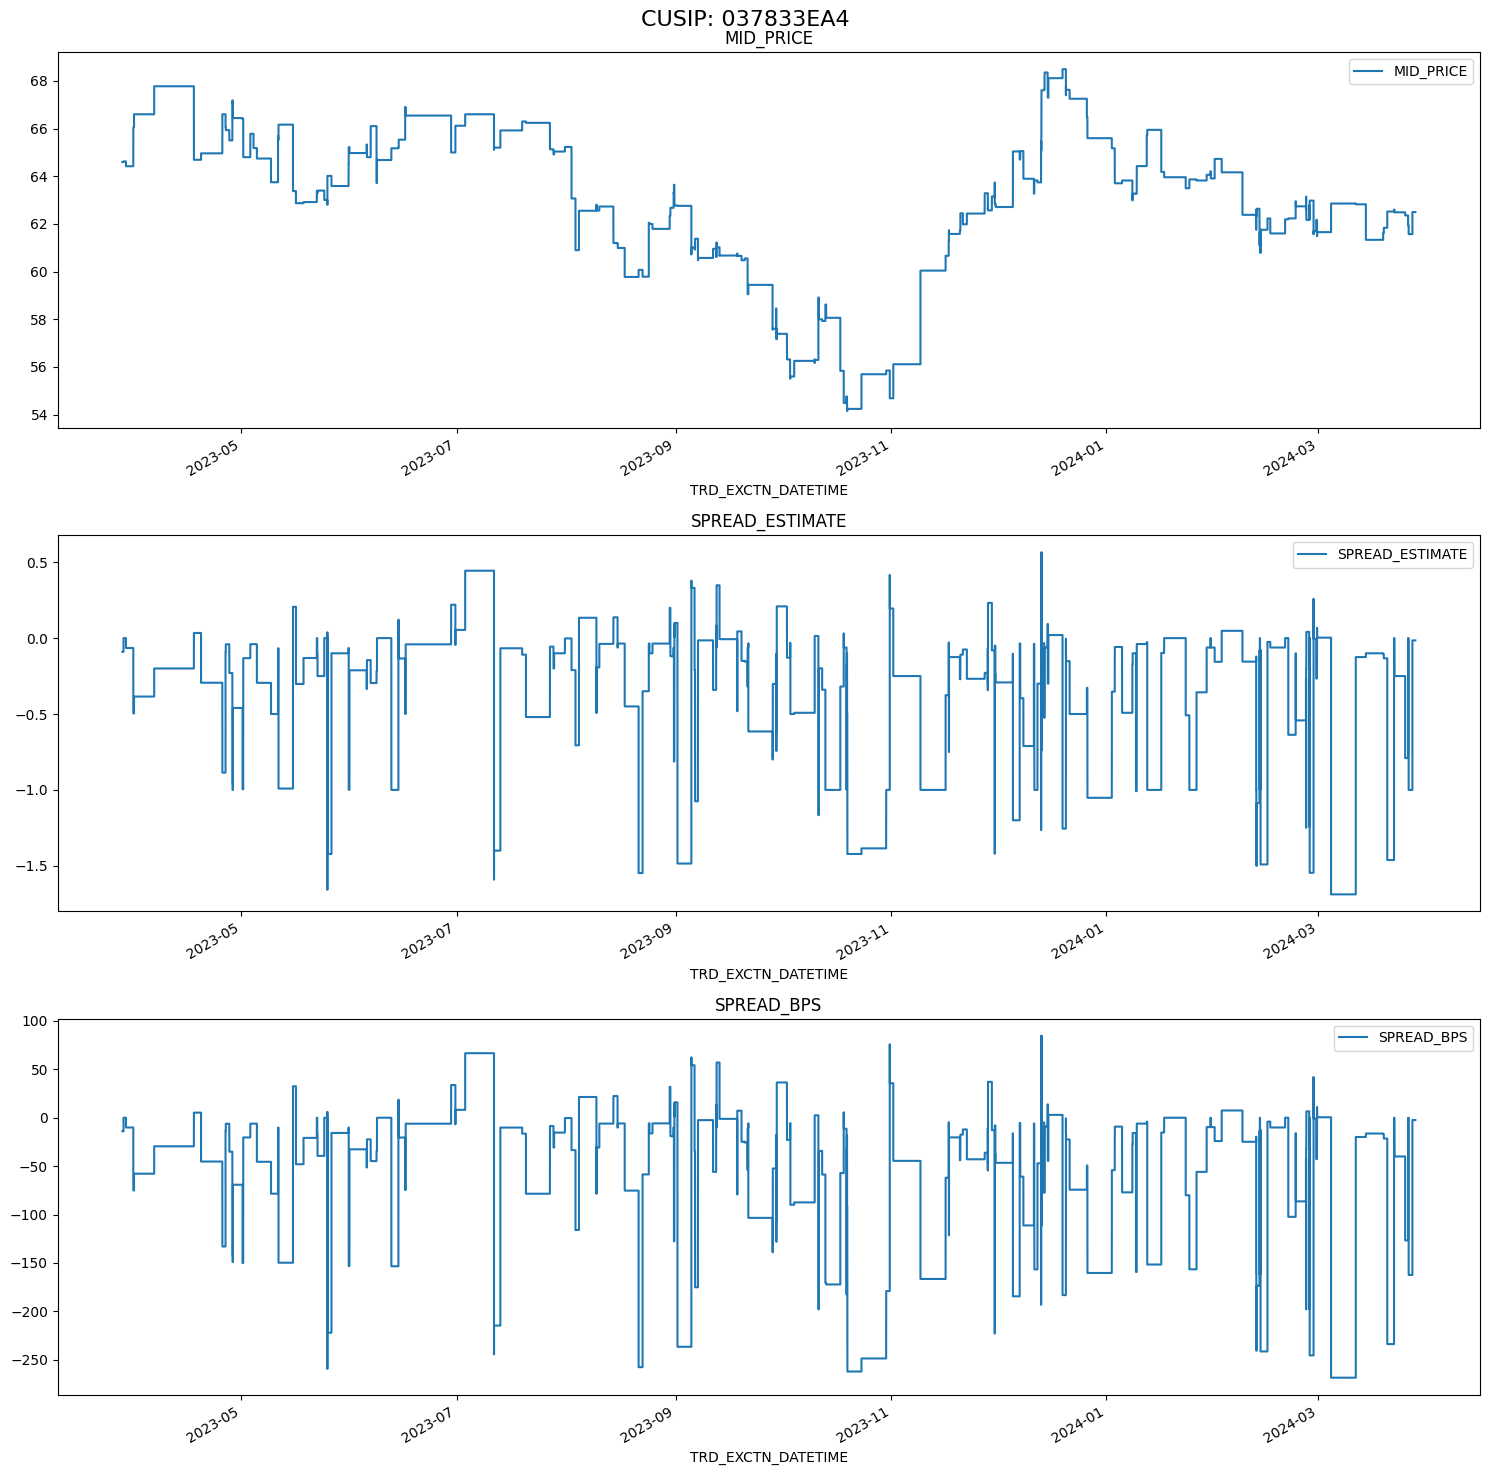

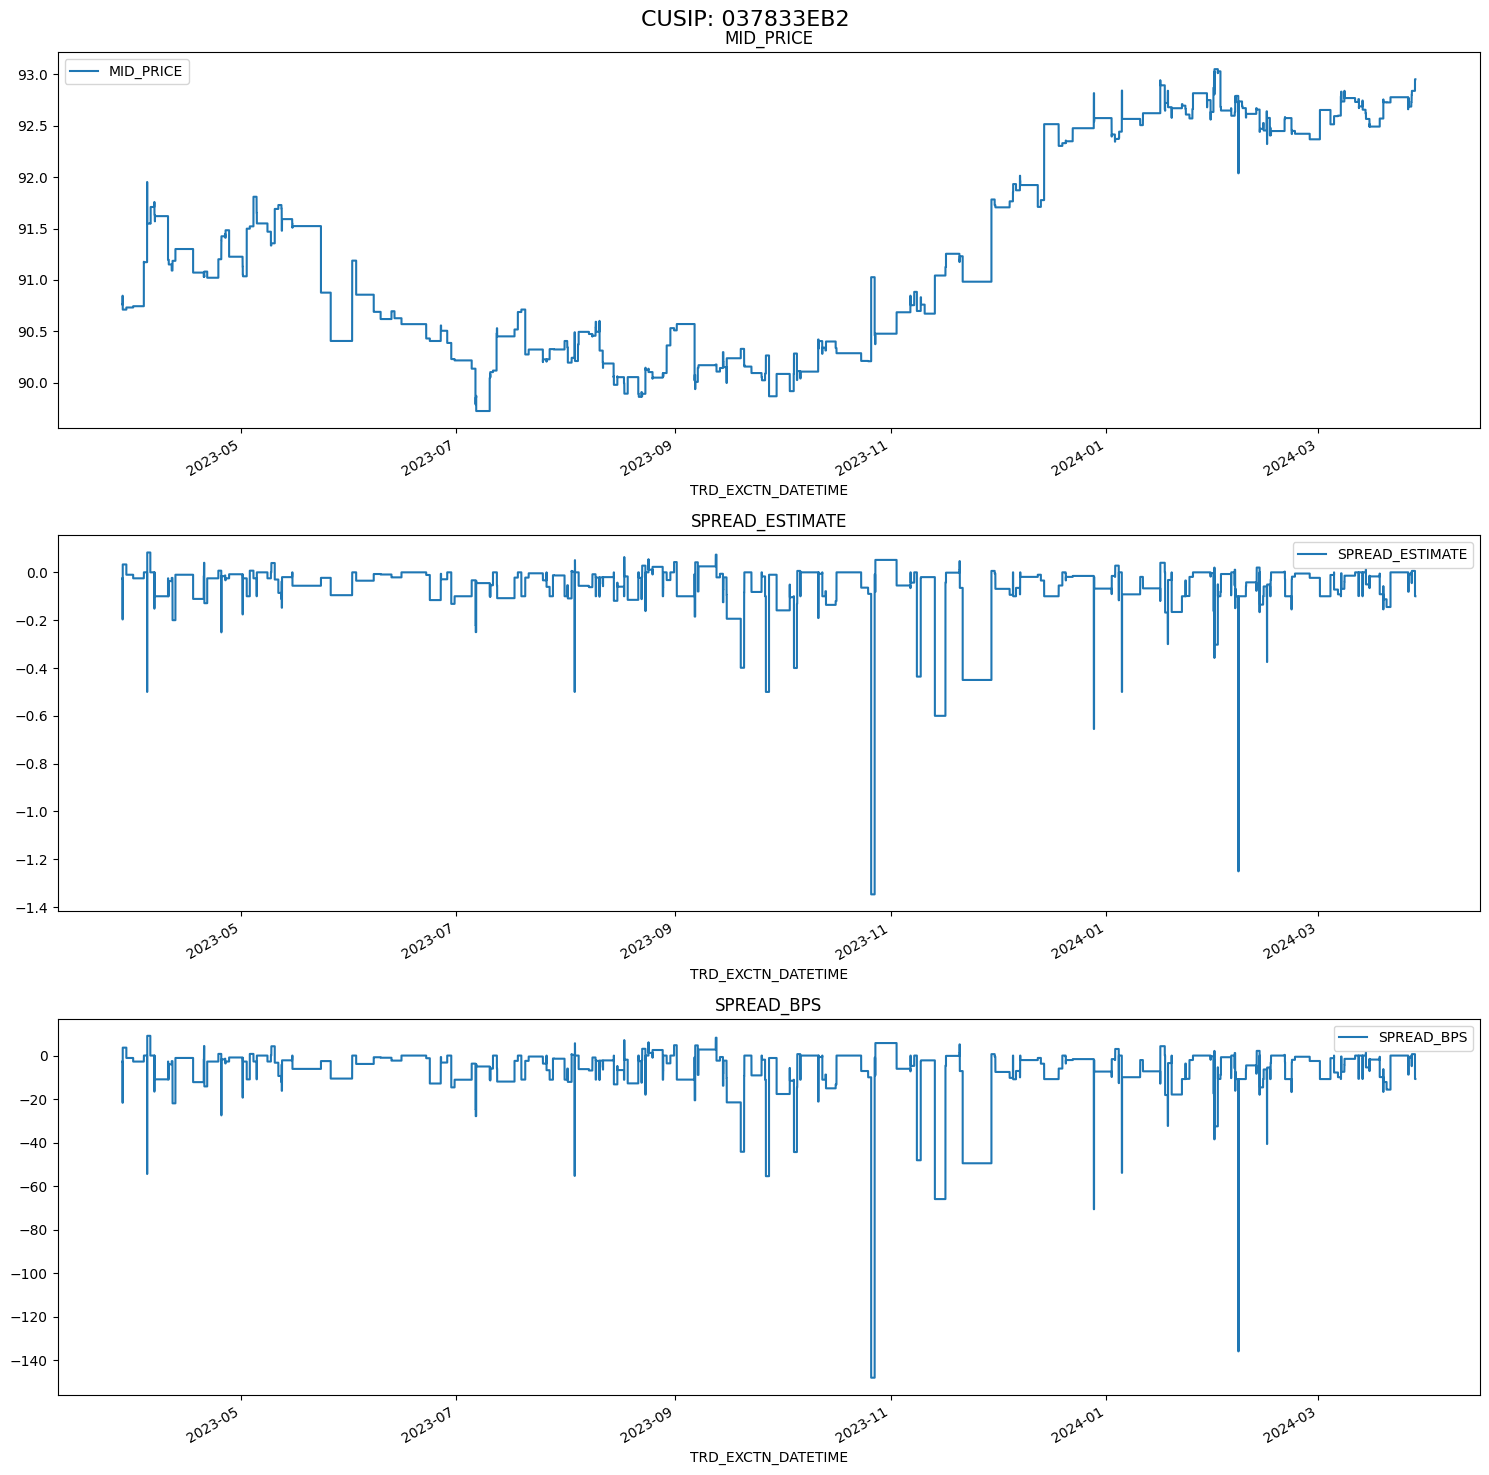

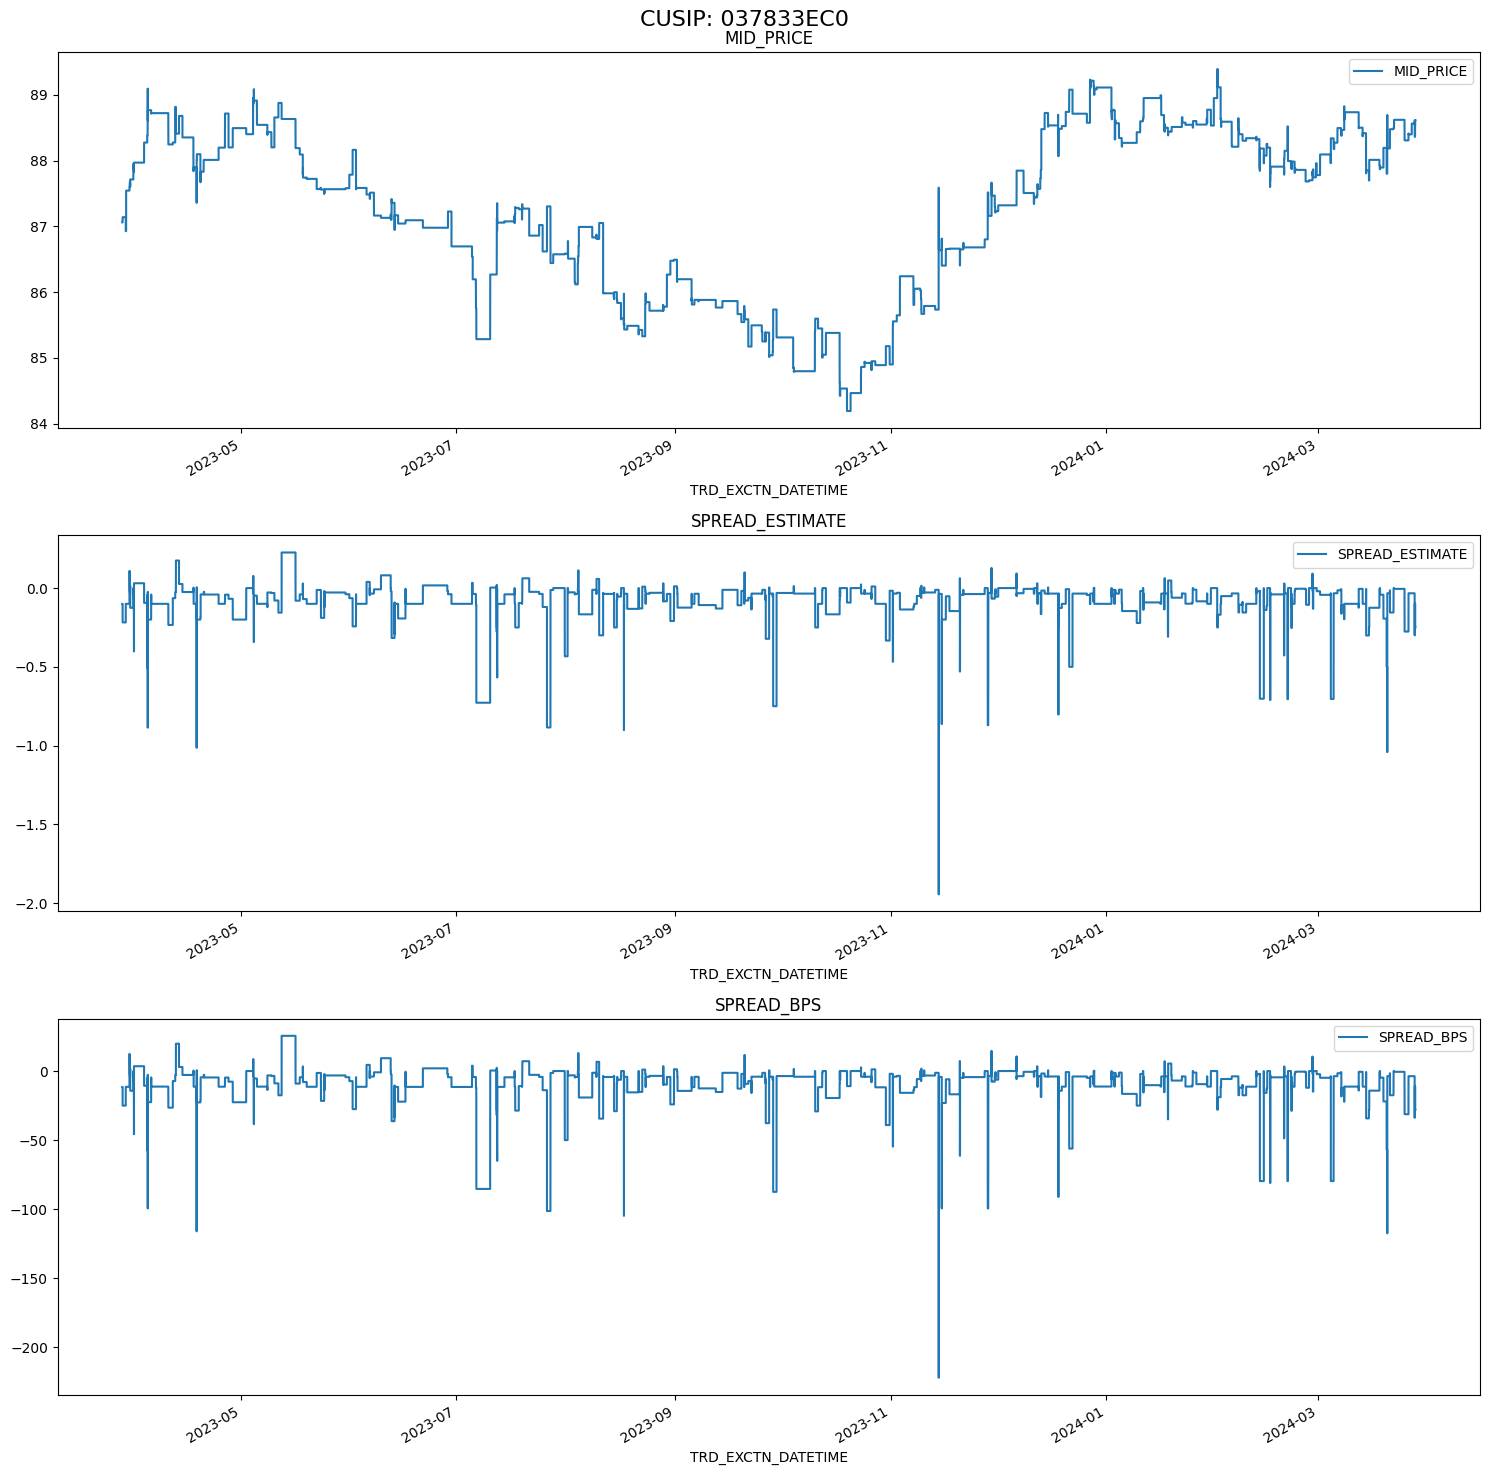

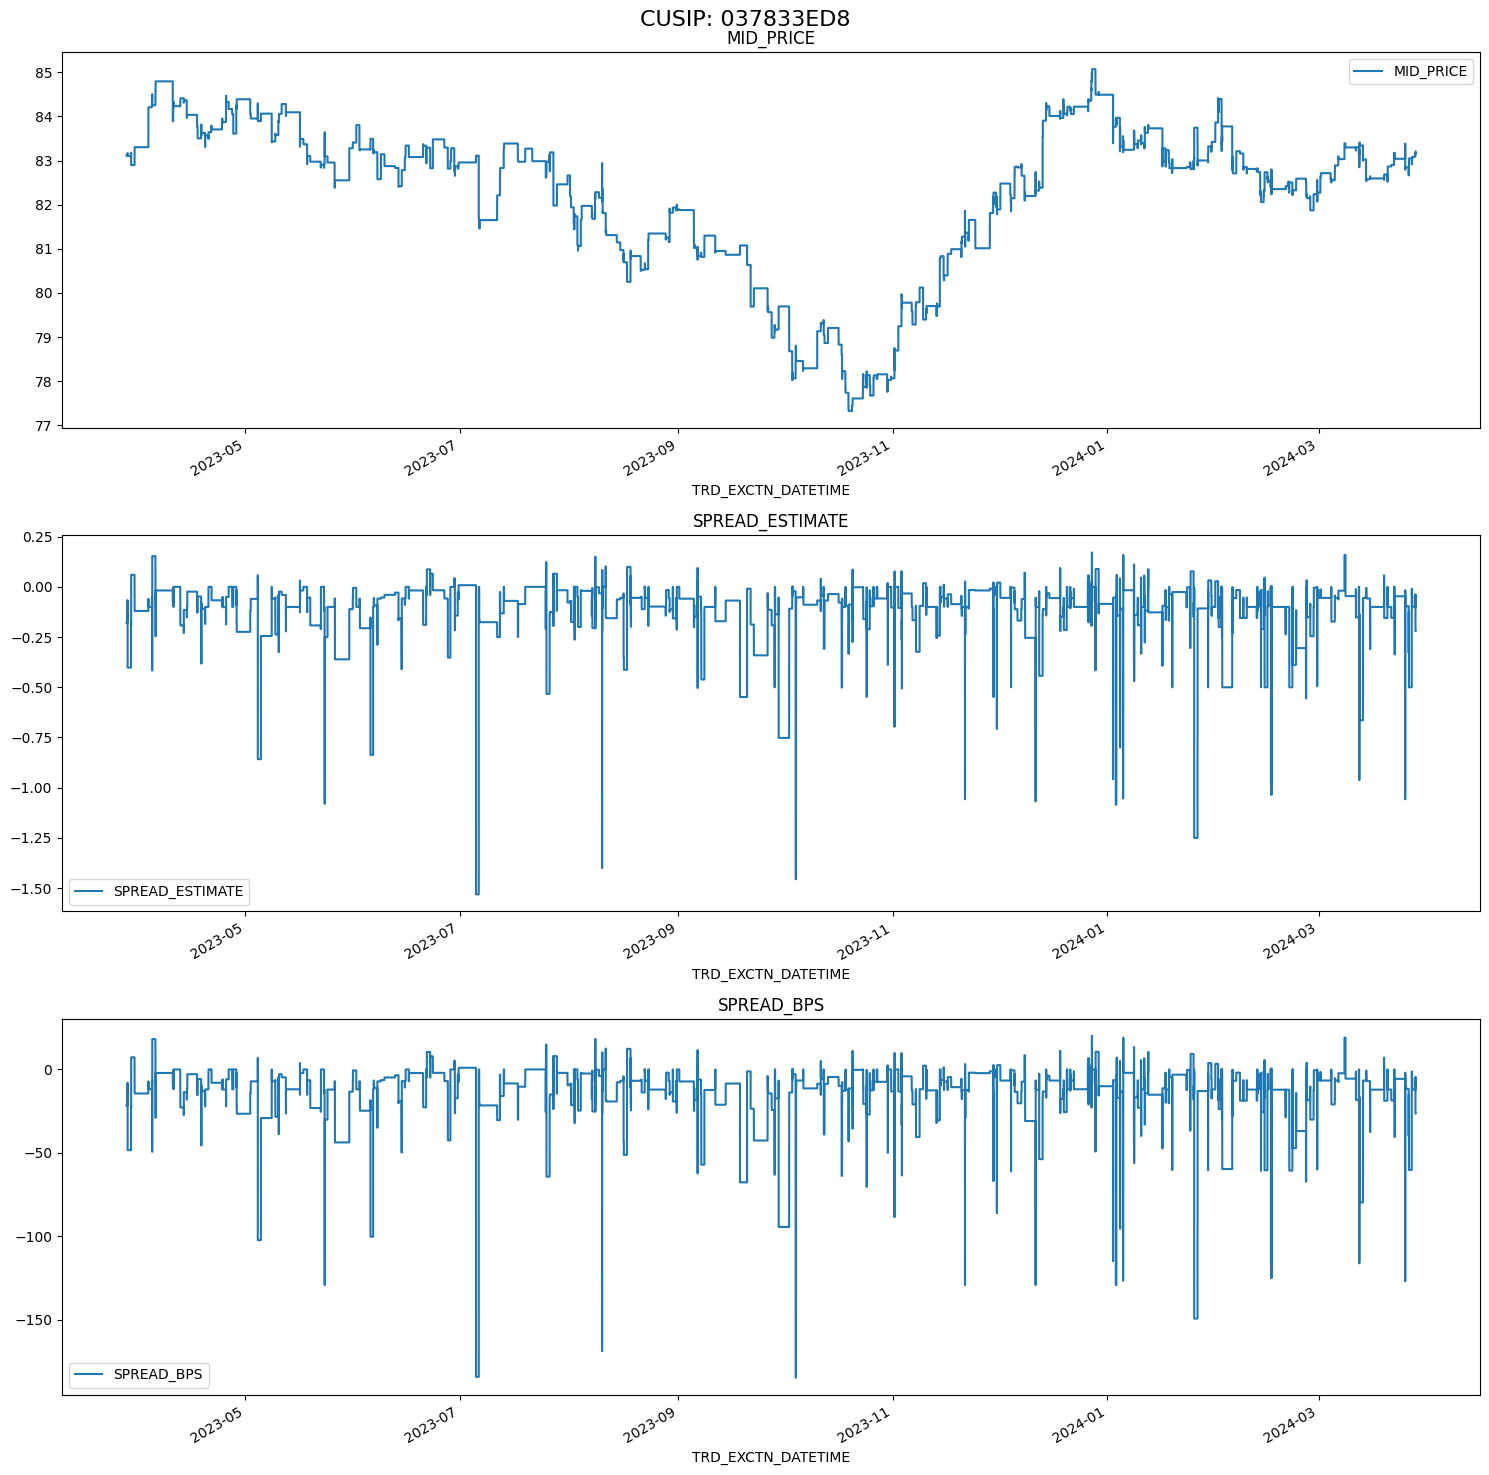

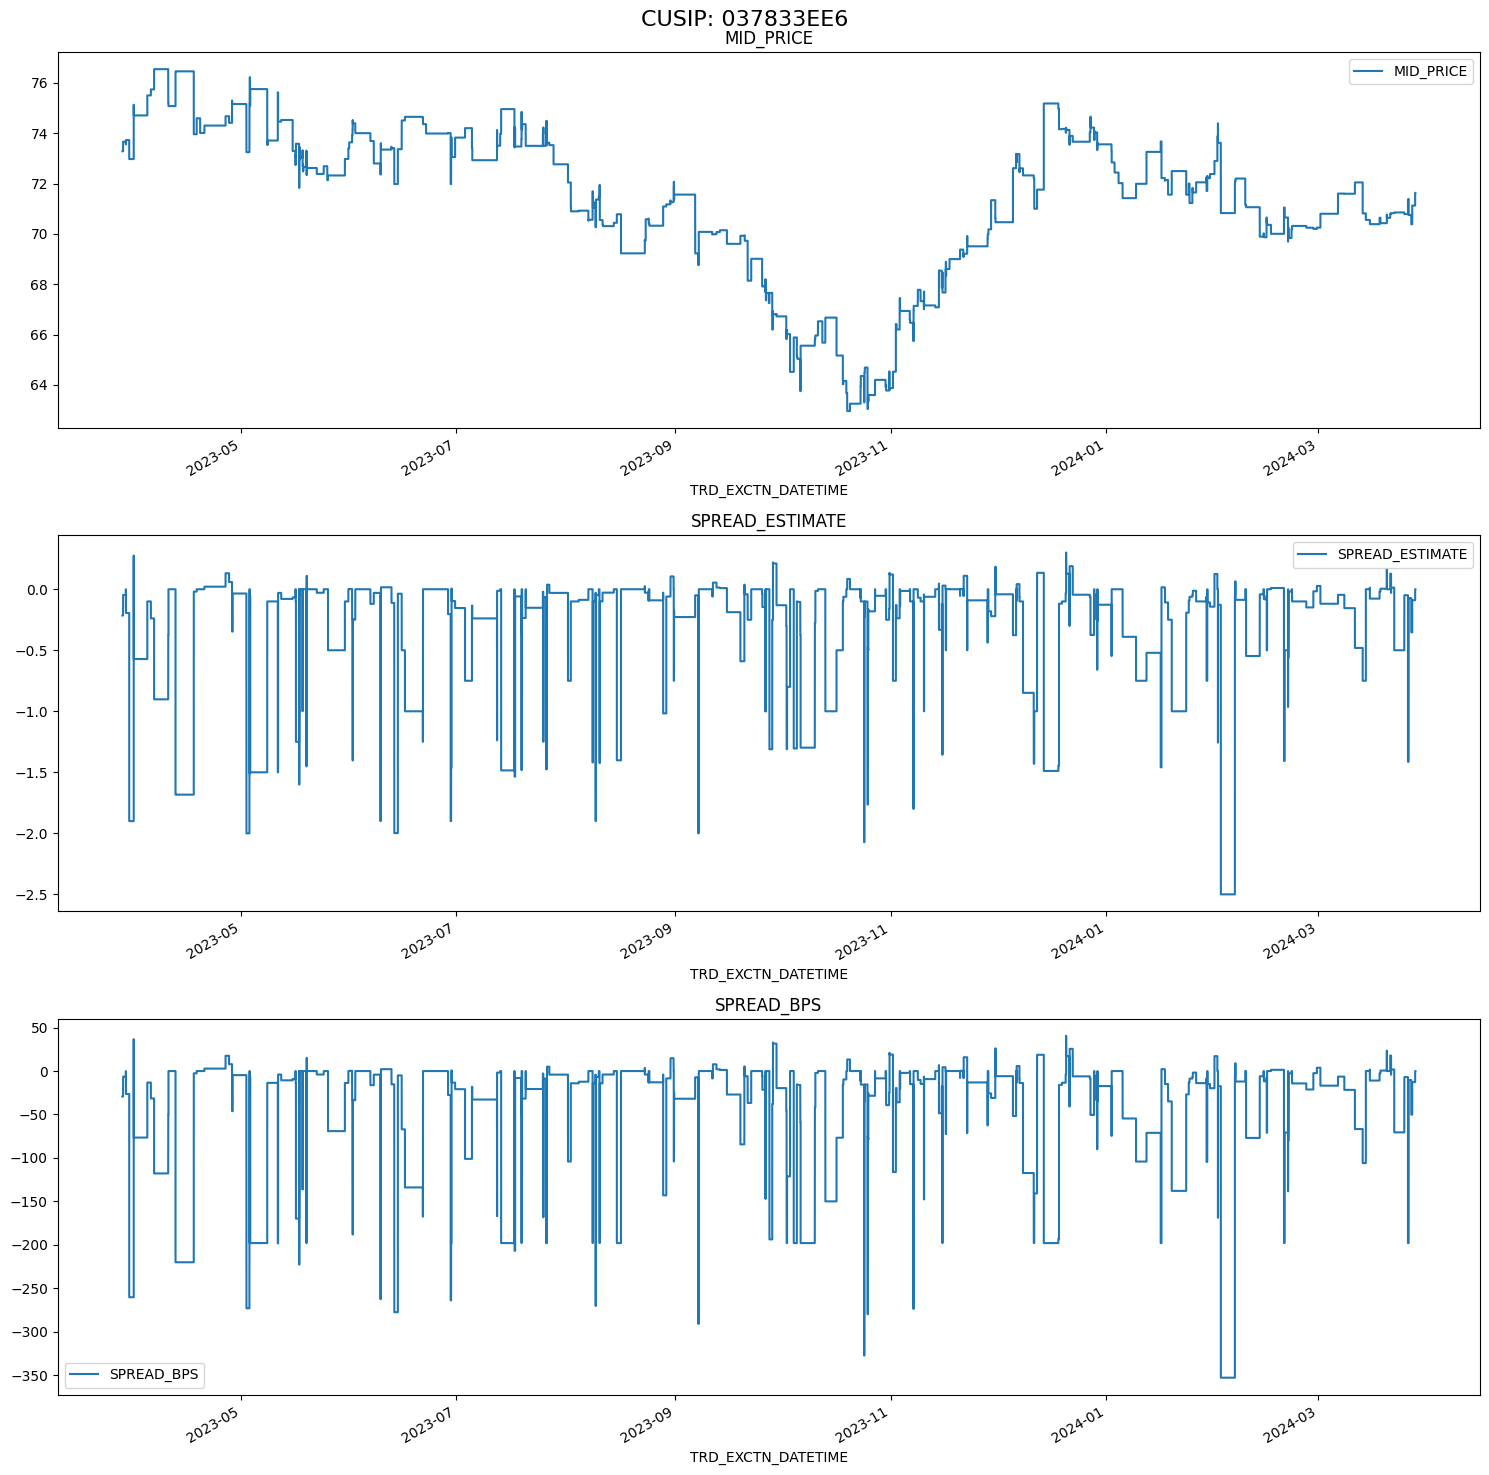

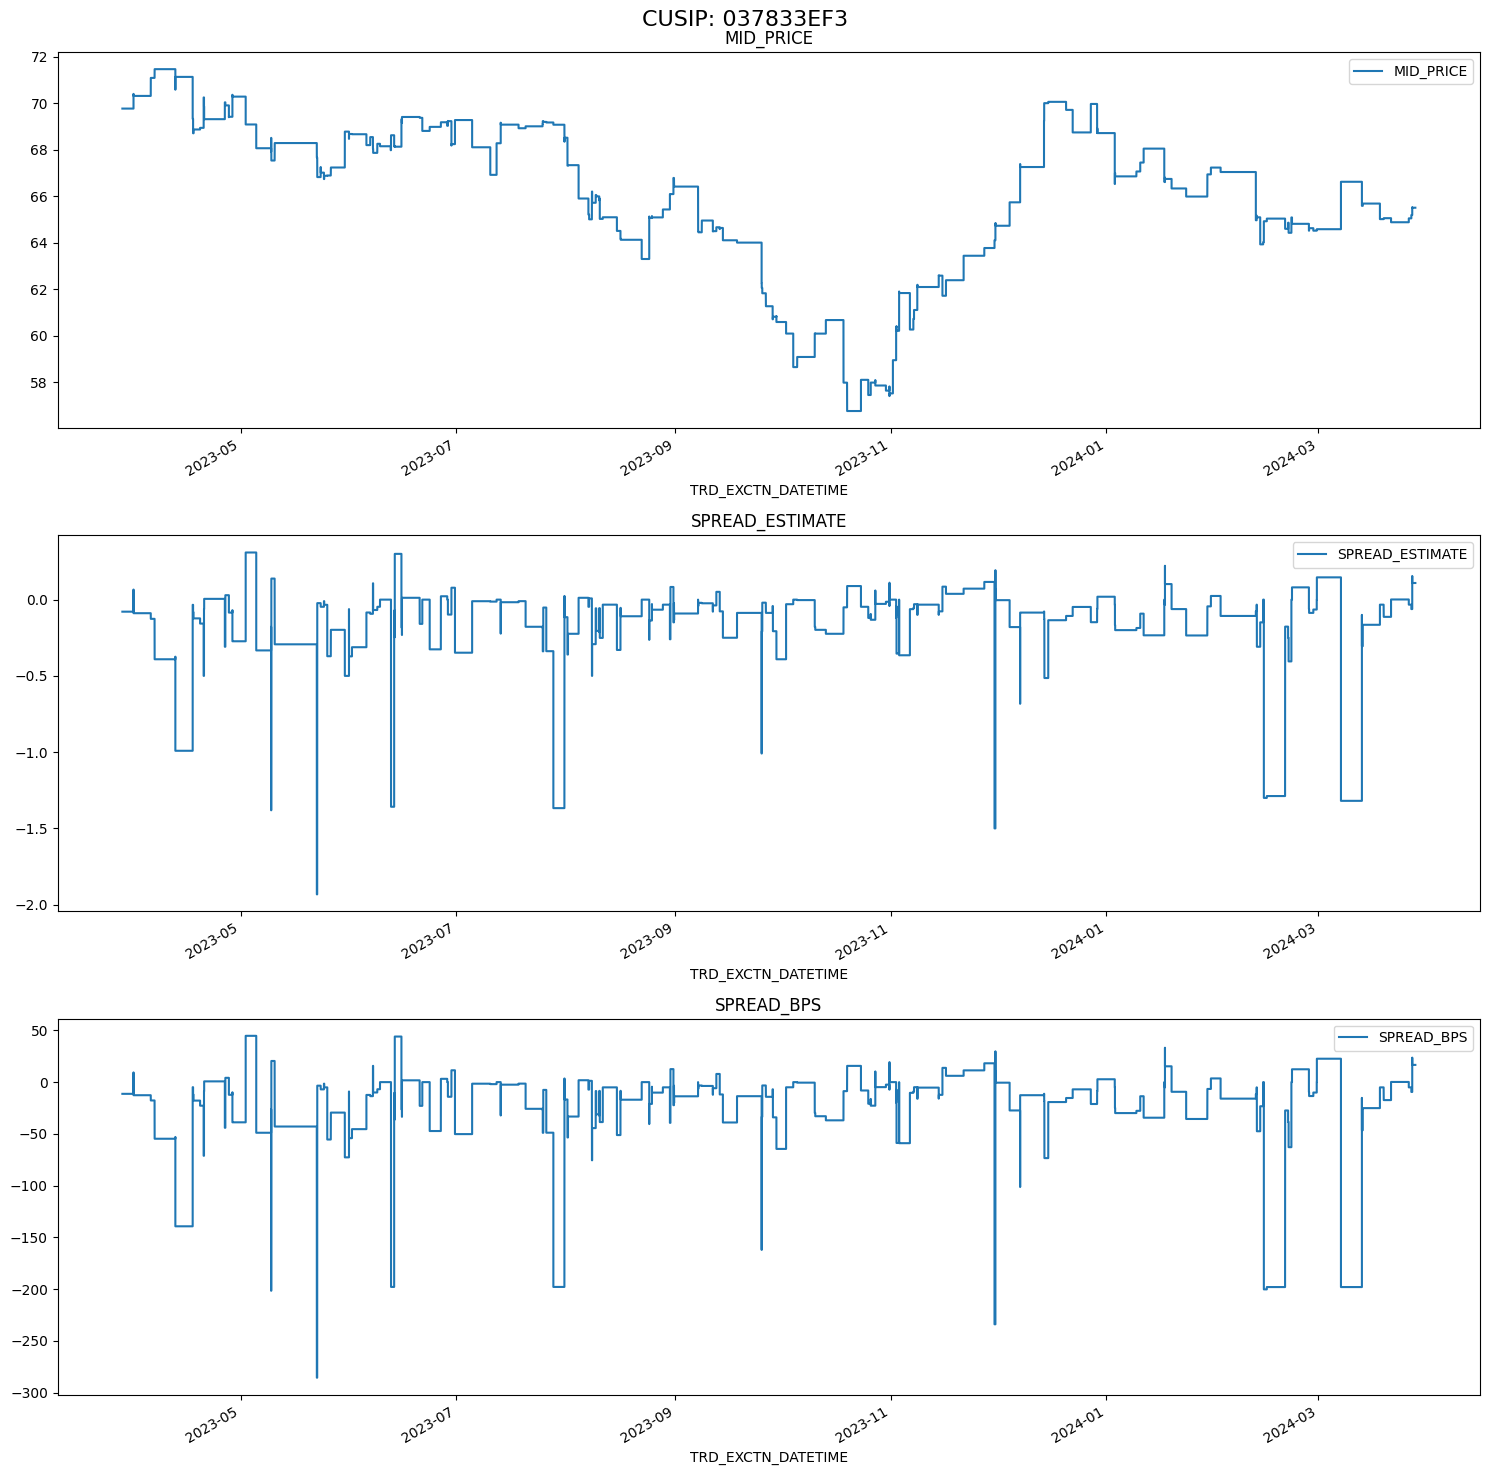

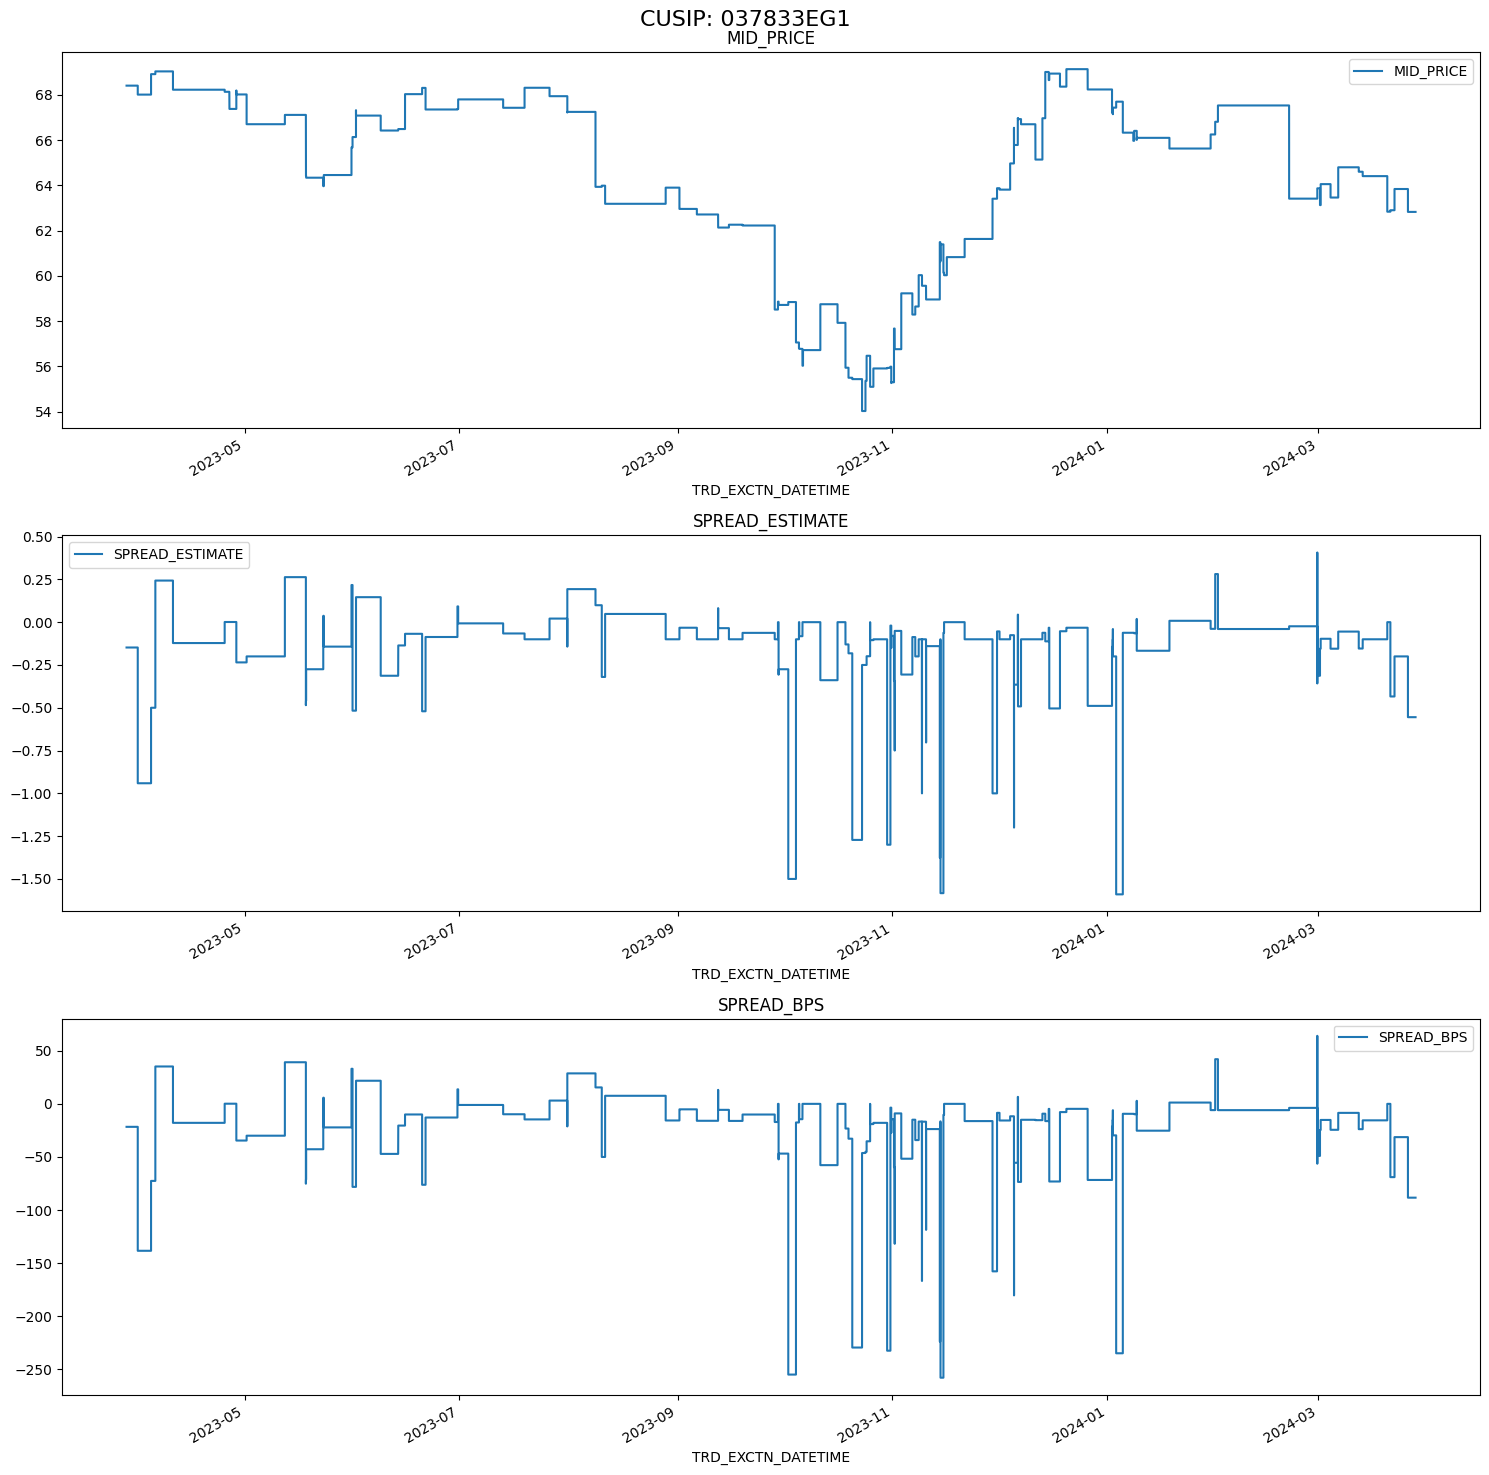

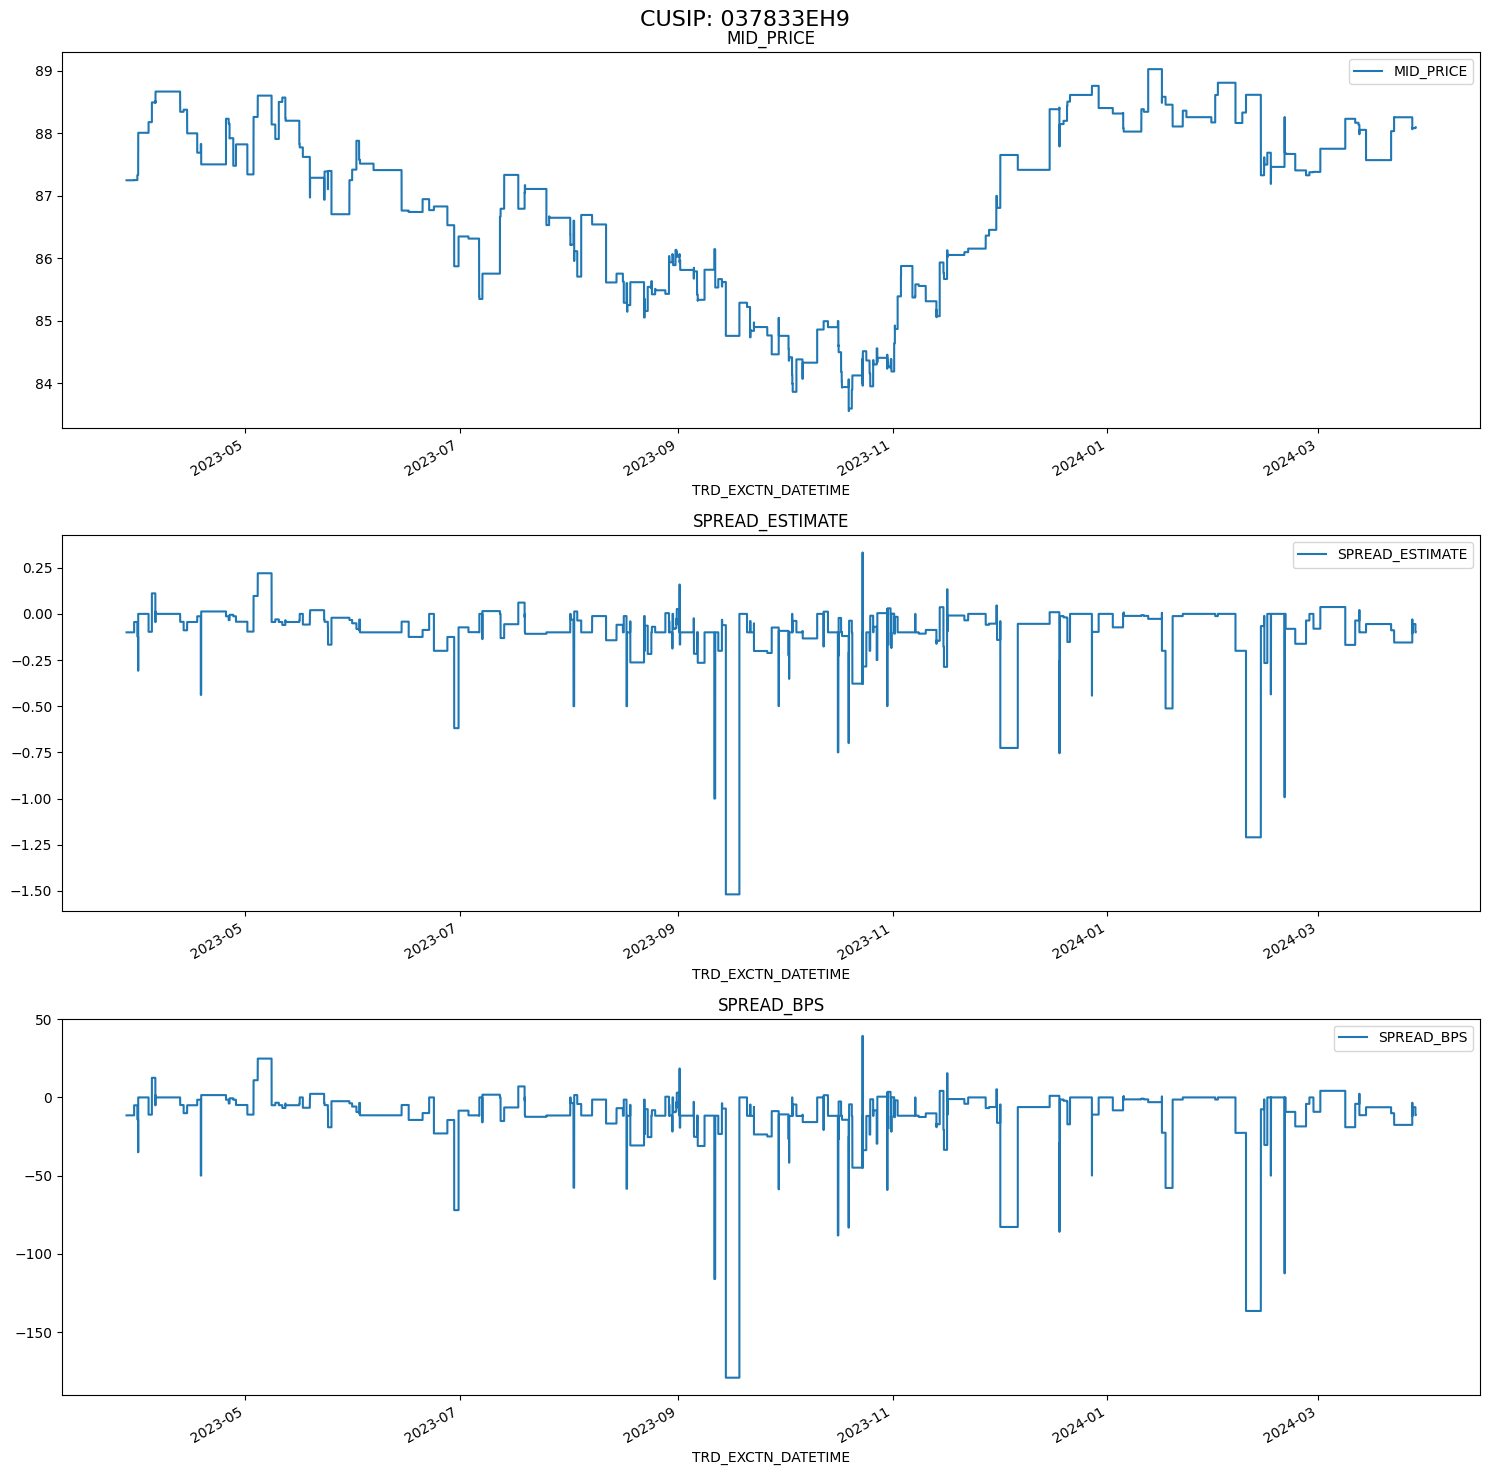

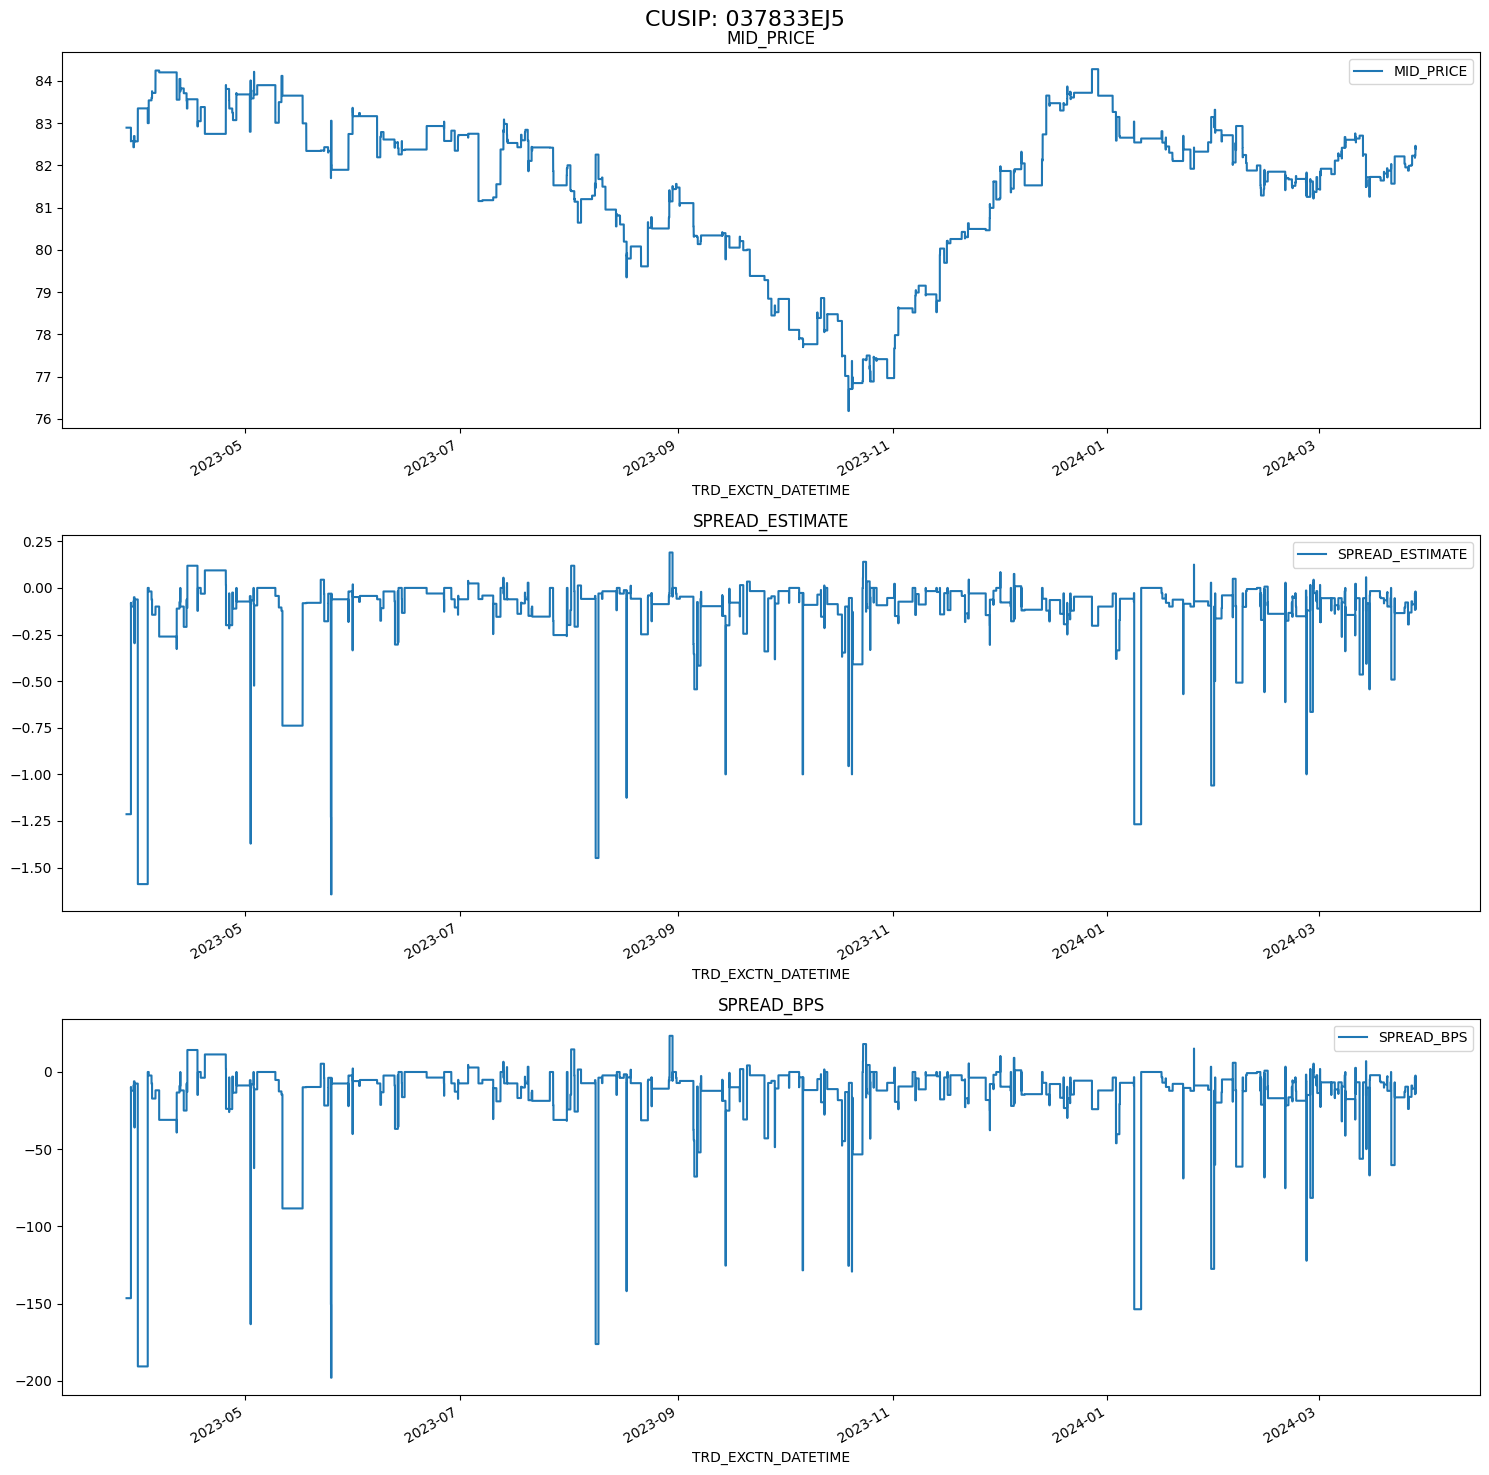

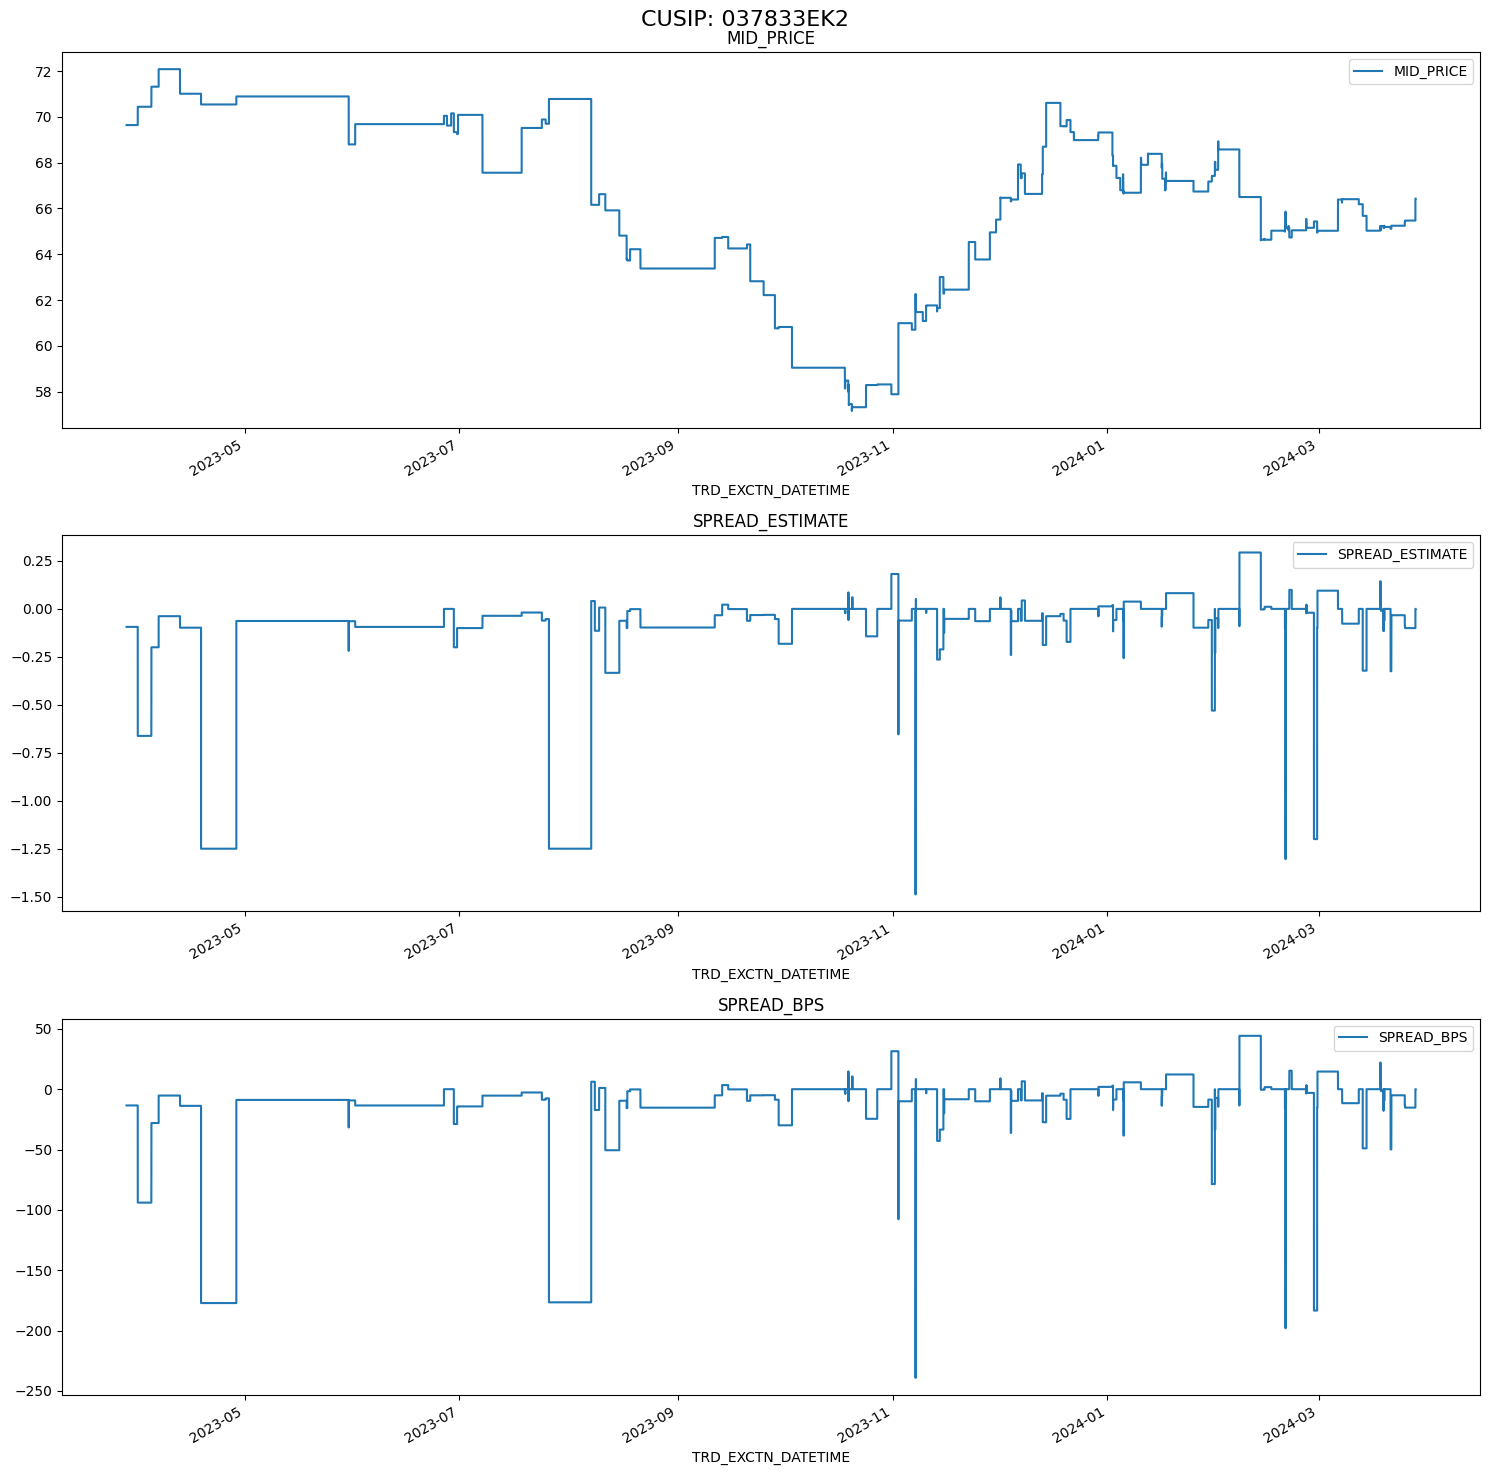

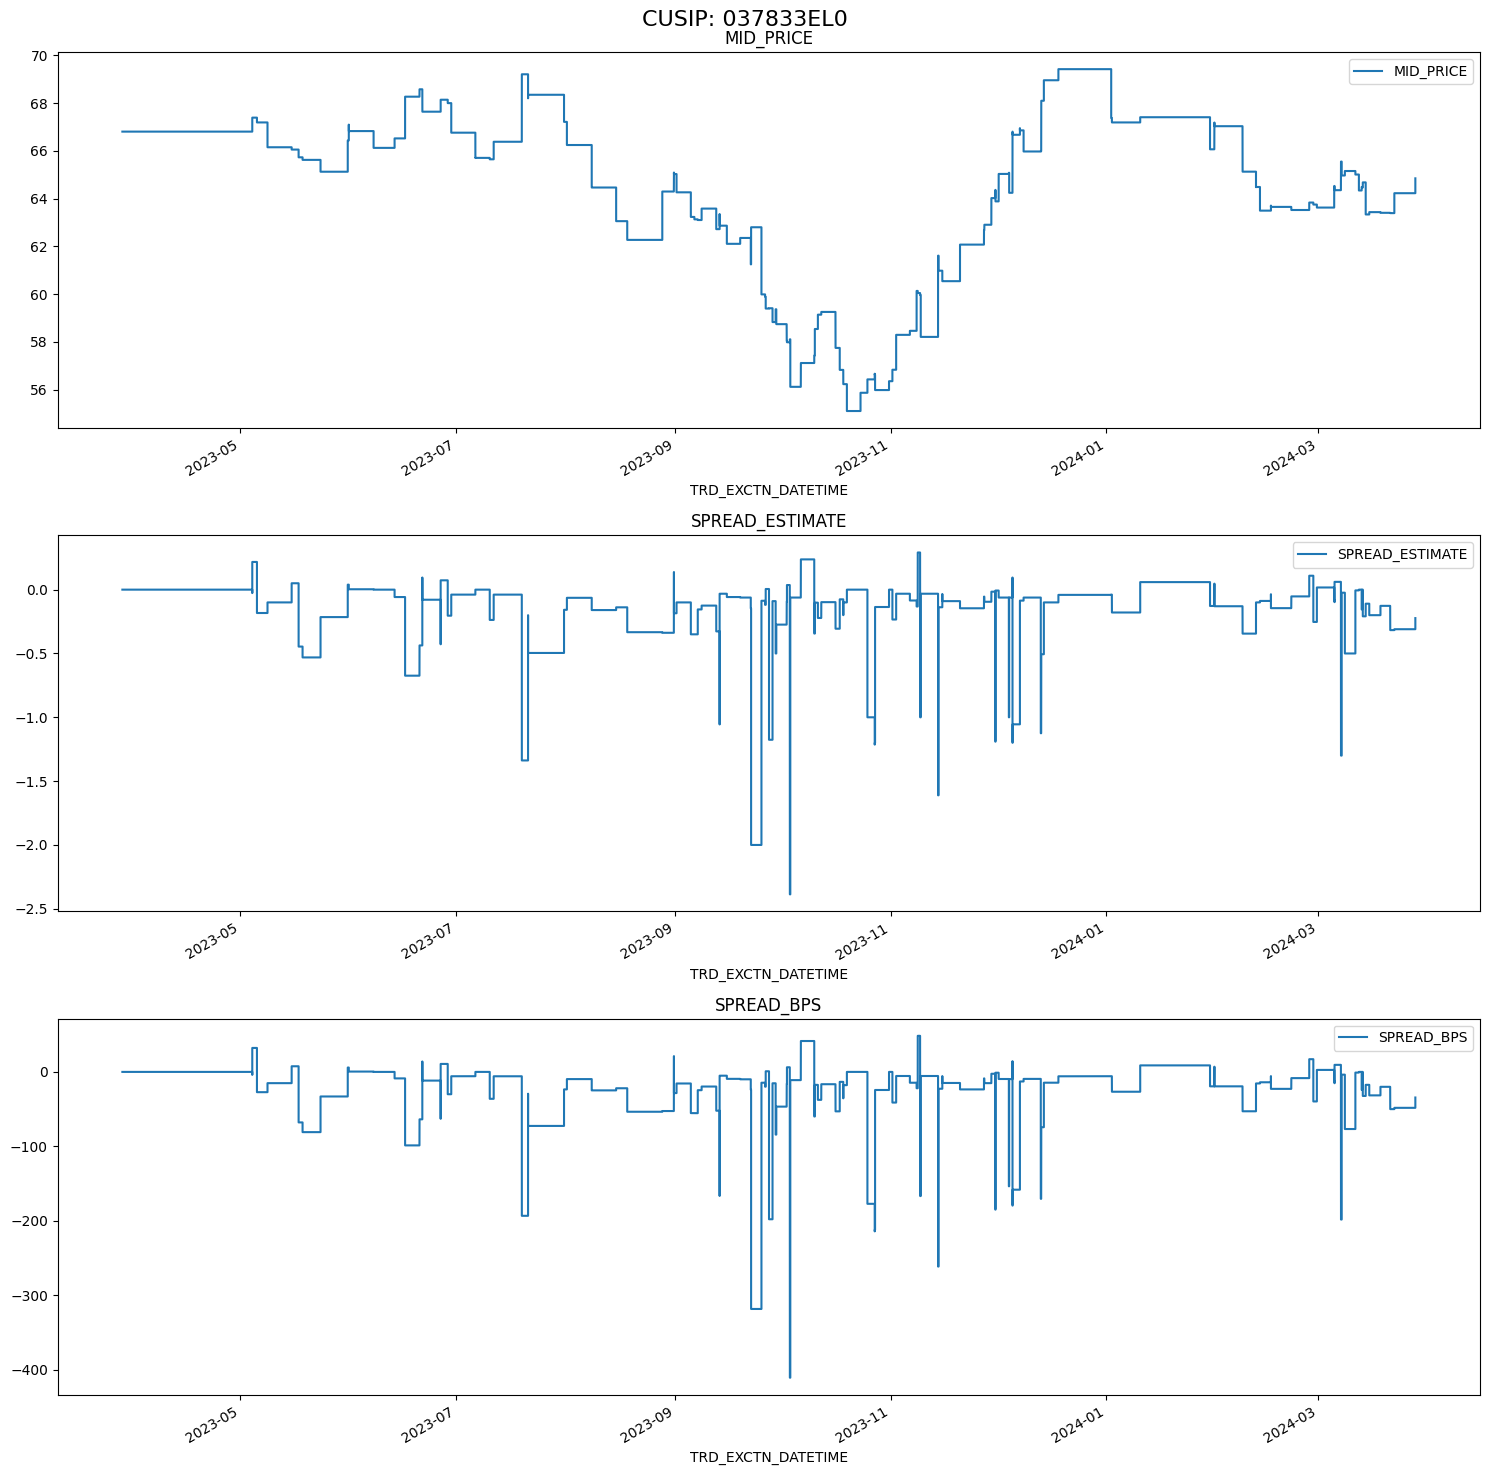

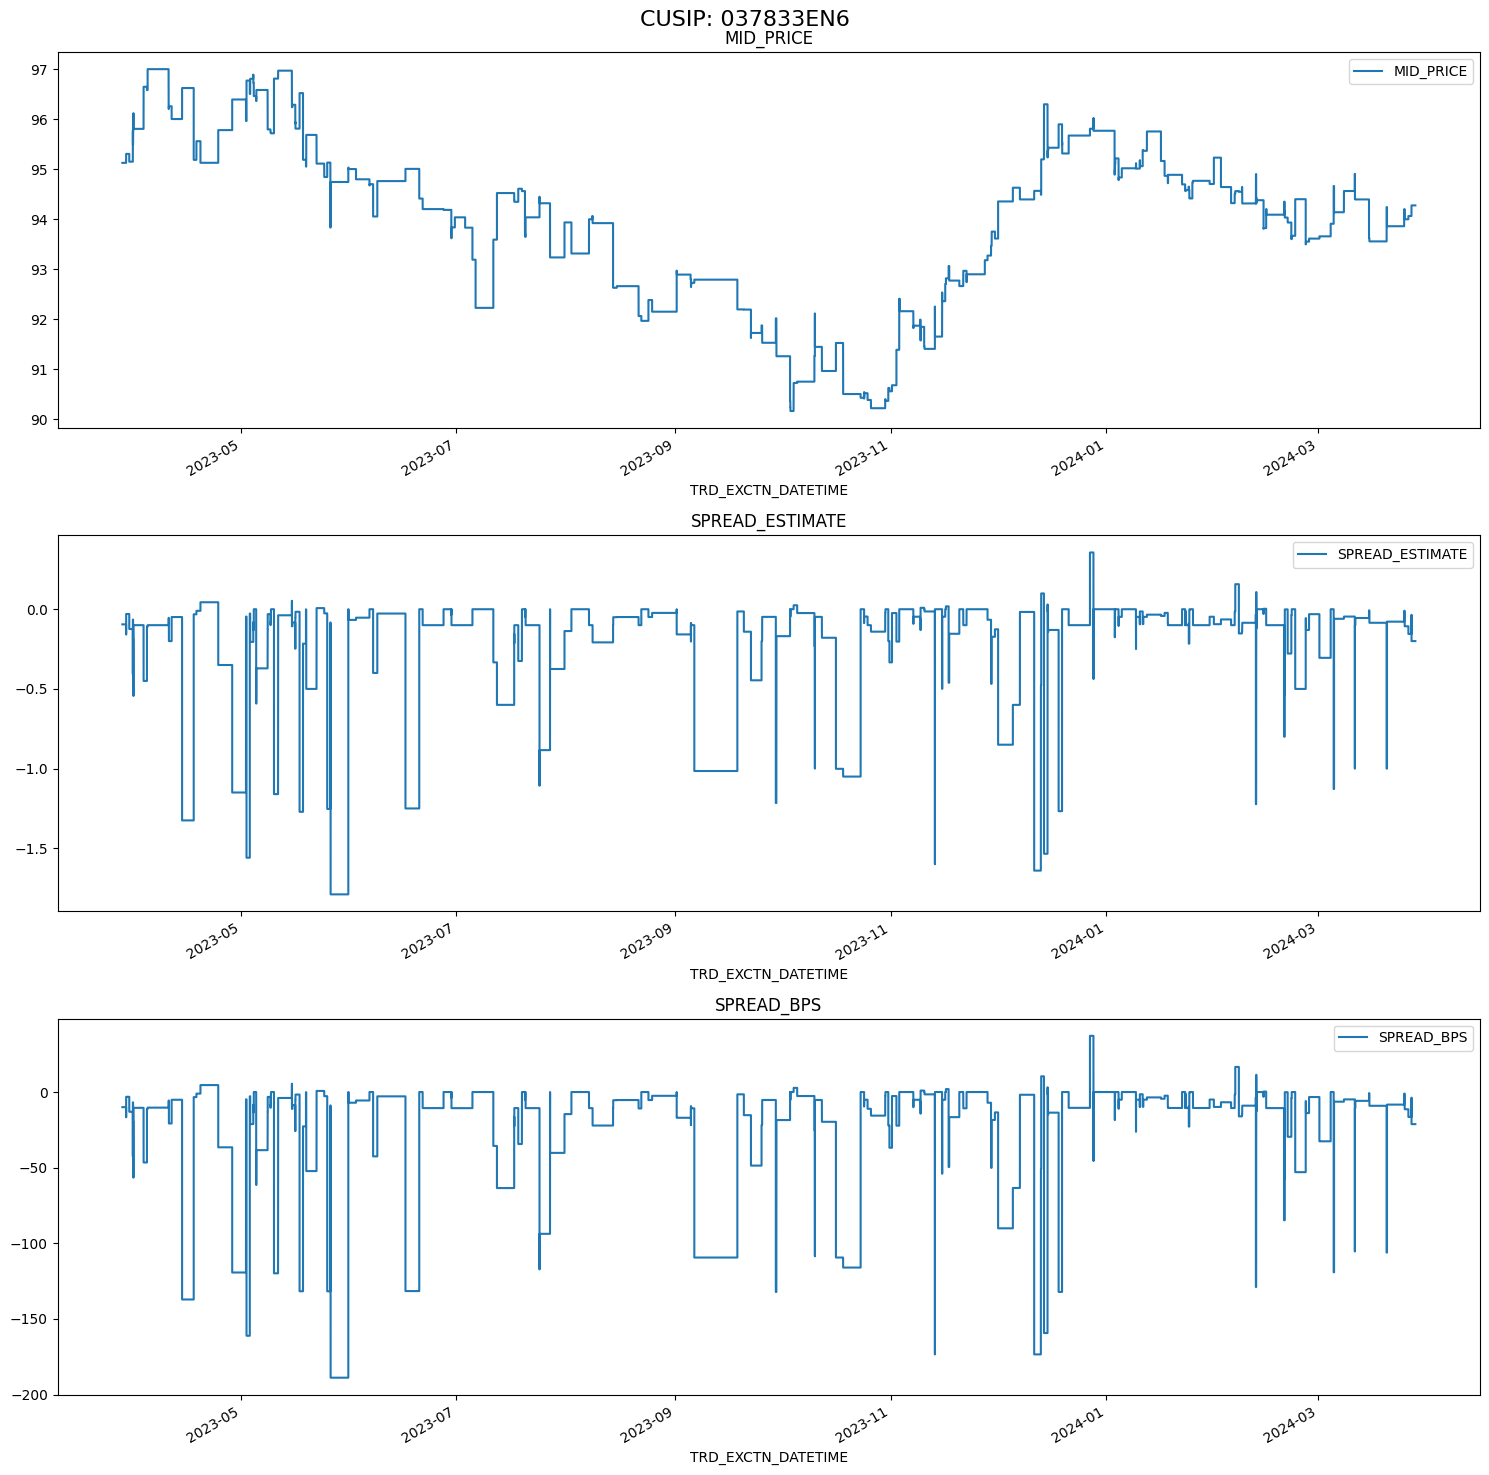

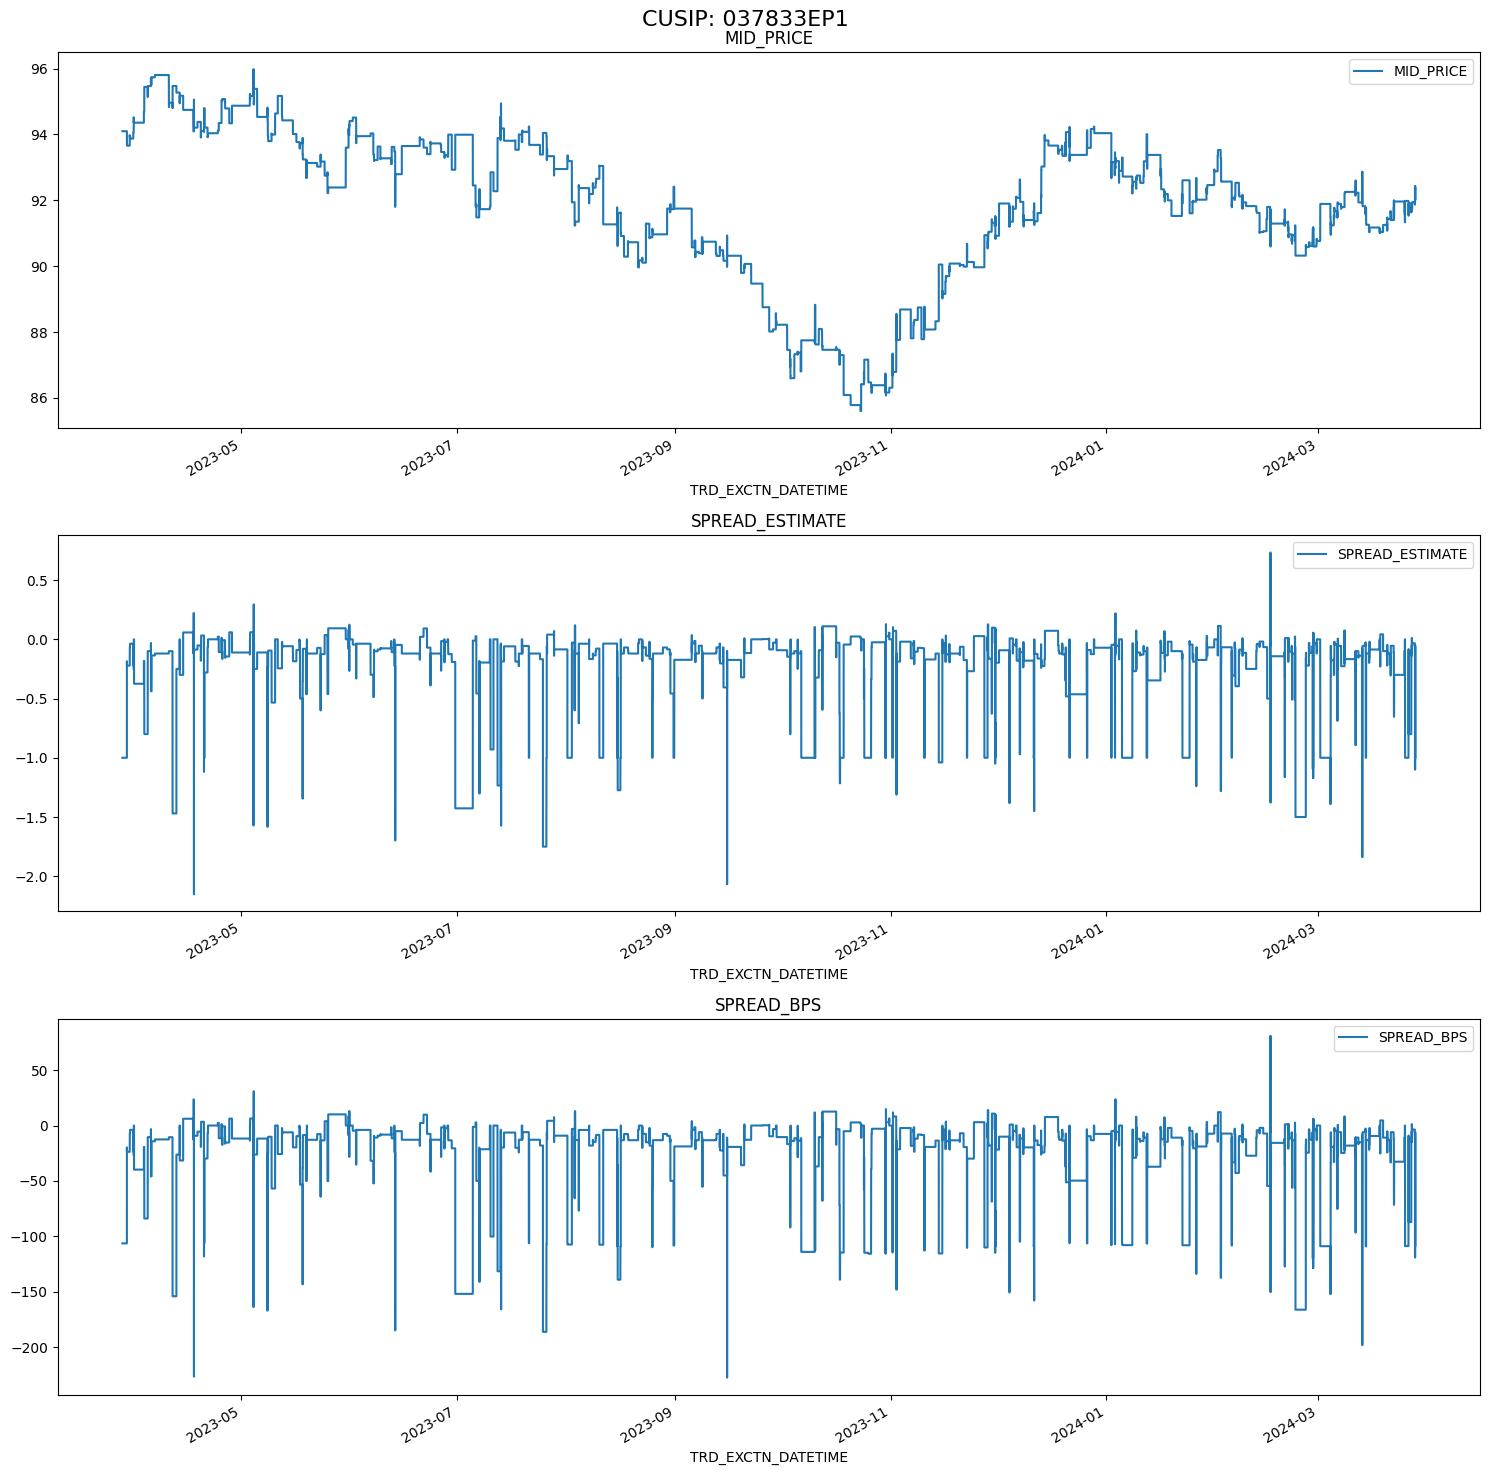

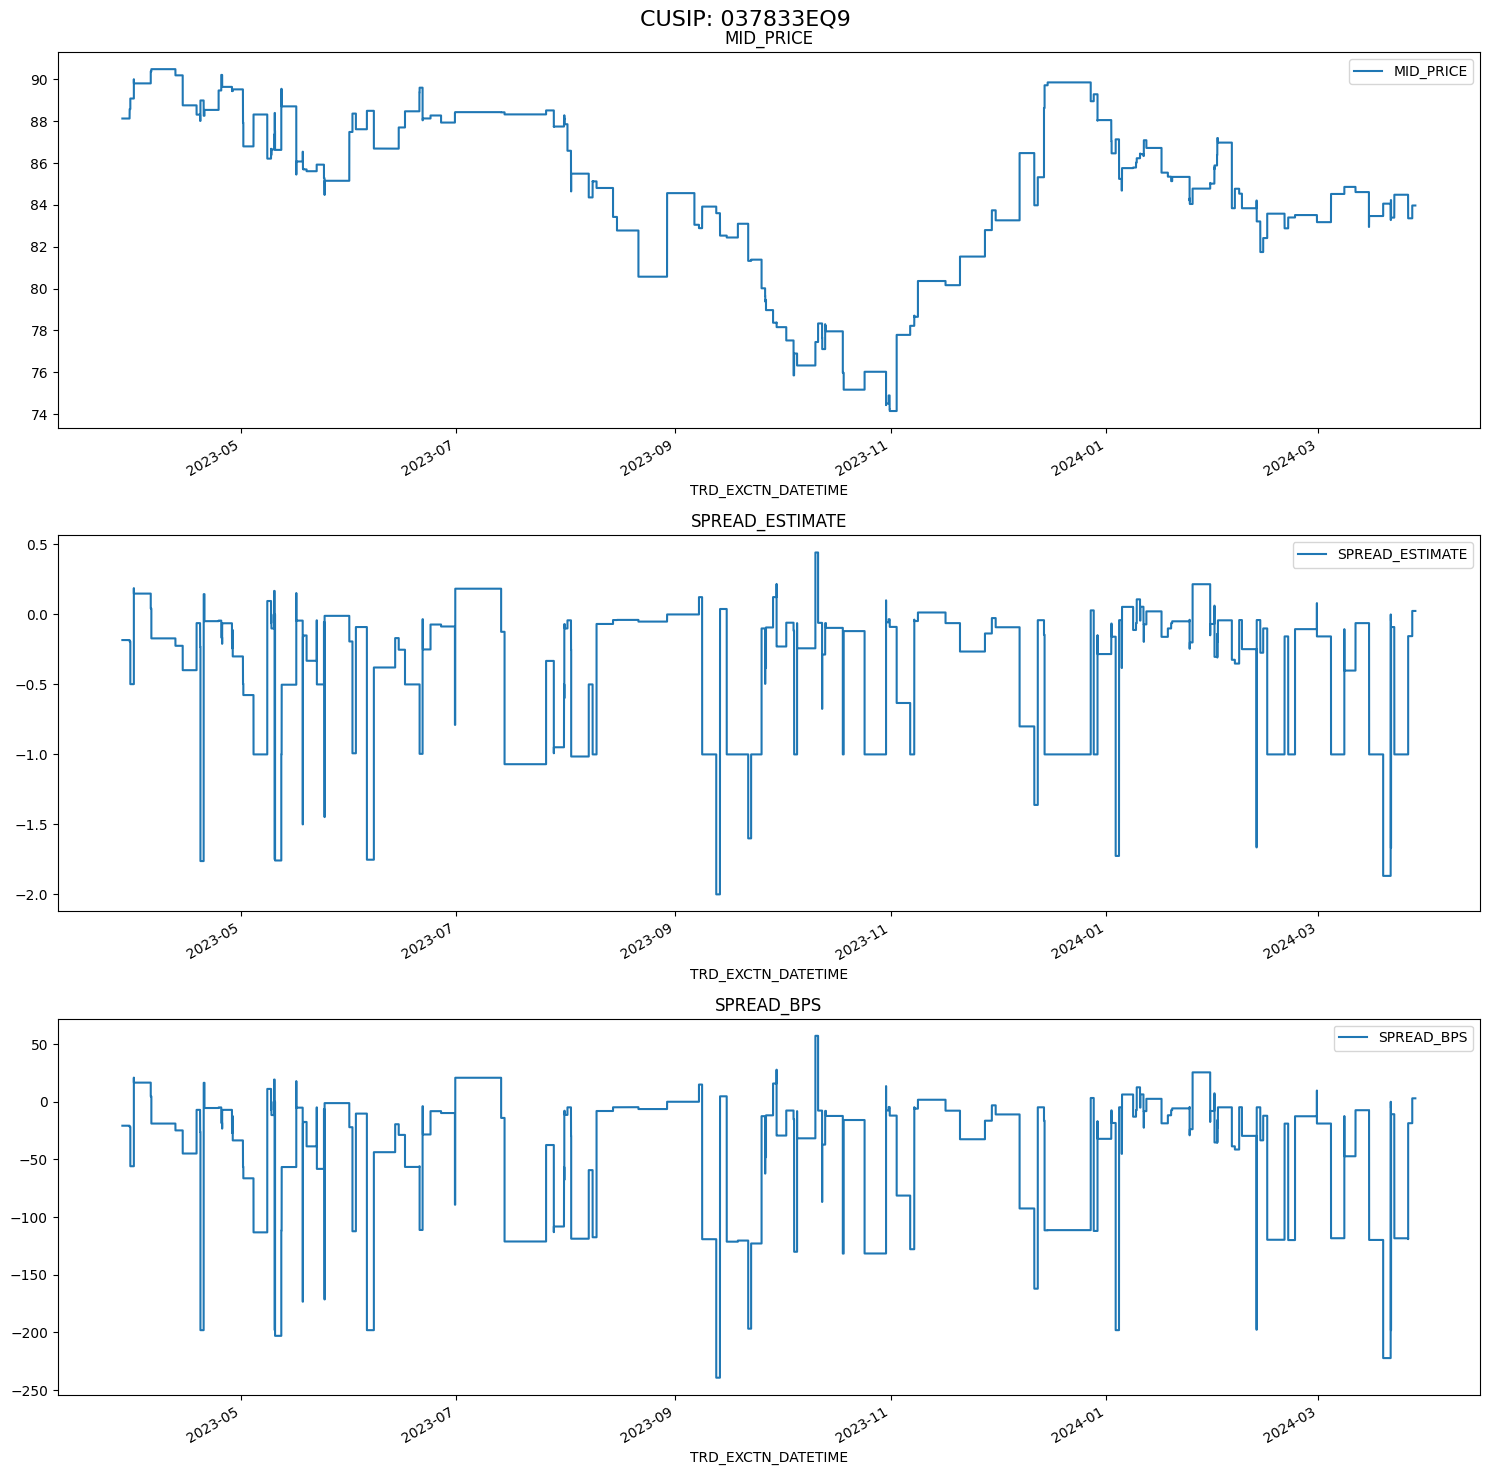

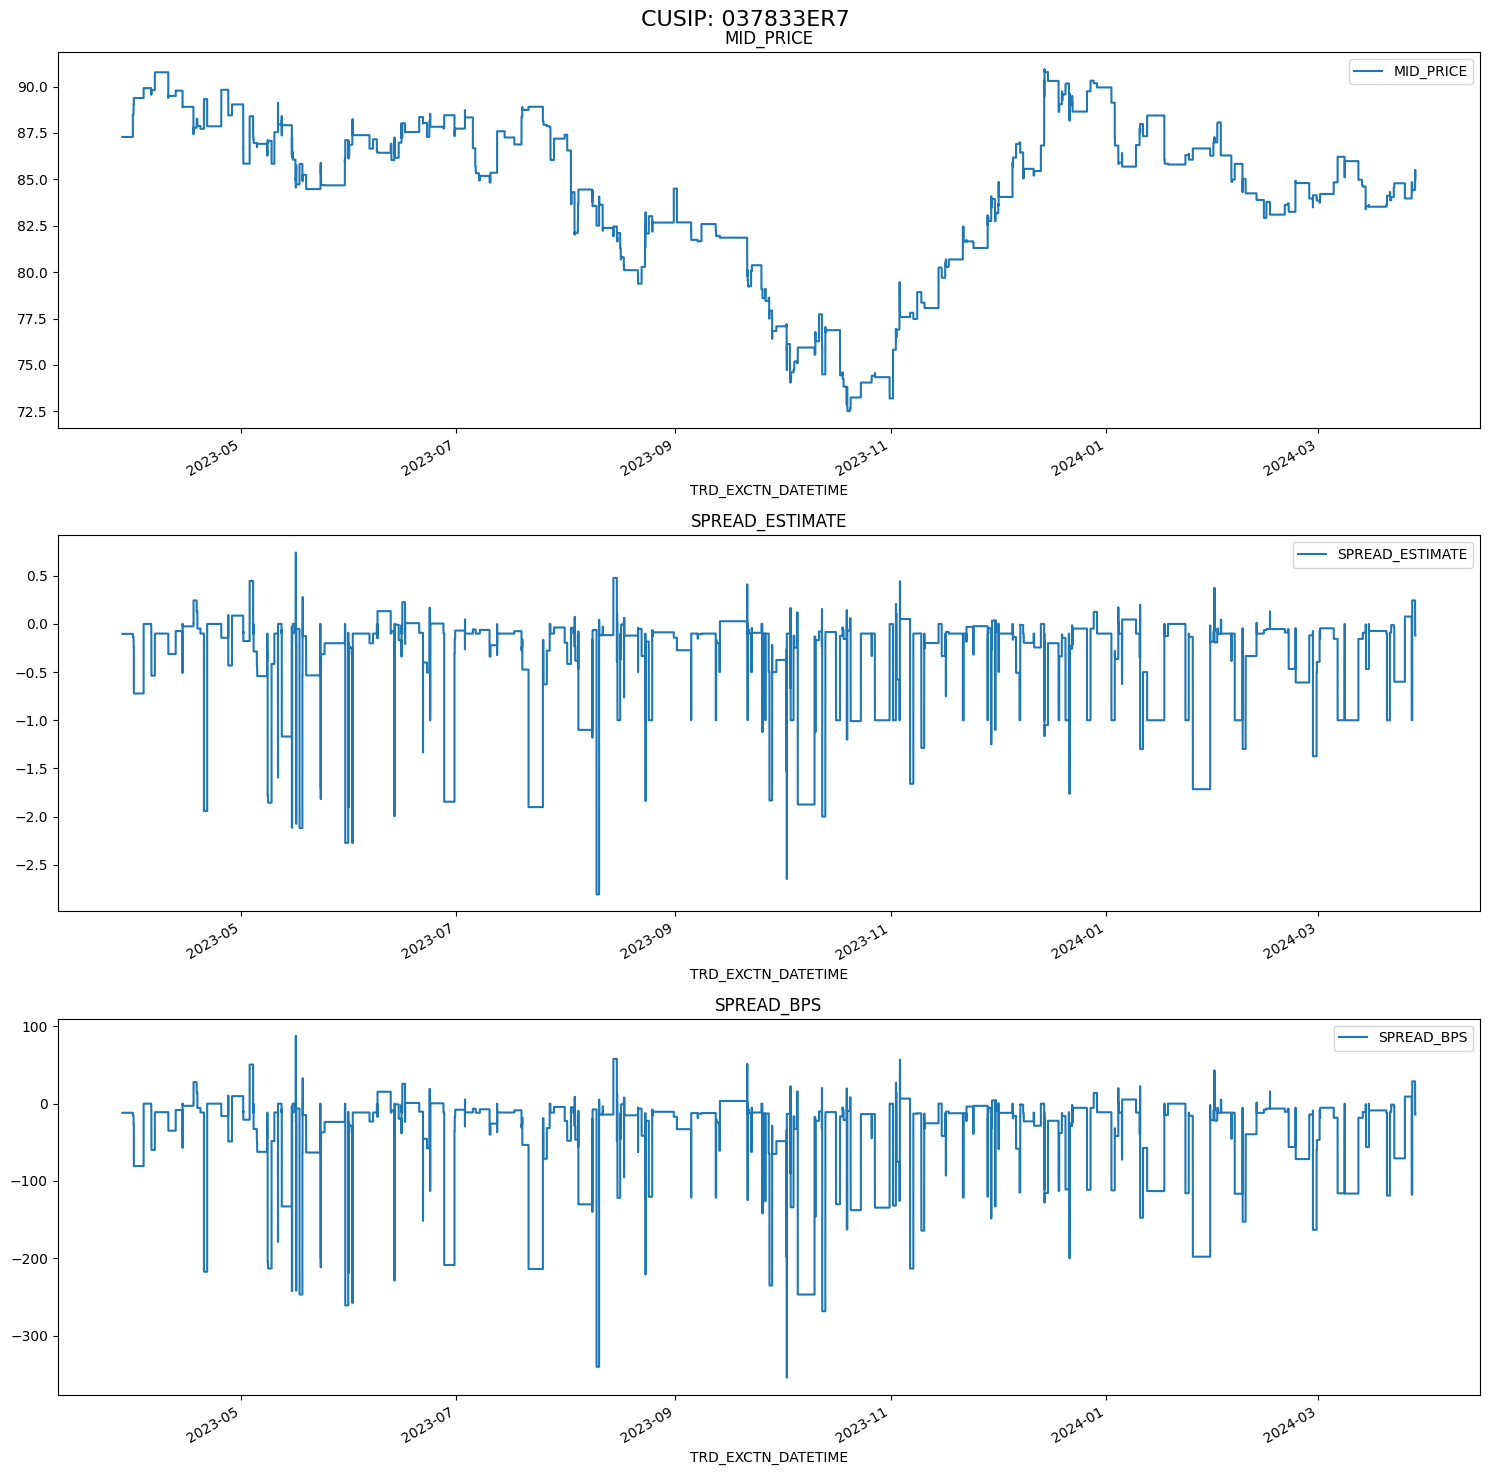

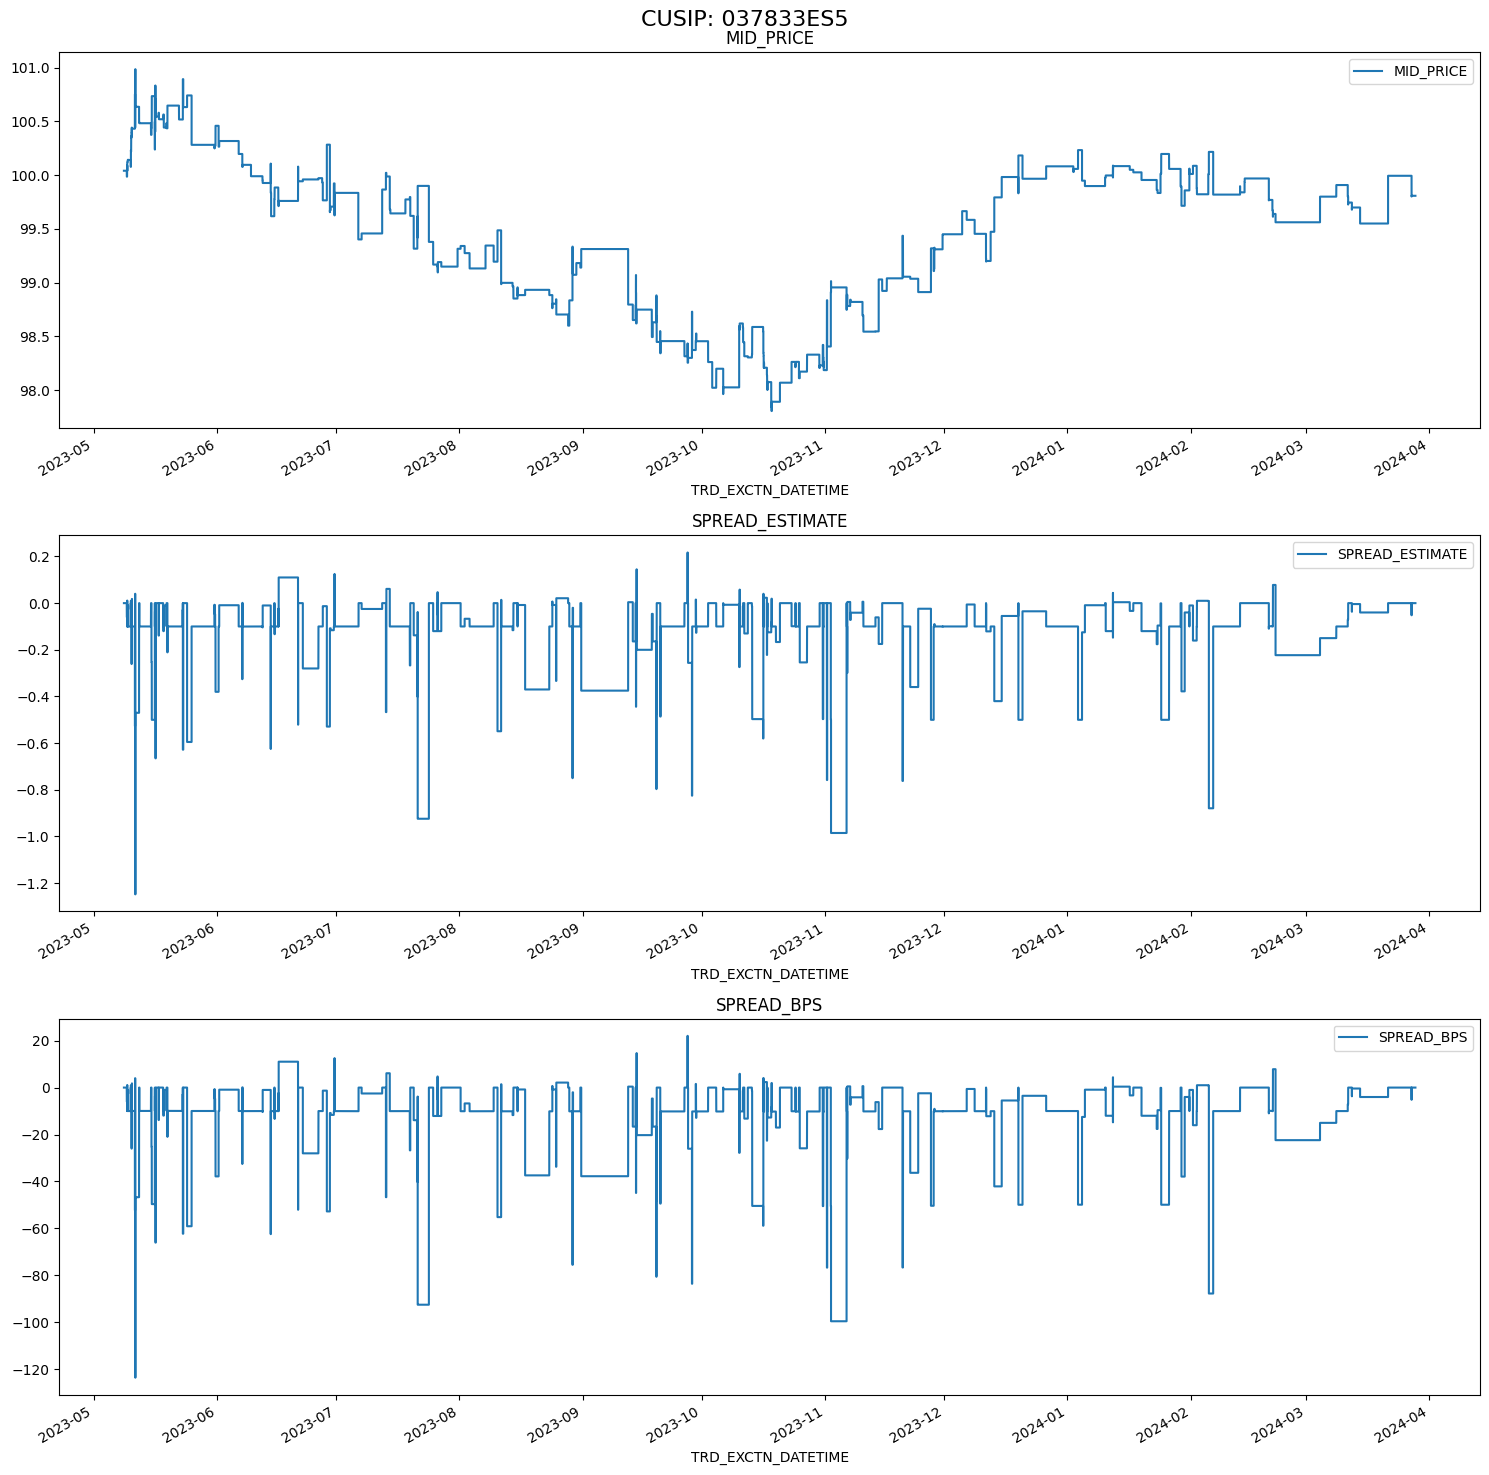

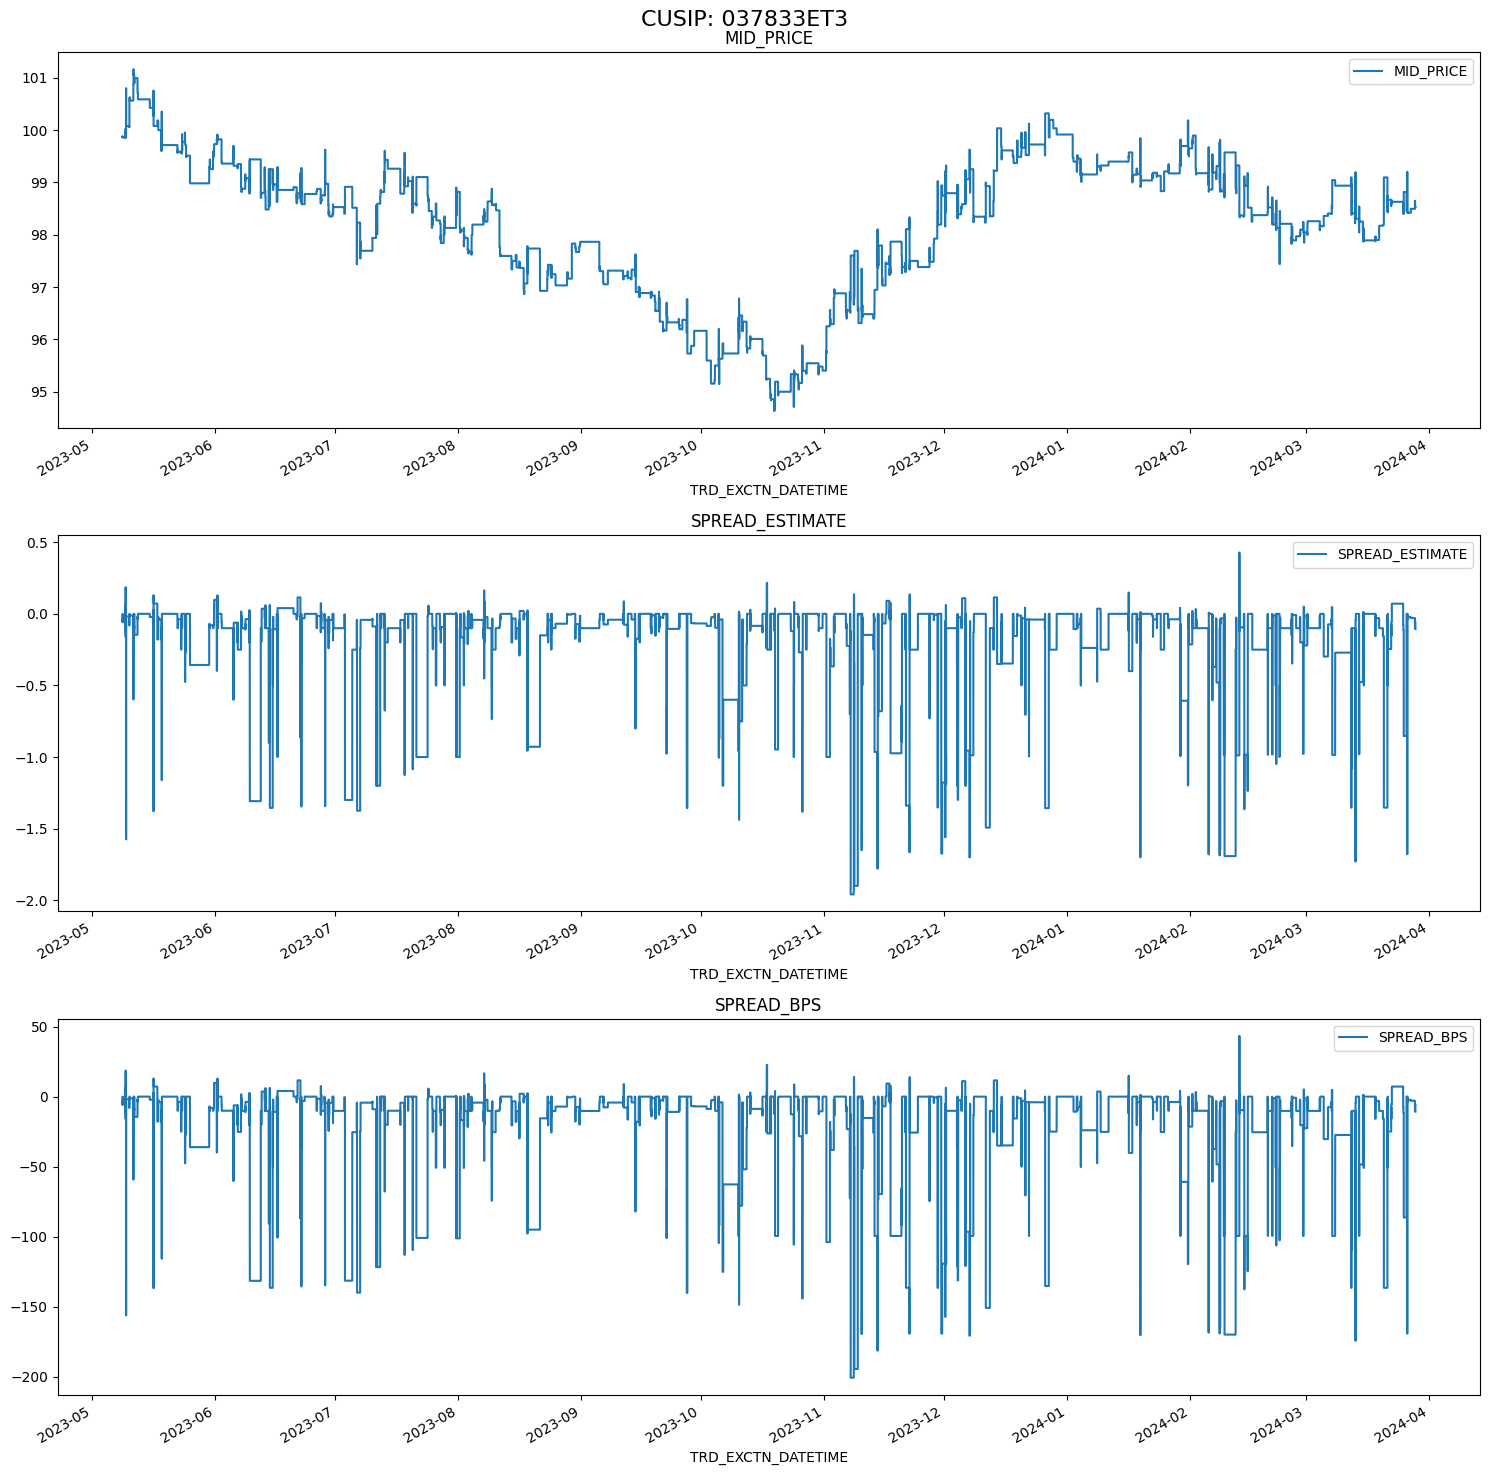

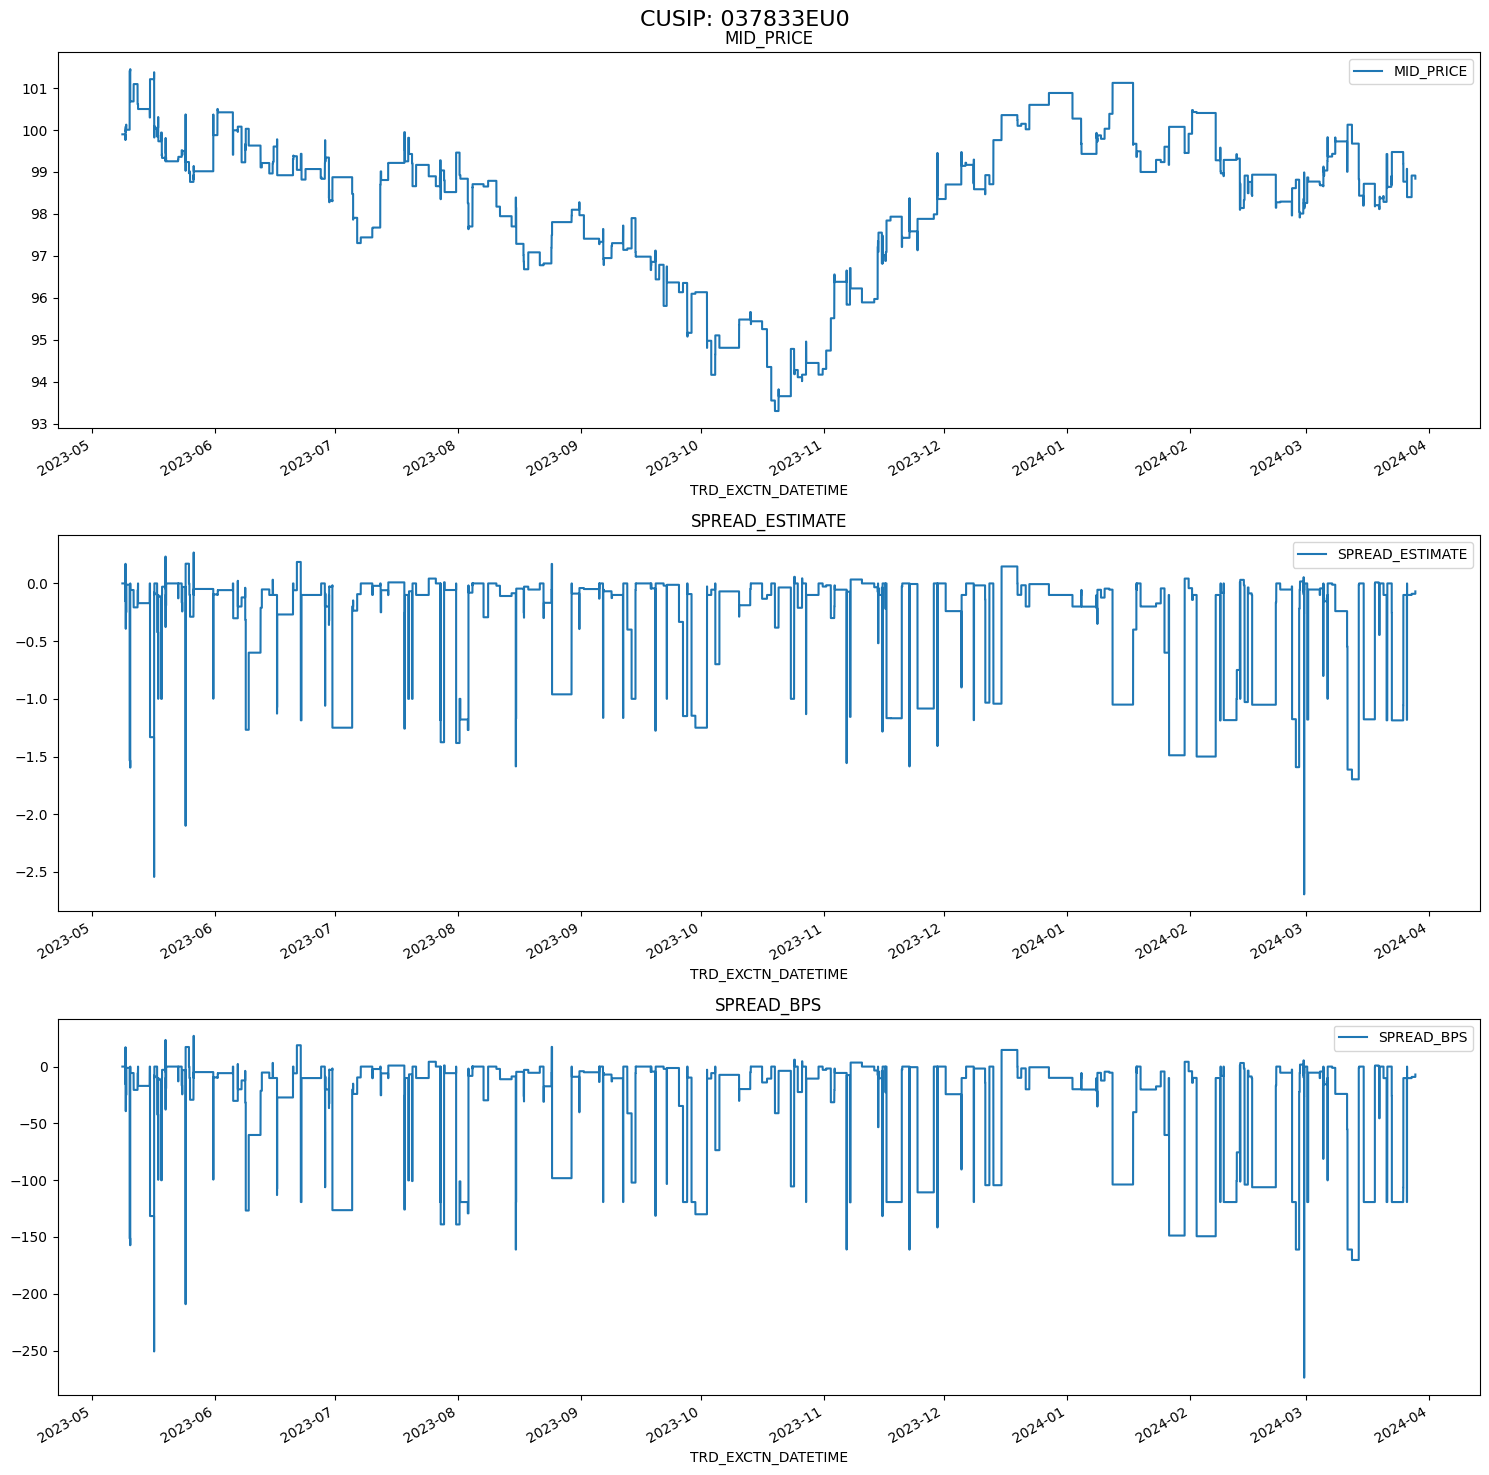

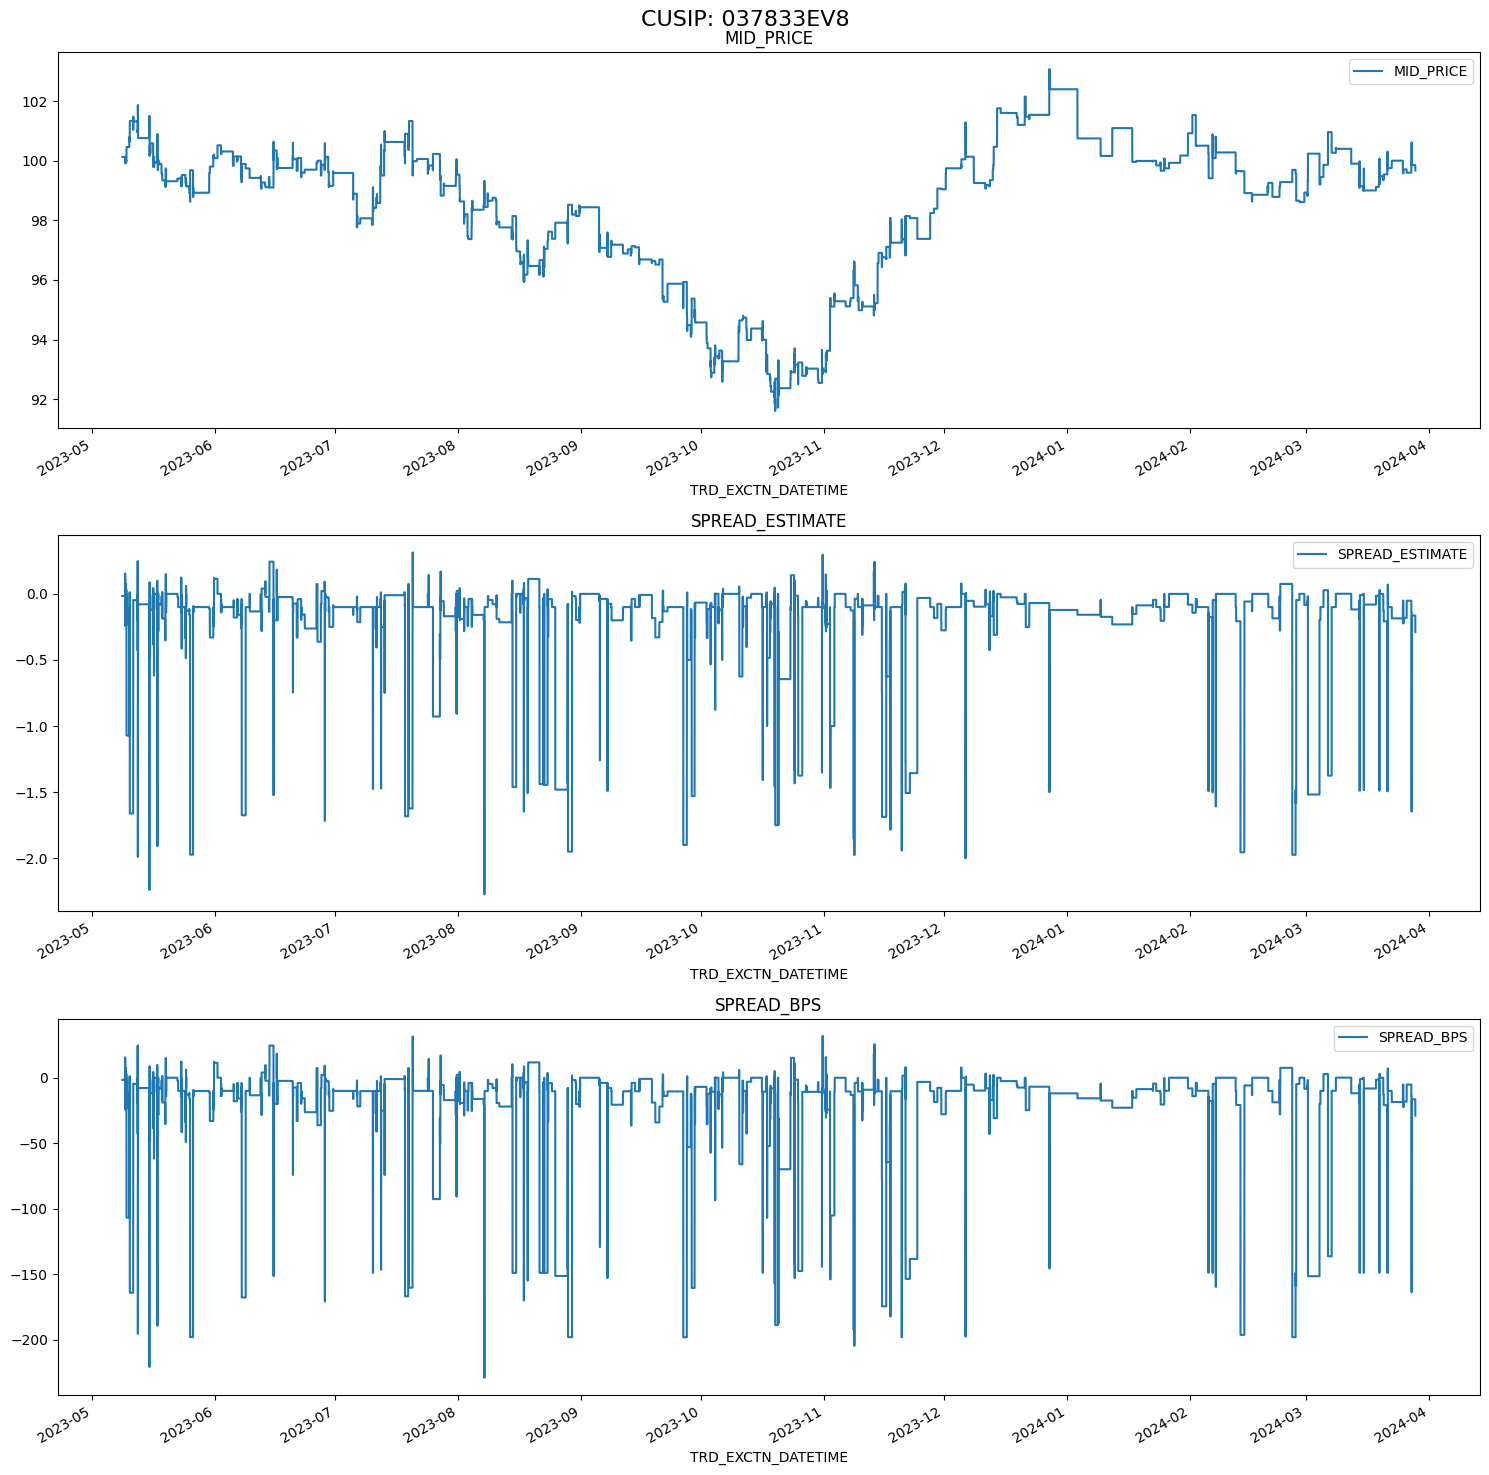

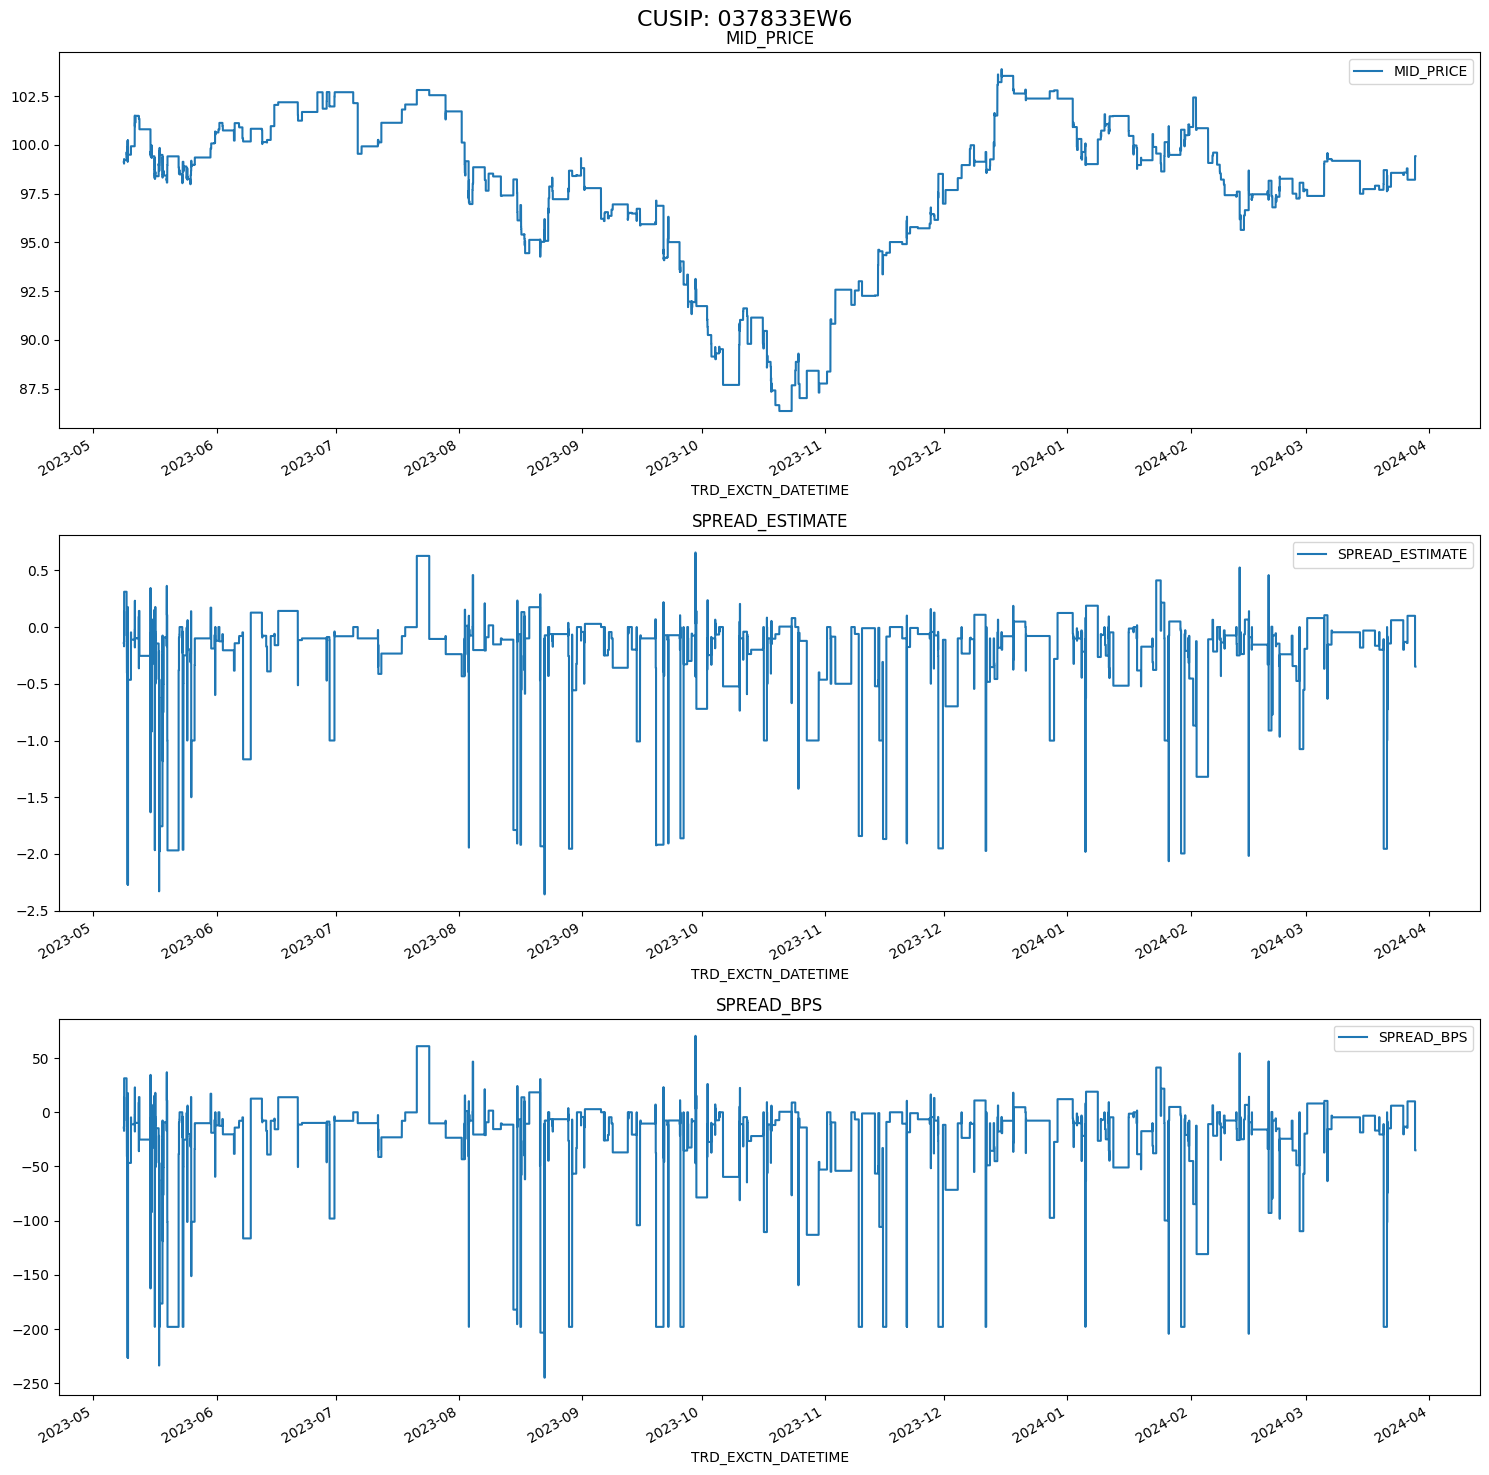

Empty DataFrame
Columns: []
Index: []

In [55]:
def plot_cusip(group):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(f"CUSIP: {group['CUSIP_ID'].iloc[0]}", fontsize=16)
    
    group.plot(x='TRD_EXCTN_DATETIME', y='MID_PRICE', ax=ax1, title='MID_PRICE')
    group.plot(x='TRD_EXCTN_DATETIME', y='SPREAD_ESTIMATE', ax=ax2, title='SPREAD_ESTIMATE')
    group.plot(x='TRD_EXCTN_DATETIME', y='SPREAD_BPS', ax=ax3, title='SPREAD_BPS')
    
    plt.tight_layout()
    #plt.savefig(f"CUSIP_{group['CUSIP_ID'].iloc[0]}.png")
    plt.show()


result_temp_df2.groupby('CUSIP_ID').apply(plot_cusip)

### 2. Bid-Ask Spread: Feature Selection and Modelling

- Identify key features that drive the bid ask spread which provides the estimated cost for investors who needs to move from on side to another side (eg. from buy side to sell side)
### Additional Data 
- Bond Information : time to maturity, yield, coupon rate, effective duration, time of issuance
- Risk Characteristics : credit risk, OAS, spread risk (duration times spread), yield curve risk,
- Will equity information (momentum, , financial ratios (RoA, EBITDA, Leverage, Gearing) be helpful - they should logically - test this!
- Trade information : avg trade price over a period, volatility, order flow imbalance (volume of Buys - Sells), number of trades, trade imbalance, correlation with industry avg, number of active dealers, smart money trading v/s retail trading (further bifurcate into additional classes) 
- Broader Macro information : treasury rates of different periods, industry factor, country factor, political changes
- Event Informations : quarter result announcements, annual anouncements, earnings or other qualitative factor extracted from the account statements

## Task List: 
- Start with simple linear models as benchmark: Regularized linear regression, Lasso, Ridge, ElasticNet 
- Try capturing non-linearities between structured data and feature relevance using Tree Based Methods -> can then extend to Neural Networks (MLP - for capturing complex relationships between bond and trade related features)
- RNNs/LSTM can be implemented to understand temporal dependencies in trading behavior and market condition on week-to-week basis (adjust the granularity)
- Both macro-level and micro-level clustering analysis can be done on regimes
    - Try dvelving into regime analysis using SVRs or Hidden Markov Models to classify various states of a bond spread (which can later be served as another feature - "Regime")